# Graph assembly and alignment

In [3]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2020_06_04', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

### imports 

In [1]:
# Standard lib imports
import os
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
from tqdm import tqdm
import csv
import re

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx
import pybedtools as pbt
import pyranges as pr
import mappy as mp

# Ploting lib imports
import matplotlib.pyplot as pl
from matplotlib.colors import rgb2hex
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
pd.options.display.min_rows = 100


Bad key "text.kerning_factor" on line 4 in
/nfs/software/birney/adrien/miniconda3/envs/Python3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Download reference assembly

In [25]:
outdir = "./references/"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/references2


In [29]:
outdir = "./references/"
for label, link in (
    ("HDRR", "ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes/dna/Oryzias_latipes.ASM223467v1.dna.toplevel.fa.gz"),
    ("HDRR+", "http://utgenome.org/medaka_v2/Medaka-Hd-rR-PacBio_unanchored_contigs.fasta.gz"),
    ("HNI", "ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes_hni/dna/Oryzias_latipes_hni.ASM223471v1.dna.toplevel.fa.gz"),
    ("HNI+", "http://utgenome.org/medaka_v2/Medaka-HNI-PacBio_unanchored_contigs.fasta.gz"),
    ("HSOK", "ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes_hsok/dna/Oryzias_latipes_hsok.ASM223469v1.dna.toplevel.fa.gz"),
    ("HSOK+", "http://utgenome.org/medaka_v2/Medaka-HSOK-PacBio_unanchored_contigs.fasta.gz")):
    
    print(f"Downloading and cleaning {label}")   
    zipped_fn = f"./{outdir}/Oryzias_latipes_{label}.fa.gz"
    unziped_fn = f"./{outdir}/Oryzias_latipes_{label}.fa"
    cleaned_fn = f"./{outdir}/Oryzias_latipes_{label}_clean.fa"
    
    # Download
    wget(link, zipped_fn)
    
    # Extract Gzip
    gunzip_file(zipped_fn, unziped_fn)

    # Clean up fasta names
    with open(cleaned_fn, "w") as fa_out, pyfaidx.Fasta(unziped_fn) as fa_in:
        for seq in fa_in:
            fa_out.write(f">{label}_{seq.name}\n{str(seq)}\n")

    # Index file
    with pyfaidx.Fasta(cleaned_fn) as fa:
        print(len(fa))

    # Remove originals
    for fn in [zipped_fn, unziped_fn, unziped_fn+".fai"]:
        os.remove(fn)

Downloading: ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes/dna/Oryzias_latipes.ASM223467v1.dna.toplevel.fa.gz	Bytes: 223527279
100.0 MB Downloaded	[44.74 %]
200.0 MB Downloaded	[89.47 %]
223.5 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HDRR.fa.gz
734057086
Downloading: http://utgenome.org/medaka_v2/Medaka-Hd-rR-PacBio_unanchored_contigs.fasta.gz	Bytes: 15437627
15.4 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HDRR+.fa.gz
55662681
Downloading: ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes_hni/dna/Oryzias_latipes_hni.ASM223471v1.dna.toplevel.fa.gz	Bytes: 207712664
100.0 MB Downloaded	[48.14 %]
200.0 MB Downloaded	[96.29 %]
207.7 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HNI.fa.gz
677633405
Downloading: http://utgenome.org/medaka_v2/Medaka-HNI-PacBio_unanchored_contigs.fasta.gz	Bytes: 20844315
20.8 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HNI+.fa.gz
7142665

In [100]:
outdir = "./references/"
for label, link in (
    ("HDRR", "ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes/Oryzias_latipes.ASM223467v1.100.gff3.gz"),
    ("HNI", "ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes_hni/Oryzias_latipes_hni.ASM223471v1.100.gff3.gz"),
    ("HSOK", "ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes_hsok/Oryzias_latipes_hsok.ASM223469v1.100.gff3.gz")):
    
    print(f"Downloading and cleaning {label}")   
    zipped_fn = f"./{outdir}/Oryzias_latipes_{label}.gff3.gz"
    unziped_fn = f"./{outdir}/Oryzias_latipes_{label}.gff3"
    cleaned_fn = f"./{outdir}/Oryzias_latipes_{label}_clean.gff3"
    sorted_fn = f"./{outdir}/Oryzias_latipes_{label}_sorted.gff3"
    
    # Download
    wget(link, zipped_fn)
    # Extract Gzip
    gunzip_file(zipped_fn, unziped_fn)
    
    # Clean fasta names
    with open(unziped_fn, "r") as gff_in, open(cleaned_fn, "w") as gff_out:
        for line in gff_in:
            line = line.strip()
            
            if line.startswith("##sequence-region"):
                line = line.split()
                line[1] = "{}_{}".format(label, line[1])
                line = "\t".join(line)
            if line[0] != "#":
                line = line.split()
                line[0] = "{}_{}".format(label, line[0])
                line = "\t".join(line)
            gff_out.write(line+"\n")
        
    # Sort and index for IGV
    bash (f"igvtools sort {cleaned_fn} {sorted_fn}", conda="IGV")
    bash (f"igvtools index {sorted_fn}", conda="IGV")

    # Remove originals
    os.remove(zipped_fn)
    os.remove(unziped_fn)
    os.remove(cleaned_fn)

Downloading: ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes/Oryzias_latipes.ASM223467v1.100.gff3.gz	Bytes: 12175696
12.2 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HDRR.gff3.gz
Using system JDK.
WARN [2020-07-08T12:21:07,324]  [Globals.java:138] [main]  Development mode is enabled
Sorting ././references2//Oryzias_latipes_HDRR_clean.gff3  -> ././references2//Oryzias_latipes_HDRR_sorted.gff3
Done
Using system JDK.
WARN [2020-07-08T12:21:17,035]  [Globals.java:138] [main]  Development mode is enabled
Done
Downloading: ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes_hni/Oryzias_latipes_hni.ASM223471v1.100.gff3.gz	Bytes: 11436936
11.4 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HNI.gff3.gz
Using system JDK.
WARN [2020-07-08T12:21:28,959]  [Globals.java:138] [main]  Development mode is enabled
Sorting ././references2//Oryzias_latipes_HNI_clean.gff3  -> ././references2//Oryzias_latipes_HNI_sorted.gff3
Done
Using system 

## Merge all fasta ref together

In [43]:
references_list = [
    './references/Oryzias_latipes_HDRR_clean.fa',
    './references/Oryzias_latipes_HDRR+_clean.fa',
    './references/Oryzias_latipes_HNI_clean.fa',
    './references/Oryzias_latipes_HNI+_clean.fa',
    './references/Oryzias_latipes_HSOK_clean.fa',
    './references/Oryzias_latipes_HSOK+_clean.fa']
alternative_list = glob.glob("./individual_assemblies/*_clean.fa")
all_ref = references_list+alternative_list

out_fn = "references/Oryzias_latipes_all_assemblies_contig.fa"

with open (out_fn, "w") as fa_out:
    for fasta_fn in all_ref:
        print(f"Copy {fasta_fn}")
        with open(fasta_fn,'r') as fa_in:
            shutil.copyfileobj(fa_in, fa_out)

with pyfaidx.Fasta(out_fn) as fa:
    print(len(fa))

Copy ./references2/Oryzias_latipes_HDRR_clean.fa
Copy ./references2/Oryzias_latipes_HDRR+_clean.fa
Copy ./references2/Oryzias_latipes_HNI_clean.fa
Copy ./references2/Oryzias_latipes_HNI+_clean.fa
Copy ./references2/Oryzias_latipes_HSOK_clean.fa
Copy ./references2/Oryzias_latipes_HSOK+_clean.fa
Copy ./individual_assemblies/69-1_F3_clean.fa
Copy ./individual_assemblies/131-1_F4_clean.fa
Copy ./individual_assemblies/117-2_C4_clean.fa
Copy ./individual_assemblies/4-2_B2_clean.fa
Copy ./individual_assemblies/7-2_F2_clean.fa
Copy ./individual_assemblies/4-1_B2_clean.fa
Copy ./individual_assemblies/134-2_A5_clean.fa
Copy ./individual_assemblies/79-2_G3_clean.fa
Copy ./individual_assemblies/134-1_H4_clean.fa
Copy ./individual_assemblies/80-1_H3_clean.fa
Copy ./individual_assemblies/7-1_E2_clean.fa
Copy ./individual_assemblies/11-1_A3_clean.fa
11123476255


## Merge all annotations together

In [102]:
gff_list = [
    './references/Oryzias_latipes_HDRR_sorted.gff3',
    './references/Oryzias_latipes_HNI_sorted.gff3',
    './references/Oryzias_latipes_HSOK_sorted.gff3']

out_fn = "references/Oryzias_latipes_all_assemblies.gff3"
out_fn_sorted = "references/Oryzias_latipes_all_assemblies_sorted.gff3"

with open (out_fn, "w") as gff_out:
    gff_out.write("##gff-version 3\n")
    
    print(f"Copy headers")
    for gff_fn in gff_list:
        with open (gff_fn) as gff_fp: 
            for line in gff_fp:
                line = line.strip()
                if line.startswith("##sequence-region"):
                    gff_out.write(f"{line}\n")
                elif not line.startswith("#"):
                    break
    print(f"Copy annotations")
    for gff_fn in gff_list:
        with open (gff_fn) as gff_fp: 
            for line in gff_fp:
                line = line.strip()
                if not line.startswith("#"):
                    gff_out.write(f"{line}\n")

# Sort and index for IGV
print(f"Sort and index with igvtools")
bash (f"igvtools sort {out_fn} {out_fn_sorted}", conda="IGV")
bash (f"igvtools index {out_fn_sorted}", conda="IGV")

# Remove originals
os.remove(out_fn)

Copy headers
Copy annotations
Sort and index with igvtools
Using system JDK.
WARN [2020-07-08T12:22:18,467]  [Globals.java:138] [main]  Development mode is enabled
Sorting references2/Oryzias_latipes_all_assemblies.gff3  -> references2/Oryzias_latipes_all_assemblies_sorted.gff3
Done
Using system JDK.
WARN [2020-07-08T12:22:40,152]  [Globals.java:138] [main]  Development mode is enabled
Done


## Merge RNAseq Paired end

In [163]:
outdir = "./rna_seq_data"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

info_fn = "/hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/Analysis_low_high/candidates/liver_candidate_rep1.tsv"

sample_d = OrderedDict()
with open(info_fn) as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    for row in reader:
        sample_d[row["sanger_id"]] = row["sample_id"].replace("_", "-")
sample_d

for sanger_id, sample_id in sample_d.items():
    R1 = f"/hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_{sanger_id}_1.fastq.gz"
    R2 = f"/hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_{sanger_id}_2.fastq.gz"
    
    if os.path.isfile(R1) and os.path.isfile(R2):
        stdout = f"{outdir}/{sample_id}_flash.err"
        stderr = f"{outdir}/{sample_id}_flash.out"
    
        cmd = f"flash {R1} {R2} -r 150 -f 220 --output-prefix {sample_id}_merged --output-directory {outdir} --compress --threads 20"
        _ = bsub(cmd, conda="flash", dry=False, mem=5000, threads=20, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/rna_seq_data
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/104-1_flash.err -eo ./rna_seq_data/104-1_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225690_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225690_2.fastq.gz -r 150 -f 220 --output-prefix 104-1_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372430> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/106-1_flash.err -eo ./rna_seq_data/106-1_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223970_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumin

Job <1372460> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/139-4_flash.err -eo ./rna_seq_data/139-4_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225306_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225306_2.fastq.gz -r 150 -f 220 --output-prefix 139-4_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372471> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/13-2_flash.err -eo ./rna_seq_data/13-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223514_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/inpu

Job <1372494> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/40-2_flash.err -eo ./rna_seq_data/40-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225858_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225858_2.fastq.gz -r 150 -f 220 --output-prefix 40-2_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372495> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/49-1_flash.err -eo ./rna_seq_data/49-1_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223458_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/f

Job <1372515> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/84-2_flash.err -eo ./rna_seq_data/84-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7222946_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7222946_2.fastq.gz -r 150 -f 220 --output-prefix 84-2_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372516> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/8-2_flash.err -eo ./rna_seq_data/8-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223834_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fas

# Graph Assembly

## Generate graph

In [45]:
outdir = "./graph_assembly"
#shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

mem = 60000
threads = 20
dry = False

references_list = [
    './references/Oryzias_latipes_HDRR_clean.fa',
    './references/Oryzias_latipes_HDRR+_clean.fa',
    './references/Oryzias_latipes_HNI_clean.fa',
    './references/Oryzias_latipes_HNI+_clean.fa',
    './references/Oryzias_latipes_HSOK_clean.fa',
    './references/Oryzias_latipes_HSOK+_clean.fa']

alternative_list = glob.glob("./individual_assemblies/*_clean.fa")
all_ref = " ".join(references_list+alternative_list)

gfa = f"{outdir}/all_ref_graph.gfa"
stdout = f"{outdir}/all_ref_graph.err"
stderr = f"{outdir}/all_ref_graph.out"
bsub(f"minigraph -x ggs -L 100 -t {threads} {all_ref} > {gfa}", other_options="-P bigmem", conda="minigraph", dry=dry, mem=mem, threads=threads, stdout_fp=stdout, stderr_fp=stderr)

bsub -M 60000 -R 'rusage[mem=60000]' -n 20 -oo ./graph_assembly2/all_ref_graph.err -eo ./graph_assembly2/all_ref_graph.out -P bigmem  "minigraph -x ggs -L 100 -t 20 ./references2/Oryzias_latipes_HDRR_clean.fa ./references2/Oryzias_latipes_HDRR+_clean.fa ./references2/Oryzias_latipes_HNI_clean.fa ./references2/Oryzias_latipes_HNI+_clean.fa ./references2/Oryzias_latipes_HSOK_clean.fa ./references2/Oryzias_latipes_HSOK+_clean.fa ./individual_assemblies/69-1_F3_clean.fa ./individual_assemblies/131-1_F4_clean.fa ./individual_assemblies/117-2_C4_clean.fa ./individual_assemblies/4-2_B2_clean.fa ./individual_assemblies/7-2_F2_clean.fa ./individual_assemblies/4-1_B2_clean.fa ./individual_assemblies/134-2_A5_clean.fa ./individual_assemblies/79-2_G3_clean.fa ./individual_assemblies/134-1_H4_clean.fa ./individual_assemblies/80-1_H3_clean.fa ./individual_assemblies/7-1_E2_clean.fa ./individual_assemblies/11-1_A3_clean.fa > ./graph_assembly2/all_ref_graph.gfa"
Job <3595722> is submitted to default q

'3595722'

In [17]:
bjobs(cmd = "minigraph -x ggs*")

,jobid,user,status,queue,cmd,cpu_used,mem,swap,submit_time,start_time


##  Display L and S lines

In [55]:
graph_fn = "./graph_assembly/all_ref_graph.gfa"
seg_line = namedtuple("S", ["seg_id", "sequence", "length", "chromosome", "start", "rank"])
seg_line_list = []
link_line = namedtuple("L", ["seg1_id", "seg1_orient", "seg2_id", "seg2_orient", "cigar", "rank", "seg1_length", "seg2_length"])
link_line_list = []

with open (graph_fn) as fp:
    for l in tqdm(fp):
        l = l.strip().split("\t")
        
        if l[0] == "S":
            sl = seg_line(l[1], l[2], int(l[3].split(":")[-1]), l[4].split(":")[-1], int(l[5].split(":")[-1]), int(l[6].split(":")[-1]))
            seg_line_list.append(sl)
            
        if l[0] == "L":
            ll = link_line(l[1], l[2], l[3], l[4], l[5], int(l[6].split(":")[-1]), int(l[7].split(":")[-1]), int(l[8].split(":")[-1]))
            link_line_list.append(ll)

seg_df = pd.DataFrame(seg_line_list)
link_df = pd.DataFrame(link_line_list)

with pd.option_context("display.max_colwidth", 50):
    display(seg_df.sample(10))
    display(link_df.sample(10))

2632099it [00:19, 132149.83it/s]


,seg_id,sequence,length,chromosome,start,rank
821800,s821801,GCAATGGTCTTCTTAAATTAAATATAAAAAATGCTTCTGTTAATGT...,130,HSOK_6,30064625,4
251827,s251828,GGTGTTTGAACTGAAACCAATAAACAAACACAGAAGAGCATAGCCC...,393,HDRR_9,26206200,0
298378,s298379,TTTTTTACATTTAAAAAGATCCCTTTCTTCCTTTGTTTTTCTTTAC...,1897,HDRR_11,10968366,0
892662,s892663,TGTATCATTGACTTTTATTGTTTTTAATTTAATTCACTGCTGGATG...,789,HSOK_23,17815495,4
1002558,s1002559,TATATTGAATATTACACAATTATGAACCATCGTTTTTTATGAGGTA...,1507,MIKK_4-2_B2_31,2625342,9
104816,s104817,ATTTTTCTTGTAATCCAGTGTTTCGCATGCTGAGCAACAAGTTAGT...,8528,HDRR_4,15077549,0
589473,s589474,TTTTGTAACTCCAATGAGGAAACGCTGGAACATGT,35,HDRR_22,11141139,0
671705,s671706,GAGCTGATCT,10,HNI_4,20085113,2
839896,s839897,ATATTGTTCATAGTAAACAGTTGTGATGCCACAATATTTTTTTGTT...,150,HSOK_10,30662802,4
55664,s55665,AAACAAGGTTGGGAGGCAAG,20,HDRR_2,22077791,0


,seg1_id,seg1_orient,seg2_id,seg2_orient,cigar,rank,seg1_length,seg2_length
871255,s551323,+,s551324,+,0M,0,281,20
244930,s154994,+,s154995,+,0M,0,1348,333
235909,s149318,+,s681559,+,0M,2,265,104
940601,s595221,+,s889201,+,0M,4,412,361
1284299,s892636,+,s622135,+,0M,4,1823,2278
476208,s301259,+,s301260,+,0M,0,4115,367
343863,s217531,+,s217532,+,0M,0,101,8382
1174003,s785555,+,s785556,+,0M,2,191,95
315979,s199891,+,s199892,+,0M,0,2814,17
106632,s67543,+,s992867,+,0M,8,2165,710


## Parse graph segments

### Define helper functions

In [2]:
Coord = namedtuple("coord", ["chromosome", "start", "end", "start_seg_id", "end_seg_id"])

def find_connected_ref (seg_id, seg_info_d, path=None, reference_type="HDRR"):
    seg_info = seg_info_d[seg_id]
    
    # if leaf is ref type return coordinates
    if seg_info["type"] == reference_type:
        return Coord(seg_info["chromosome"], seg_info["end"], seg_info["start"], seg_id, seg_id)
    
    # Add any visited node to the path
    if not path:
        path = []
    path.append(seg_id)
     
    best_chromosome = best_start = best_end = best_start_seg_id = best_end_seg_id = None
    for s in seg_info["connected"]:
        
        # Avoid circular paths error
        if not s in path:
            
            # Recursively search for connected segments 
            coord = find_connected_ref(seg_id=s, seg_info_d=seg_info_d, path=path)
            
            if coord.chromosome and coord.start and coord.end:
                if not best_chromosome:
                    best_chromosome = coord.chromosome
                else:
                    assert best_chromosome == coord.chromosome
                if not best_end or coord.end > best_end:
                        best_end = coord.end
                        best_end_seg_id = coord.end_seg_id
                if not best_start or coord.start < best_start:
                        best_start = coord.start
                        best_start_seg_id = coord.start_seg_id
                        
    return Coord(best_chromosome, best_start, best_end, best_start_seg_id, best_end_seg_id)

def sort_seg (s1, s2, s1_orient, s2_orient):
    """"""
    s1_num = int(s1[1:])
    s2_num = int(s2[1:])
    if s1_num > s2_num:
        inv_dict = {"+":"-", "-":"+"}
        s1, s2 = s2, s1
        s1_orient, s2_orient = inv_dict[s2_orient], inv_dict[s1_orient]
        
    return (s1, s2, s1_orient, s2_orient)

def get_link_info(s1_orient, s2_orient, s1_info, s2_info):
    """"""
    s1_chromosome = s1_info["chromosome"]
    s1_pos = s1_info["end"] if s1_orient == "+" else s1_info["start"]
    s1_type = s1_info["type"]
    
    s2_chromosome = s2_info["chromosome"]
    s2_pos = s2_info["start"] if s2_orient == "+" else s2_info["end"]
    s2_type = s2_info["type"]
    
    if s1_chromosome == s2_chromosome:
        connect_type = "intra_{}".format(s1_type)
        
        # Calculate length of break point
        connect_gap = s2_pos-s1_pos if s1_orient == "+" else s1_pos-s2_pos
        
        # Define type of jump depending on break length 
        if s1_orient == s2_orient:
            if connect_gap==0:
                SV_type = "continuous"
            elif connect_gap>0:
                SV_type = "deletion"
            else:
                SV_type = "duplication"
        else:
            SV_type = "invertion"
    elif s1_type == s2_type:
        connect_type = "inter_{}".format(s1_type)
        connect_gap = None
        SV_type = "insertion"
    else:
        connect_type = "{}_{}".format(s1_type, s2_type)
        connect_gap = None
        SV_type = "insertion"
    
    d = OrderedDict(
        s1_chromosome = s1_chromosome,
        s1_pos = s1_pos,
        s2_chromosome = s2_chromosome,
        s2_pos = s2_pos,
        s2_type = s2_type,
        connect_type = connect_type,
        connect_gap = connect_gap,
        SV_type = SV_type)
    return d

### Parse graph

In [3]:
graph_fn = "./graph_assembly/all_ref_graph.gfa"
main_ref_fasta = "./references/Oryzias_latipes_HDRR_clean.fa"
seg_info_out_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
link_info_out_fn = "./graph_assembly/all_ref_graph_link_info.pkl"

link_info_d = OrderedDict()
seg_info_d = OrderedDict()
max_comp = 0
min_len_align = 200
ref_label = "HDRR"

# Align remaining segments to reference to define identity
stdout_print("Make minimap db\n")
minimap_db = mp.Aligner(main_ref_fasta, best_n=1, scoring=(2,4,4,2,24,0), k=15, n_threads=10)

stdout_print("Annotate segments and links\n")
with open (graph_fn) as fp:
    for l in tqdm(fp):
        l = l.strip().split("\t")
        
        if l[0] == "S":
            seg_id = l[1]
            chromosome = l[4].split(":")[-1]
            length = int(l[3].split(":")[-1])
            start = int(l[5].split(":")[-1])
            end = start+length
            seg_type = chromosome.split("_")[0]

            # Try to align to ref if long enough
            if seg_type != ref_label and length >= min_len_align:
                seq = l[2]
                hits = minimap_db.map(seq=seq)
                try:
                    hit = next(hits)
                    soft_clip = hit.q_st+(length-hit.q_en)
                    identity = (hit.blen-hit.NM)/(hit.blen+soft_clip)
                    hit_chromosome, hit_start, hit_end = hit.ctg, hit.r_st, hit.r_en
                except StopIteration:
                    identity = 0
                    hit_chromosome = hit_start = hit_end = None
                finally:
                    del hits
                
            else:
                identity = None
                hit_chromosome = hit_start = hit_end = None
                
            seg_info_d[seg_id] = OrderedDict(
                chromosome = chromosome,
                start = start,
                end = end,
                length = length,
                type = seg_type,
                identity = identity,
                hit_chromosome = hit_chromosome,
                hit_start = hit_start,
                hit_end = hit_end,
                component = 0,
                connected = [])
        
        # Record all possible connections between segments
        if l[0] == "L":
            
            # Sort and flip segments if 
            s1, s2, s1_orient, s2_orient = sort_seg (s1=l[1], s2=l[3], s1_orient=l[2], s2_orient=l[4]) 
            s1_info=seg_info_d[s1]
            s2_info=seg_info_d[s2]
            
            # Characterise junctions type
            link_info = get_link_info(s1_orient=s1_orient, s2_orient=s2_orient, s1_info=s1_info, s2_info=s2_info)
            link_id = "{}{}_{}{}".format(s1, s1_orient, s2, s2_orient)
            link_info_d[link_id] = link_info
            
            # Update list of connected segments
            seg_info_d[s2]["connected"].append(s1)
            seg_info_d[s1]["connected"].append(s2)
            
            # Determine component the pair belongs to
            s1_comp = s1_info["component"]
            s2_comp = s2_info["component"]
            if not s1_comp and not s2_comp:
                max_comp+=1
                seg_info_d[s1]["component"] = max_comp
                seg_info_d[s2]["component"] = max_comp
            elif not s1_comp:
                seg_info_d[s1]["component"] = s2_comp
            elif not s2_comp:
                seg_info_d[s2]["component"] = s1_comp
            else:
                assert s1_comp == s2_comp

del minimap_db                

# Find connected reference coordinate 
stdout_print("Traverse graph to find reference anchor points\n")
for seg_id, seg_info in tqdm(seg_info_d.items()):
    if seg_info["type"] != ref_label:
        coord = find_connected_ref(seg_id=seg_id, seg_info_d=seg_info_d, reference_type=ref_label)
        seg_info_d[seg_id]["connected_chromosome"] = coord.chromosome
        seg_info_d[seg_id]["connected_start"] = coord.start
        seg_info_d[seg_id]["connected_end"] = coord.end

seg_info_df = pd.DataFrame.from_dict(seg_info_d, orient="index")
seg_info_df.index.name = "seg_id"
seg_info_df.to_pickle(seg_info_out_fn)
display(seg_info_df.head())

link_info_df = pd.DataFrame.from_dict(link_info_d, orient="index")
link_info_df.index.name = "link_id"
link_info_df.to_pickle(link_info_out_fn)
display(link_info_df.head())

Make minimap db
Annotate segments and links


2632099it [1:19:40, 550.58it/s]  


Traverse graph to find reference anchor points


100%|██████████| 1109492/1109492 [00:20<00:00, 54088.96it/s]


,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,component,connected,connected_chromosome,connected_start,connected_end
seg_id,,,,,,,,,,,,,,
s1,HDRR_1,0,37816,37816,HDRR,NaN,None,NaN,NaN,1,"[s2, s1044544]",NaN,NaN,NaN
s2,HDRR_1,37816,37928,112,HDRR,NaN,None,NaN,NaN,1,"[s1, s3, s999575]",NaN,NaN,NaN
s3,HDRR_1,37928,40172,2244,HDRR,NaN,None,NaN,NaN,1,"[s2, s4]",NaN,NaN,NaN
s4,HDRR_1,40172,41595,1423,HDRR,NaN,None,NaN,NaN,1,"[s3, s5, s999575]",NaN,NaN,NaN
s5,HDRR_1,41595,50707,9112,HDRR,NaN,None,NaN,NaN,1,"[s4, s6, s1044544, s999574]",NaN,NaN,NaN


,s1_chromosome,s1_pos,s2_chromosome,s2_pos,s2_type,connect_type,connect_gap,SV_type
link_id,,,,,,,,
s1+_s2+,HDRR_1,37816,HDRR_1,37816,HDRR,intra_HDRR,0.0,continuous
s2+_s3+,HDRR_1,37928,HDRR_1,37928,HDRR,intra_HDRR,0.0,continuous
s3+_s4+,HDRR_1,40172,HDRR_1,40172,HDRR,intra_HDRR,0.0,continuous
s4+_s5+,HDRR_1,41595,HDRR_1,41595,HDRR,intra_HDRR,0.0,continuous
s4-_s999575+,HDRR_1,40172,MIKK_117-2_C4_959,161190,MIKK,HDRR_MIKK,NaN,insertion


## Extract stats from segments

,Total length (bp),Segments number,Median segment length,longest segment,N50,Median identity
HDRR,734100826,648692,401.0,675459,3000,0.960224
HNI,103507879,148689,239.0,175667,2003,0.629009
HSOK,152043332,100275,371.0,236527,5803,0.604474
MIKK,318174656,211836,559.0,89792,3998,0.736830
All,1307826693,1109492,389.0,675459,3342,0.683020


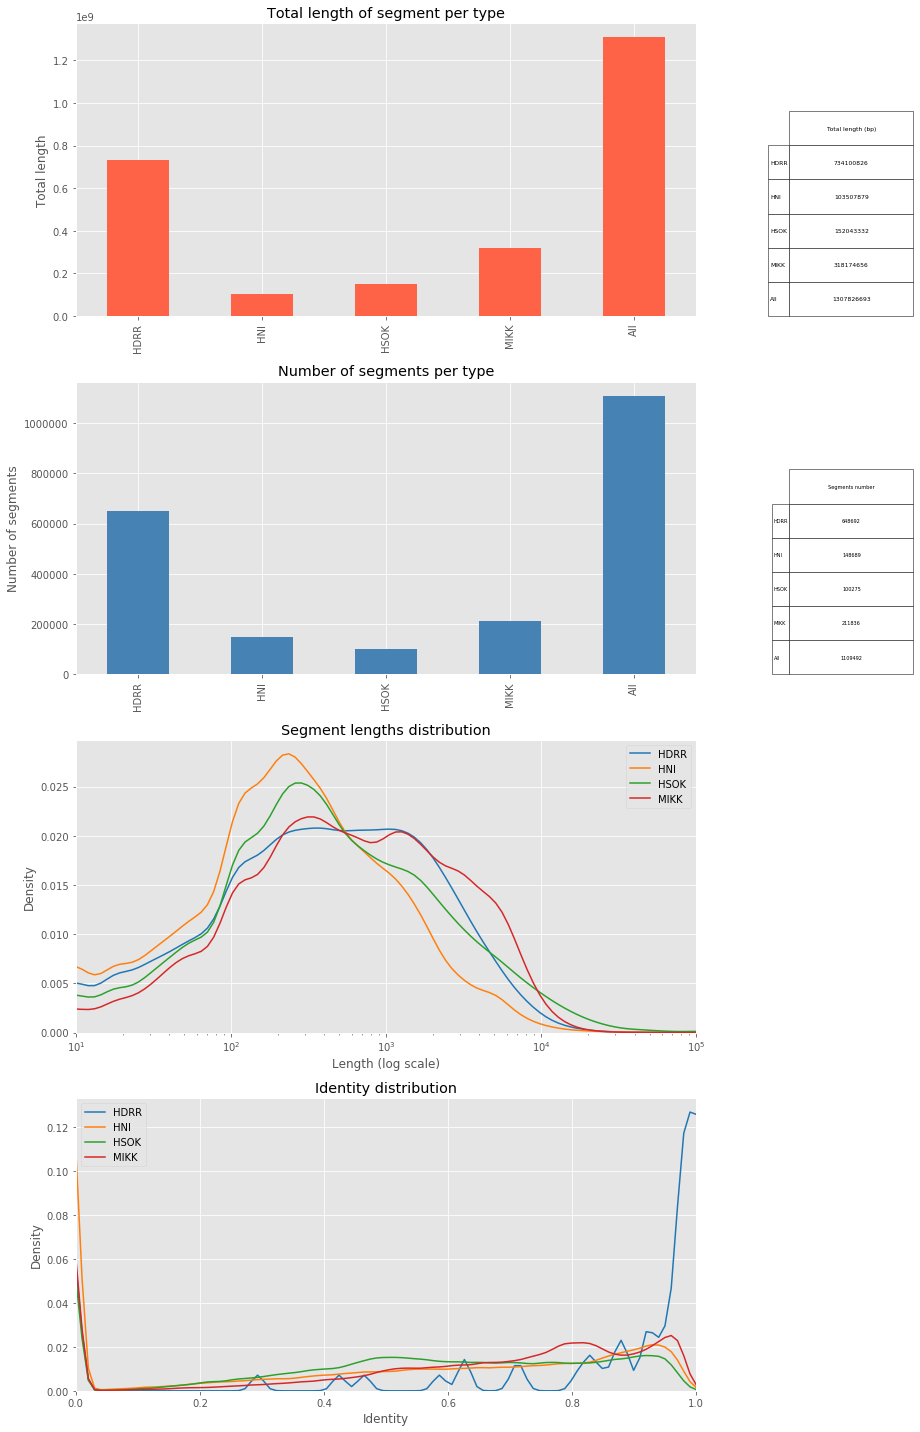

In [303]:
from pandas.plotting import table
from scipy.ndimage import gaussian_filter1d

def compute_N50 (data):
    data = data.dropna().values
    data.sort()
    half_sum = data.sum()/2
    cum_sum = 0
    for v in data:
        cum_sum += v
        if cum_sum >= half_sum:
            return int(v)

graph_info_fn="./graph_assembly/all_ref_graph_seg_info.pkl"
outdir="./graph_assembly/"

seg_type_info = defaultdict(OrderedDict)
seg_type_identity_list = OrderedDict()
seg_type_len_list = OrderedDict()

df = pd.read_pickle(graph_info_fn)
df = df[["length","type","identity"]]

# Aggregate unanchore contigs
df["type"] = df["type"].str.rstrip("+")

for seg_type, sdf in df.groupby("type"):
    seg_type_info[seg_type]["Total length (bp)"] = sdf["length"].sum()
    seg_type_info[seg_type]["Segments number"] = len(sdf)
    seg_type_info[seg_type]["Median segment length"] = sdf["length"].dropna().median()
    seg_type_info[seg_type]["longest segment"] = sdf["length"].dropna().max()
    seg_type_info[seg_type]["N50"] = compute_N50 (sdf["length"])
    seg_type_info[seg_type]["Median identity"] = sdf["identity"].dropna().median()

    seg_type_len_list[seg_type] = sdf["length"]
    seg_type_identity_list[seg_type] = sdf["identity"]

# Add all types together
seg_type_info["All"]["Total length (bp)"] = df["length"].sum()
seg_type_info["All"]["Segments number"] = len(df)
seg_type_info["All"]["Median segment length"] = df["length"].dropna().median()
seg_type_info["All"]["longest segment"] = df["length"].dropna().max()
seg_type_info["All"]["N50"] = compute_N50 (df["length"])
seg_type_info["All"]["Median identity"] = df["identity"].dropna().median()

# seg_type_len_list["All"] = df["length"]
# seg_type_identity_list["All"] = df["identity"]

seg_type_info_df = pd.DataFrame.from_dict(seg_type_info, orient="index")
out_fn = os.path.join(outdir, "segment_type_stats.tsv")
seg_type_info_df.to_csv(out_fn, sep="\t")
display(seg_type_info_df)

# Process data for plot
lower_pow = 1
upper_pow = 5
bins = list(np.logspace(lower_pow,upper_pow,100))
count_d=OrderedDict()
count_d["length bin"] = bins
for sample_id, sample_len_list in seg_type_len_list.items():
    count_d[sample_id] = np.histogram((sample_len_list), bins=bins+[pow(10,upper_pow+1)])[0]
seg_df= pd.DataFrame.from_dict(count_d)
seg_df = seg_df.set_index("length bin")
# normalise
seg_df = seg_df/seg_df.sum(axis=0)
for col in seg_df.columns:
    seg_df[col] = gaussian_filter1d (seg_df[col], sigma=2)
    
# Process data for plot
bins = list(np.linspace(0,1,100))
count_d=OrderedDict()
count_d["identity bin"] = bins
for sample_id, sample_len_list in seg_type_identity_list.items():
    count_d[sample_id] = np.histogram((sample_len_list), bins=bins+[1.1])[0]
id_df= pd.DataFrame.from_dict(count_d)
id_df = id_df.set_index("identity bin")
# normalise
id_df = id_df/id_df.sum(axis=0)
for col in id_df.columns:
    id_df[col] = gaussian_filter1d (id_df[col], sigma=1)   

with pl.style.context('ggplot'):
    fig, (ax1, ax2, ax3, ax4) = pl.subplots(4, 1, figsize=(10,20))

    seg_type_info_df["Total length (bp)"].plot.bar(ax=ax1, color="tomato", legend=False)
    table(ax1, seg_type_info_df["Total length (bp)"], colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax1.set_title('Total length of segment per type')
    ax1.set_ylabel("Total length")
    #ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    seg_type_info_df["Segments number"].plot.bar(ax=ax2, color="steelblue", legend=False)
    table(ax2, seg_type_info_df["Segments number"], colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax2.set_title('Number of segments per type')
    ax2.set_ylabel("Number of segments")
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    # Colors for types and All
    colors = sns.color_palette("tab10", 4)

    seg_df.plot(ax=ax3, color=colors)
    ax3.set_xscale("log")
    #ax3.set_yscale("log")
    ax3.set_xlabel("Length (log scale)")
    ax3.set_ylabel("Density")
    ax3.set_title("Segment lengths distribution")
    #ax3.set_xticks(np.logspace(lower_pow, upper_pow,upper_pow+1))
    ax3.set_xlim(pow(10,lower_pow),pow(10,upper_pow))
    ax3.set_ylim(0,None)

    id_df.plot(ax=ax4, color=colors)
    ax4.set_xlabel("Identity")
    ax4.set_ylabel("Density")
    ax4.set_title("Identity distribution")
    ax4.set_xlim(0,1)
    ax4.set_ylim(0,None)
    
    fig.tight_layout()
    out_fn = os.path.join(outdir, "segment_type_stats.svg")
    fig.savefig(out_fn)
    

## Extract stats from links

In [256]:
link_info_fn = "./graph_assembly/all_ref_graph_link_info.pkl"
df = pd.read_pickle(link_info_fn)
df.head()

,s1_chromosome,s1_pos,s2_chromosome,s2_pos,s2_type,connect_type,connect_gap,SV_type
link_id,,,,,,,,
s1+_s2+,HDRR_1,37816,HDRR_1,37816,HDRR,intra_HDRR,0.0,continuous
s2+_s3+,HDRR_1,37928,HDRR_1,37928,HDRR,intra_HDRR,0.0,continuous
s3+_s4+,HDRR_1,40172,HDRR_1,40172,HDRR,intra_HDRR,0.0,continuous
s4+_s5+,HDRR_1,41595,HDRR_1,41595,HDRR,intra_HDRR,0.0,continuous
s4-_s999575+,HDRR_1,40172,MIKK_117-2_C4_959,161190,MIKK,HDRR_MIKK,NaN,insertion


## Identity stats

Counts by category


,HDRR,HNI,HSOK,MIKK
Short low divergence,45.0,44305,35018,81069
Long low divergence,3.0,6935,8179,39013
Short high divergence,8.0,26900,14084,24517
Long high divergence,0.0,4184,9239,10457


% by category


,HDRR,HNI,HSOK,MIKK
Short low divergence,80.357143,53.817842,52.642814,52.283691
Long low divergence,5.357143,8.424032,12.295550,25.160587
Short high divergence,14.285714,32.675769,21.172580,15.811707
Long high divergence,0.000000,5.082358,13.889056,6.744015


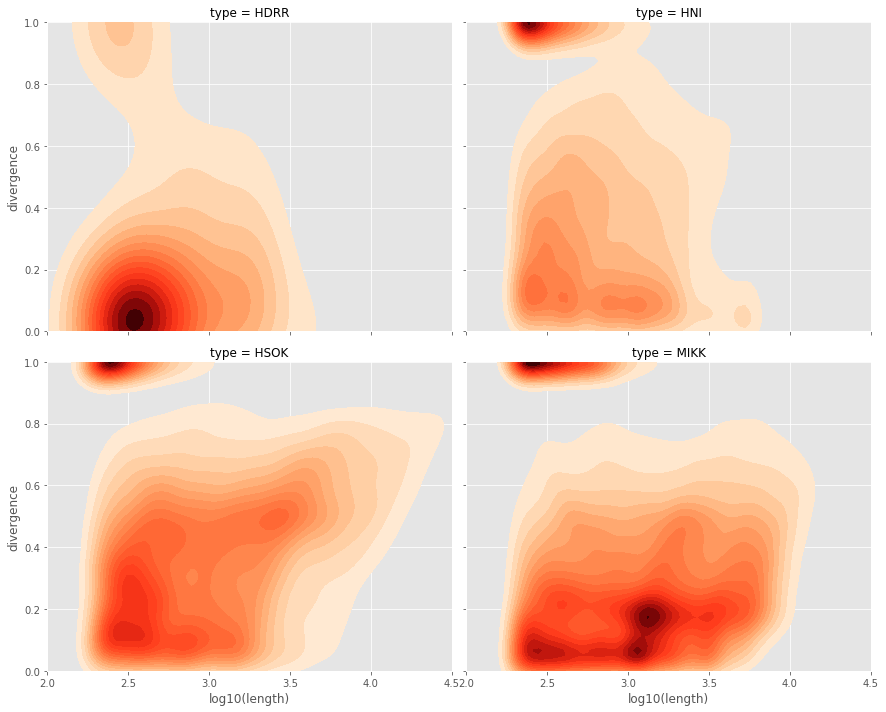

In [335]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
svg_out_fn =  "./graph_assembly/identity_len_stats.svg"
min_long = 2000
min_divergent = 0.5

graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df[["type", "length", "identity"]]
graph_info_df["type"] = graph_info_df["type"].str.rstrip("+")

graph_info_df = graph_info_df.dropna ()
#graph_info_df = graph_info_df.sample(20000) ###############################

graph_info_df["log10(length)"] = np.log10(graph_info_df["length"])
graph_info_df["divergence"] = 1-graph_info_df["identity"] 

d = defaultdict(Counter)
for line in graph_info_df.itertuples():
#     if line.divergence == 1:
#         d[line.type]["Fully divergent"] += 1
    if line.divergence >= min_divergent and line.length >= min_long:
        d[line.type]["Long high divergence"] += 1
    elif line.divergence >= min_divergent and line.length < min_long:
        d[line.type]["Short high divergence"] += 1
    elif line.divergence < min_divergent and line.length >= min_long:
        d[line.type]["Long low divergence"] += 1
    elif line.divergence < min_divergent and line.length < min_long:
        d[line.type]["Short low divergence"] += 1

print("Counts by category")
df = pd.DataFrame(d)
df = df.fillna(0)
display(df)

print("% by category")
df = df/df.sum(axis=0)*100
display(df)

with pl.style.context('ggplot'):
    cmap = sns.cubehelix_palette(start=0.9, rot=0.1, dark=0.01, light=0.99, hue=2.75, gamma=0.75, as_cmap=True)
    g = sns.FacetGrid(graph_info_df, col="type", col_wrap=2, height=5, aspect=1.25)
    g = g.map(sns.kdeplot, "log10(length)", "divergence", shade=True, shade_lowest=False, cmap=cmap, n_levels=20)
    
    for ax in g.axes:
        ax.set_ylim(0, 1)
        ax.set_xlim(2, 4.5)
        
    g.savefig(svg_out_fn)

## Get component stats

In [22]:
 def segment_type_stats (graph_info_fn, canonical_fa_fn, outdir):
    
    graph_info_df = pd.read_pickle(graph_info_fn)

    # Group segments by component
    components_dict = defaultdict(Component)
    for seg_id, seg_info in tqdm(zip(graph_info_df.index, graph_info_df.itertuples()), total=len(graph_info_df)):
        components_dict[seg_info.component].add(seg_id=seg_id, seg_info=seg_info)
    
    canonical_len_d = OrderedDict()
    with pyfaidx.Fasta(canonical_fa_fn) as fa:
        for seq in fa:
            canonical_len_d[seq.name] = len(seq)
    
    comp_len_d = OrderedDict()
    comp_ratio_d = OrderedDict()
    comp_num_d = OrderedDict()
    for i, j in components_dict.items():
        chrom = j.main_chromosome
        comp_len_d[chrom] = {"Canonical chromosomes":canonical_len_d[chrom], "Graph segments":j.length}
        comp_ratio_d[chrom] = j.length/canonical_len_d[chrom]
        comp_num_d[chrom]=len(j.segments)
        
    comp_len_df = pd.DataFrame.from_dict(comp_len_d, orient="index")
    comp_ratio_df = pd.DataFrame.from_dict(comp_ratio_d, orient="index", columns=["Ratio canonical/graph"])
    comp_num_df = pd.DataFrame.from_dict(comp_num_d, orient="index", columns=["Number of segments"])
    
    with pl.style.context('ggplot'):
        fig, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(20,15))

        comp_len_df.plot.bar(ax=ax1, color=("steelblue","tomato"), legend=True)
        table(ax1, comp_len_df, colWidths=[0.10]*2, colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,1))
        ax1.set_title('Length of canonical chromosomes')
        ax1.set_ylabel("Length")
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        
        comp_ratio_df.plot.bar(ax=ax2, color="tomato", legend=False)
        table(ax2, comp_ratio_df, colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,1))
        ax2.set_title('Ratio of Graph segment length by canonical chromosome length')
        ax2.set_ylabel("Length ratio")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

        comp_num_df.plot.bar(ax=ax3, color="steelblue", legend=False)
        table(ax3, comp_num_df, colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,1))
        ax3.set_title('Number of graph segments per chromosome')
        ax3.set_ylabel("Number of segments")
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        
        fig.tight_layout()
        out_fn = os.path.join(outdir, "component_stats.svg")
        fig.savefig(out_fn)
        
# Helper class to store component information
class Component():

    def __init__ (self):
        self.segments = list()
        self.chromosomes = Counter()
        self.length = 0
    
    def add (self, seg_id, seg_info):
        self.segments.append(seg_id)
        self.chromosomes[seg_info.chromosome]+=1
        self.length += seg_info.length
    
    def __repr__ (self):
        return f"Segments: {len(self.segments)}, chromomomes: {len(self.chromosomes)}, Length: {self.length}, Main chromosome: {self.main_chromosome}"
    
    @property
    def main_chromosome(self):
        return self.chromosomes.most_common(1)[0][0]

100%|██████████| 1109492/1109492 [00:07<00:00, 149790.83it/s]


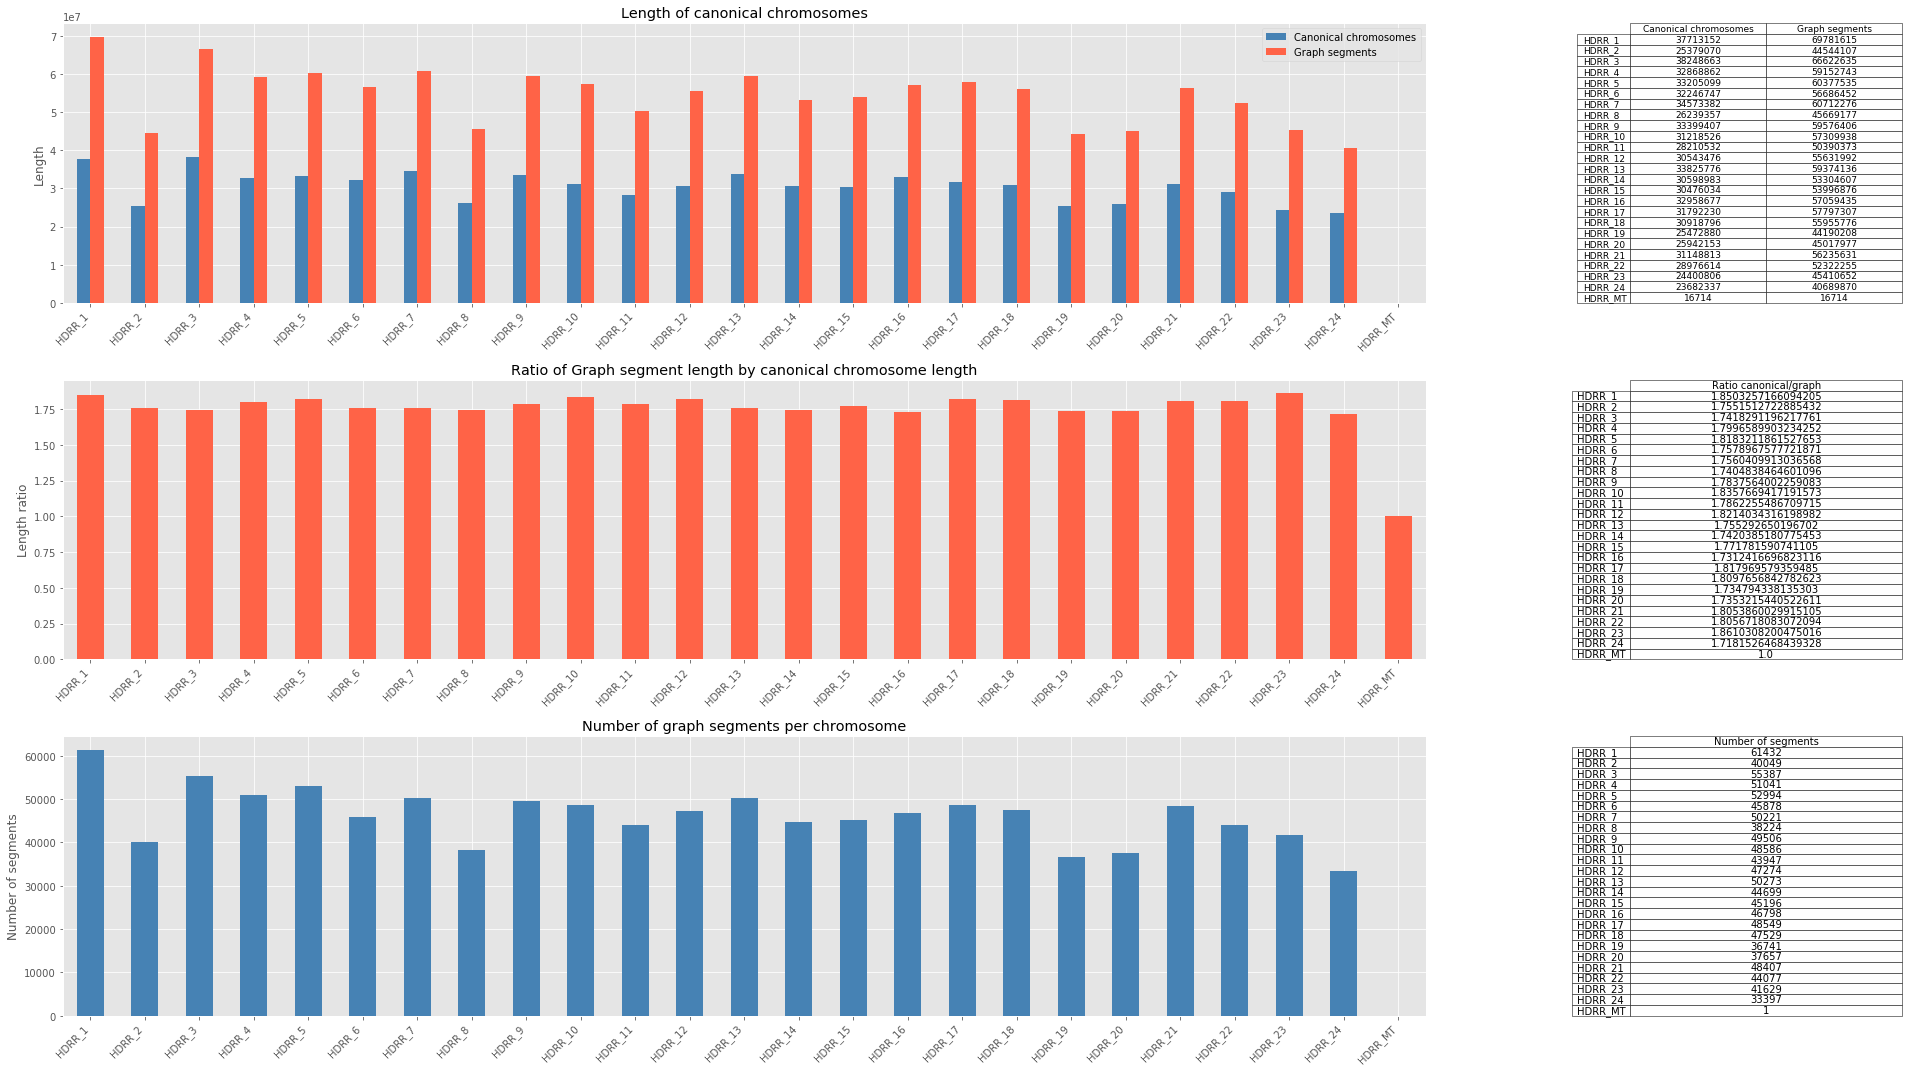

In [24]:
segment_type_stats("./graph_assembly/all_ref_graph_seg_info.pkl", "./references/Oryzias_latipes_HDRR_clean.fa", outdir="./graph_assembly/")

## Make graph info file for Bandage 

In [31]:
graph_info_fn = "./graph_assembly/all_ref_graph_info.pkl"
bandage_info_type = "./graph_assembly/all_ref_graph_type_bandage.csv"
bandage_info_identity = "./graph_assembly/all_ref_graph_identity_bandage.csv"
ref_type = "HDRR"

graph_info_df = pd.read_pickle(graph_info_fn) 
graph_info_df.index.name="Name"
graph_info_df = graph_info_df.drop(columns=["start", "end", "hit_start", "hit_end", "component", "connected_forward", "connected_reverse"])

#Define colormap
type_list = ['HDRR', 'HDRR+', 'HNI', 'HNI+', 'HSOK', 'HSOK+', 'MIKK']
type_color_dict = OrderedDict()
for col, lab in zip(sns.color_palette('tab20', len(type_list)), type_list):
    type_color_dict[lab] = rgb2hex(col)

#Define colormap
no_data_color = "#535353"
identity_thresholds = [0, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
identity_color_dict = OrderedDict()
for col, lab in zip(sns.color_palette('afmhot', len(identity_thresholds)), identity_thresholds):
    identity_color_dict[lab] = rgb2hex(col)
    
type_color_list = []
identity_color_list = []

for line in tqdm(graph_info_df.itertuples(), total=len(graph_info_df)):
    type_color_list.append(type_color_dict[line.type])
    if pd.isna(line.identity):
          identity_color_list.append(no_data_color)
    else:
        for threshold, color in identity_color_dict.items():
            if line.identity<=threshold:
                identity_color_list.append(color)
                break

graph_info_type_df = graph_info_df.copy()
graph_info_type_df["Color"] = type_color_list
graph_info_type_df.to_csv(bandage_info_type, sep=",")
display(graph_info_type_df.sample(5))

graph_info_identity_df = graph_info_df.copy()
graph_info_identity_df["Color"] = identity_color_list
graph_info_identity_df.to_csv(bandage_info_identity, sep=",")
display(graph_info_identity_df.sample(5))

100%|██████████| 1109492/1109492 [00:02<00:00, 448054.18it/s]


,chromosome,length,type,identity,hit_chromosome,Color
Name,,,,,,
s1059479,MIKK_79-2_G3_275,201,MIKK,NaN,None,#d62728
s275553,HDRR_10,1660,HDRR,NaN,None,#1f77b4
s947382,MIKK_69-1_F3_989,1132,MIKK,0.936752,HDRR_13,#d62728
s76794,HDRR_3,255,HDRR,NaN,None,#1f77b4
s105291,HDRR_4,29,HDRR,NaN,None,#1f77b4


,chromosome,length,type,identity,hit_chromosome,Color
Name,,,,,,
s38779,HDRR_2,118,HDRR,NaN,None,#535353
s203698,HDRR_7,58,HDRR,NaN,None,#535353
s416004,HDRR_15,1431,HDRR,NaN,None,#535353
s830100,HSOK_8,3926,HSOK,0.89781,HDRR_9,#ffe667
s645664,HDRR_24,226,HDRR,NaN,None,#535353


## Make all segment bed track for IGV

In [98]:
graph_info_fn = "./graph_assembly/all_ref_graph_info.pkl"
bed_out = "./graph_assembly/all_ref_graph_segments.bed"
bed_out_sorted = "./graph_assembly/all_ref_graph_segments_sorted.bed"

graph_info_df = pd.read_pickle(graph_info_fn) 
graph_info_df = graph_info_df.reset_index()
graph_info_df = graph_info_df[["chromosome", "start", "end", "seg_id"]]
graph_info_df.to_csv(bed_out, sep="\t", index=False, header=False)

print(f"Sort and index with igvtools")
bash (f"igvtools sort {bed_out} {bed_out_sorted}", conda="IGV")
bash (f"igvtools index {bed_out_sorted}", conda="IGV")

# Remove originals
os.remove(bed_out)

Sort and index with igvtools
Using system JDK.
WARN [2020-07-08T10:34:01,104]  [Globals.java:138] [main]  Development mode is enabled
Sorting ./graph_assembly2/all_ref_graph_segments.bed  -> ./graph_assembly2/all_ref_graph_segments_sorted.bed
Done
Using system JDK.
WARN [2020-07-08T10:35:15,988]  [Globals.java:138] [main]  Development mode is enabled
Done


# Align to graph

In [ ]:
outdir = "alignments2"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

## Align raw reads to graph

In [10]:
outdir = "alignments2/raw_reads"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

wait_jobid = "3595722"
dry=False
graph = "./graph_assembly/all_ref_graph.gfa"

for fasta in glob.glob("/hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/*.fastq"):
    sample_id = os.path.basename(fasta).split(".")[0]
    print (f"Aligning sample {sample_id}")
    
    # Normal mode
    gaf = f"{outdir}/{sample_id}_stable.gaf"
    stdout = f"{outdir}/{sample_id}_stable.out"
    stderr = f"{outdir}/{sample_id}_stable.err"
    bsub(f"minigraph -x lr -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)
    
    # Unstable ref mapping mode
    gaf = f"{outdir}/{sample_id}_unstable.gaf"
    stdout = f"{outdir}/{sample_id}_unstable.out"
    stderr = f"{outdir}/{sample_id}_unstable.err"
    bsub(f"minigraph -x lr --vc -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

#     # Graph usage mode
#     gfa = f"{outdir}/{sample_id}_graph.gfa"
#     stdout = f"{outdir}/{sample_id}_graph.out"
#     stderr = f"{outdir}/{sample_id}_graph.err"
#     bsub(f"minigraph -x lr -t 10 --cov {graph} {fasta} -o {gfa}", conda="minigraph", dry=False, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/alignments2/raw_reads
Aligning sample 4-2_B2
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/4-2_B2_stable.out -eo alignments2/raw_reads/4-2_B2_stable.err -w 'post_done(3595722)'  "minigraph -x lr -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/4-2_B2.fastq -o alignments2/raw_reads/4-2_B2_stable.gaf"
Job <3768120> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/4-2_B2_unstable.out -eo alignments2/raw_reads/4-2_B2_unstable.err -w 'post_done(3595722)'  "minigraph -x lr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/4-2_B2.fastq -o alignments2/raw_reads/4-2_B2_unstable.gaf"
Job <3768121> 

Job <3768148> is submitted to default queue <research-rh74>.
Aligning sample 131-1_F4
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/131-1_F4_stable.out -eo alignments2/raw_reads/131-1_F4_stable.err -w 'post_done(3595722)'  "minigraph -x lr -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/131-1_F4.fastq -o alignments2/raw_reads/131-1_F4_stable.gaf"
Job <3768149> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/131-1_F4_unstable.out -eo alignments2/raw_reads/131-1_F4_unstable.err -w 'post_done(3595722)'  "minigraph -x lr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/131-1_F4.fastq -o alignments2/raw_reads/131-1_F4_unstable.gaf"
Job <3768152> is submitted to default queue <r

In [19]:
bjobs(cmd="minigraph -x lr.*")

,jobid,user,status,queue,cmd,cpu_used,mem,swap,submit_time,start_time


## Align individual assembly to graph

In [13]:
outdir = "alignments2/assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

wait_jobid = "3595722"
dry=False
graph = "./graph_assembly/all_ref_graph.gfa"

for fasta in glob.glob("./individual_assemblies/*_clean.fa"):
    sample_id = os.path.basename(fasta).split(".")[0].rstrip("_clean")
    print (f"Aligning sample {sample_id}")
    
    # Normal mode
    gaf = f"{outdir}/{sample_id}_stable.gaf"
    stdout = f"{outdir}/{sample_id}_stable.out"
    stderr = f"{outdir}/{sample_id}_stable.err"
    bsub(f"minigraph -x asm -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)
    
    # Unstable ref mapping mode
    gaf = f"{outdir}/{sample_id}_unstable.gaf"
    stdout = f"{outdir}/{sample_id}_unstable.out"
    stderr = f"{outdir}/{sample_id}_unstable.err"
    bsub(f"minigraph -x asm --vc -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)
    
#     # Graph usage mode
#     gfa = f"{outdir}/{sample_id}_graph.gfa"
#     stdout = f"{outdir}/{sample_id}_graph.out"
#     stderr = f"{outdir}/{sample_id}_graph.err"
#     bsub(f"minigraph -x asm -t 10 --cov {graph} {fasta} -o {gfa}", conda="minigraph", dry=False, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/alignments2/assemblies
Aligning sample 69-1_F3
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/69-1_F3_stable.out -eo alignments2/assemblies/69-1_F3_stable.err -w 'post_done(3595722)'  "minigraph -x asm -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/69-1_F3_clean.fa -o alignments2/assemblies/69-1_F3_stable.gaf"
Job <3768182> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/69-1_F3_unstable.out -eo alignments2/assemblies/69-1_F3_unstable.err -w 'post_done(3595722)'  "minigraph -x asm --vc -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/69-1_F3_clean.fa -o alignments2/assemblies/69-1_F3_unstable.gaf"
Job <3768183> is submitted to default queue <research-rh74>.
Aligning sample 131-1_F4
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/131-1_F4_stable.out -e

Job <3768211> is submitted to default queue <research-rh74>.
Aligning sample 11-1_A3
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/11-1_A3_stable.out -eo alignments2/assemblies/11-1_A3_stable.err -w 'post_done(3595722)'  "minigraph -x asm -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/11-1_A3_clean.fa -o alignments2/assemblies/11-1_A3_stable.gaf"
Job <3768212> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/11-1_A3_unstable.out -eo alignments2/assemblies/11-1_A3_unstable.err -w 'post_done(3595722)'  "minigraph -x asm --vc -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/11-1_A3_clean.fa -o alignments2/assemblies/11-1_A3_unstable.gaf"
Job <3768213> is submitted to default queue <research-rh74>.


In [20]:
bjobs(cmd="minigraph -x asm.*")

,jobid,user,status,queue,cmd,cpu_used,mem,swap,submit_time,start_time


## Align Illumina RNA-Seq datasets to graph

In [14]:
outdir = "alignments2/rna_seq"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

wait_jobid = "3595722"
dry=False
graph = "./graph_assembly/all_ref_graph.gfa"

for fasta in glob.glob("rna_seq_data/*_merged.extendedFrags.fastq.gz"):
    sample_id = os.path.basename(fasta).split("_")[0]
    print (f"Aligning sample {sample_id}")
    
    # Normal mode
    gaf = f"{outdir}/{sample_id}_stable.gaf"
    stdout = f"{outdir}/{sample_id}_stable.out"
    stderr = f"{outdir}/{sample_id}_stable.err"
    bsub(f"minigraph -x sr -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=15000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

    # Unstable ref mapping mode
    gaf = f"{outdir}/{sample_id}_unstable.gaf"
    stdout = f"{outdir}/{sample_id}_unstable.out"
    stderr = f"{outdir}/{sample_id}_unstable.err"
    bsub(f"minigraph -x sr --vc -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=15000, threads=10, stdout_fp=stdout, stderr_fp=stderr)
    
#     # Graph usage mode
#     gfa = f"{outdir}/{sample_id}_graph.gfa"
#     stdout = f"{outdir}/{sample_id}_graph.out"
#     stderr = f"{outdir}/{sample_id}_graph.err"
#     bsub(f"minigraph -x sr -t 10 --cov {graph} {fasta} -o {gfa}", conda="minigraph", dry=False, mem=15000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/alignments2/rna_seq
Aligning sample 95-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/95-1_stable.out -eo alignments2/rna_seq/95-1_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/95-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/95-1_stable.gaf"
Job <3768234> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/95-1_unstable.out -eo alignments2/rna_seq/95-1_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/95-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/95-1_unstable.gaf"
Job <3768235> is submitted to default queue <research-rh74>.
Aligning sample 94-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/94-1_stable.out -eo alignments2/rna_seq/94-1_stable.err -w 

Job <3768261> is submitted to default queue <research-rh74>.
Aligning sample 61-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/61-1_stable.out -eo alignments2/rna_seq/61-1_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/61-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/61-1_stable.gaf"
Job <3768262> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/61-1_unstable.out -eo alignments2/rna_seq/61-1_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/61-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/61-1_unstable.gaf"
Job <3768263> is submitted to default queue <research-rh74>.
Aligning sample 59-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/59-2_stable.out -eo alignments2/rna_seq/59-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./g

Aligning sample 32-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/32-2_stable.out -eo alignments2/rna_seq/32-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/32-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/32-2_stable.gaf"
Job <3768284> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/32-2_unstable.out -eo alignments2/rna_seq/32-2_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/32-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/32-2_unstable.gaf"
Job <3768286> is submitted to default queue <research-rh74>.
Aligning sample 30-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/30-1_stable.out -eo alignments2/rna_seq/30-1_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/30-1_merged.ext

Aligning sample 13-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/13-2_stable.out -eo alignments2/rna_seq/13-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/13-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/13-2_stable.gaf"
Job <3768313> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/13-2_unstable.out -eo alignments2/rna_seq/13-2_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/13-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/13-2_unstable.gaf"
Job <3768315> is submitted to default queue <research-rh74>.
Aligning sample 139-4
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/139-4_stable.out -eo alignments2/rna_seq/139-4_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/139-4_merged

Job <3768339> is submitted to default queue <research-rh74>.
Aligning sample 11-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/11-2_stable.out -eo alignments2/rna_seq/11-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/11-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/11-2_stable.gaf"
Job <3768340> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/11-2_unstable.out -eo alignments2/rna_seq/11-2_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/11-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/11-2_unstable.gaf"
Job <3768341> is submitted to default queue <research-rh74>.
Aligning sample 117-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/117-2_stable.out -eo alignments2/rna_seq/117-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 

In [21]:
display(bjobs(cmd="minigraph -x sr.*"))

,jobid,user,status,queue,cmd,cpu_used,mem,swap,submit_time,start_time


In [23]:
    ll alignments2/

total 17657310
-rw-r--r-- 1 aleg       2269 Jul  3 04:50 11-1_A3_stable.err
-rw-r--r-- 1 aleg  523789232 Jul  3 04:50 11-1_A3_stable.gaf
-rw-r--r-- 1 aleg       2080 Jul  3 04:50 11-1_A3_stable.out
-rw-r--r-- 1 aleg       2276 Jul  3 04:37 11-1_A3_unstable.err
-rw-r--r-- 1 aleg  502831242 Jul  3 04:37 11-1_A3_unstable.gaf
-rw-r--r-- 1 aleg       2096 Jul  3 04:37 11-1_A3_unstable.out
-rw-r--r-- 1 aleg       3297 Jul  3 07:00 117-2_C4_stable.err
-rw-r--r-- 1 aleg  851650875 Jul  3 07:00 117-2_C4_stable.gaf
-rw-r--r-- 1 aleg       2087 Jul  3 07:00 117-2_C4_stable.out
-rw-r--r-- 1 aleg       3296 Jul  3 06:33 117-2_C4_unstable.err
-rw-r--r-- 1 aleg  819211569 Jul  3 06:33 117-2_C4_unstable.gaf
-rw-r--r-- 1 aleg       2105 Jul  3 06:33 117-2_C4_unstable.out
-rw-r--r-- 1 aleg       3827 Jul  3 07:08 131-1_F4_stable.err
-rw-r--r-- 1 aleg 1071198155 Jul  3 07:08 131-1_F4_stable.gaf
-rw-r--r-- 1 aleg       2087 Jul  3 07:08 131-1_F4_stable.out
-rw-r--r-- 1 aleg       3837 Jul  3 07:28 131-1_F

# Explore alignments

## Define parsing functions

In [15]:
def parse_gaf (gaf_fn, ):
    with open (gaf_fn) as gaf_fp:
        for line in gaf_fp:
            line = line.split("\t")
            d = OrderedDict(
                qname = line[0],
                qlen = int(line[1]),
                qstart = int(line[2]),
                qend = int(line[3]),
                align_path = decompose_path(path=line[5], start=int(line[7]), end=int(line[8]), strand=line[4]),
                matches = int(line[9]),
                align_len = int(line[10]),
                mapq = int(line[11]),
                align_type = line[12].split(":")[-1],
                num_minimizers = int(line[13].split(":")[-1]),
                chaining_score = int(line[14].split(":")[-1]))
            yield d

def decompose_path (path, start, end, strand):
    l = []
    
    if not ":"in path:
        l.append(OrderedDict(contig=path, orient=strand, start=start, end=end, length=abs(start-end)))
    else:
        s = ""
        for c in path:
            if s and c in ["<", ">"]:
                l.append(to_dict(s))
                s = c
            else:
                s+=c
        l.append(to_dict(s))
    return l
    
def to_dict (node):
    contig = node[1:].split(":")[0]
    orient = "+" if node[0] == ">" else "-"
    start = int(node.split(":")[1].split("-")[0])
    end = int(node.split(":")[1].split("-")[1])
    length = abs(start-end)
    return OrderedDict(contig=contig, orient=orient, start=start, end=end, length=length)

## Explore alignments from individual assemblies

In [27]:
stdout_print("Import contig lengths in a dictionary\n")
contig_dict = defaultdict(Counter)

with open ("./graph_assembly/min_var_100_contig_len.tsv") as fp:
    _ = next(fp)
    for line in fp:
        contig, length = line.split()
        contig_dict[contig]["length"]=length
contig_dict
        
stdout_print("Parsing gaf files\n")
for gaf in glob.glob("./alignments/assemblies/*.gaf"):
    sample_id = gaf.split("/")[-1].split(".")[0]
    stdout_print(f"\tParsing data for sample {sample_id}\n")
    for line in parse_gaf(gaf):
        if line["align_type"]=="P" and line["mapq"]>=10:
            for sp in line["align_path"]:
                contig_dict[sp["contig"]][sample_id]+=sp["length"]

stdout_print("Save results to file\n")
df = pd.DataFrame.from_dict(contig_dict, orient="index")
df.index.name ="contig"
df = df.fillna(0)
df = df.astype(int)
df.to_csv("./alignments/assemblies/bases_mapped_contig.tsv", sep="\t")
display(df)

# normalise size
for col in df.columns[1:]:
    df[col] = df[col]/df["length"]
df = df.drop(columns=["length"])
df.to_csv("./alignments/assemblies/norm_bases_mapped_contig.tsv", sep="\t")
display(df)

Import contig lengths in a dictionary
Parsing gaf files
	Parsing data for sample 134-1_H4_reads
	Parsing data for sample 7-1_E2_reads
	Parsing data for sample 79-2_G3_reads
	Parsing data for sample 134-2_A5_reads
	Parsing data for sample 4-1_B2_reads
	Parsing data for sample 80-1_H3_reads
	Parsing data for sample 7-2_F2_reads
	Parsing data for sample 11-1_A3_reads
	Parsing data for sample 4-2_B2_reads
	Parsing data for sample 117-2_C4_reads
	Parsing data for sample 131-1_F4_reads
	Parsing data for sample 69-1_F3_reads
Save results to file


,length,134-1_H4_reads,7-1_E2_reads,79-2_G3_reads,134-2_A5_reads,4-1_B2_reads,80-1_H3_reads,7-2_F2_reads,11-1_A3_reads,4-2_B2_reads,117-2_C4_reads,131-1_F4_reads,69-1_F3_reads
contig,,,,,,,,,,,,,
1,37713152,35341919,5142618,35053558,35512771,34918049,6892897,35106443,2922294,35251176,34473164,34005180,36079075
2,25379070,24653036,2717285,24125137,25312288,24840375,5880645,24928780,0,24527639,25587151,25426833,24382271
3,38248663,35692371,10157005,34889996,35260237,35904618,13531061,35321281,5843914,35198951,35315121,34520385,35310068
4,32868862,31167536,0,30419416,31420576,30703649,11445283,31156374,1979679,30901136,31190792,28800668,31070953
5,33205099,30706321,2288,30579182,31125040,30391733,8568102,30637442,2091157,30532277,30580857,30620368,30511285
6,32246747,30028295,1644755,29715048,30403078,29521205,9091943,29654654,1821627,29681109,29634570,29546040,29787183
7,34573382,31687358,3922849,31382240,31984446,31479192,14090196,31744753,5258380,31552219,31634862,31607964,31999392
8,26239357,24249970,0,23888373,24045938,23674433,10049695,23840398,0,24543759,24145909,23547227,23753203
9,33399407,30398308,0,30231550,30188778,30522704,10262109,30238405,5062097,30483554,30604127,30561411,30715258


,134-1_H4_reads,7-1_E2_reads,79-2_G3_reads,134-2_A5_reads,4-1_B2_reads,80-1_H3_reads,7-2_F2_reads,11-1_A3_reads,4-2_B2_reads,117-2_C4_reads,131-1_F4_reads,69-1_F3_reads
contig,,,,,,,,,,,,
1,0.937125,0.136361,0.929478,0.941655,0.925885,0.182772,0.930881,0.077487,0.934718,0.914089,0.901680,0.956671
2,0.971392,0.107068,0.950592,0.997369,0.978774,0.231712,0.982257,0.000000,0.966451,1.008199,1.001882,0.960724
3,0.933167,0.265552,0.912189,0.921868,0.938716,0.353766,0.923464,0.152787,0.920266,0.923303,0.902525,0.923171
4,0.948239,0.000000,0.925478,0.955937,0.934126,0.348211,0.947899,0.060230,0.940134,0.948947,0.876230,0.945301
5,0.924747,0.000069,0.920918,0.937357,0.915273,0.258036,0.922673,0.062977,0.919506,0.920969,0.922159,0.918873
6,0.931204,0.051005,0.921490,0.942826,0.915479,0.281949,0.919617,0.056490,0.920437,0.918994,0.916249,0.923727
7,0.916525,0.113464,0.907699,0.925118,0.910504,0.407545,0.918185,0.152093,0.912616,0.915006,0.914228,0.925550
8,0.924183,0.000000,0.910402,0.916407,0.902249,0.383001,0.908574,0.000000,0.935380,0.920217,0.897401,0.905251
9,0.910145,0.000000,0.905152,0.903872,0.913870,0.307254,0.905358,0.151562,0.912697,0.916307,0.915029,0.919635


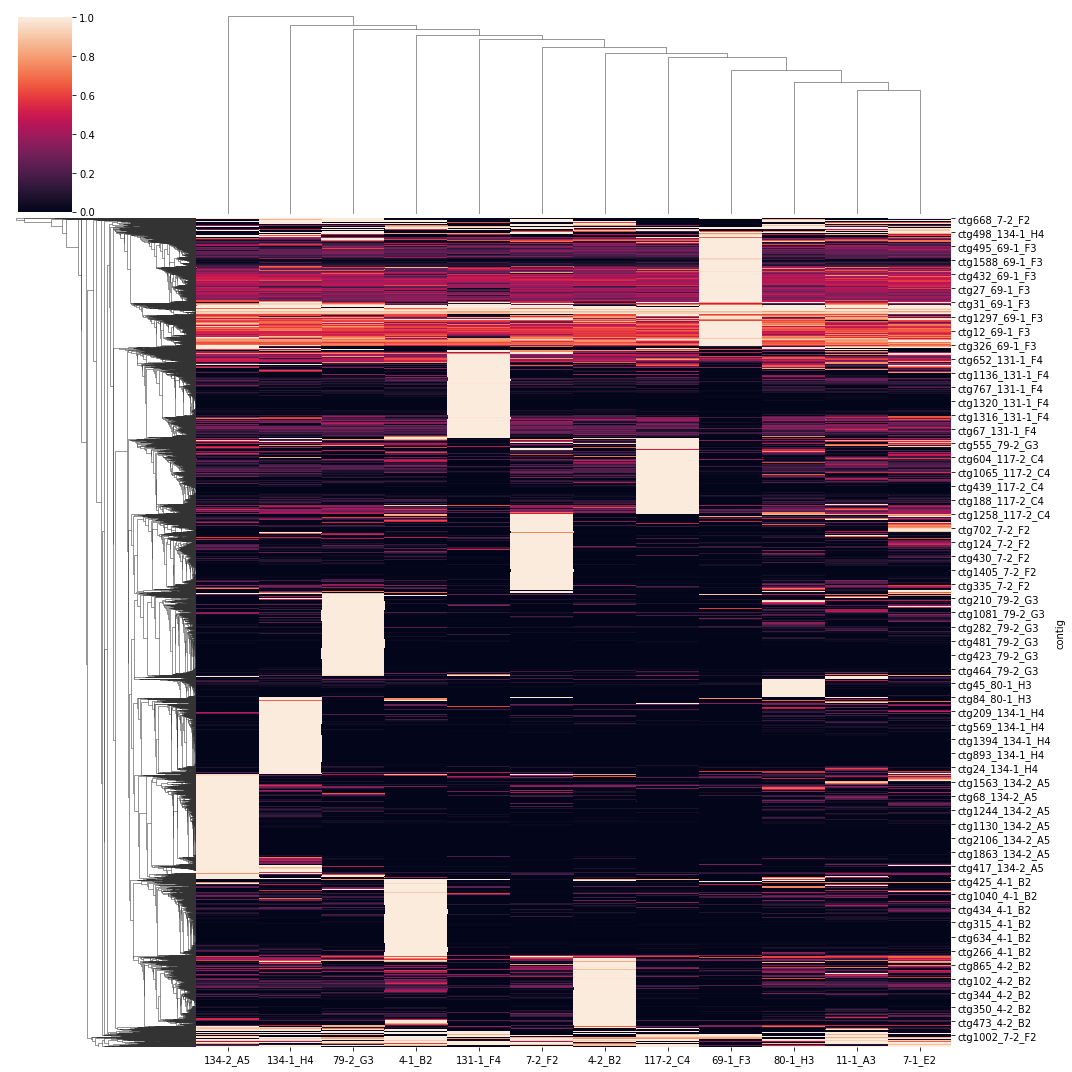

In [309]:
df = pd.read_csv("./graph_align_assemblies/norm_bases_mapped_contig.tsv", sep="\t", index_col=0)
filt_df = df[(df>=0.75).sum(axis=1)>=1]

_ = sns.clustermap(filt_df, figsize=(15, 15), robust=True)

## Explore alignments from raw reads

In [267]:
l = []
for i in tqdm(parse_gaf("graph_align_raw_reads/11-1_A3.gaf")):
    if i["align_type"]=="P" and i["mapq"]>=30:
        l.append(i)

pd.DataFrame(l)

3164325it [01:18, 40122.35it/s]


,qname,qlen,qstart,qend,align_path,matches,align_len,mapq,align_type,num_minimizers,chaining_score
0,8b5e9b79-b951-4103-a235-2b09846004e5,5101,125,4923,"[{'contig': '10', 'orient': '+', 'start': 12711333, 'end': 12716518, 'length': 5185}]",707,5192,60,P,64,476
1,77edc0b7-b248-44b2-83e9-b7d1823a8b3b,8333,1143,7484,"[{'contig': '11', 'orient': '-', 'start': 8193293, 'end': 8200089, 'length': 6796}]",1582,6812,44,P,166,1289
2,77edc0b7-b248-44b2-83e9-b7d1823a8b3b,8333,431,897,"[{'contig': '24', 'orient': '-', 'start': 22432082, 'end': 22432576, 'length': 494}]",168,496,60,P,21,149
3,77edc0b7-b248-44b2-83e9-b7d1823a8b3b,8333,7685,8077,"[{'contig': '24', 'orient': '-', 'start': 22431581, 'end': 22431994, 'length': 413}]",109,413,60,P,11,90
4,77ac7796-b4c5-4561-bff3-a24c7944a581,3233,15,1412,"[{'contig': '17', 'orient': '+', 'start': 10177457, 'end': 10178929, 'length': 1472}]",128,1473,56,P,11,82
5,6901d7af-8f4d-4a62-8c64-658235b746e2,2788,136,1760,"[{'contig': '13', 'orient': '+', 'start': 10901878, 'end': 10903594, 'length': 1716}]",144,1718,58,P,13,88
6,98430599-ac3e-4add-8cd1-37c3f4c28897,8808,9,8348,"[(-, ctg479_69-1_F3, 393001, 394412, 1411), {'contig': '8', 'orient': '+', 'start': 14262505, 'end': 14271400, 'length': 8895}]",1880,9039,60,P,212,1368
7,5a5d2da2-42e6-4780-bc2b-eb22d10933fc,2438,300,1836,"[{'contig': '24', 'orient': '+', 'start': 681240, 'end': 682827, 'length': 1587}]",275,1594,60,P,28,226
8,e2a5e43b-6146-4773-8c18-0a653b3ee8ea,6001,361,5772,"[(+, ctg23_69-1_F3, 663753, 664865, 1112), (-, 5, 21626798, 21630645, 3847), {'contig': '5', 'orient': '-', 'start': 21611666, 'end': 21621806, 'length': 10140}]",1064,5644,60,P,111,828
9,6d624c6a-6cb2-4260-9d76-452e3495e8db,1867,18,1747,"[{'contig': '13', 'orient': '+', 'start': 921040, 'end': 922866, 'length': 1826}]",545,1834,60,P,65,476


In [29]:
stdout_print("Import contig lengths in a dictionary\n")
contig_dict = defaultdict(Counter)
with open ("./graph_assembly/min_var_100_contig_len.tsv") as fp:
    _ = next(fp)
    for line in fp:
        contig, length = line.split()
        contig_dict[contig]["length"]=length
contig_dict
        

stdout_print("Parsing gaf files\n")
for gaf in glob.glob("./alignments/raw_reads/*.gaf"):
    sample_id = gaf.split("/")[-1].split(".")[0]
    stdout_print(f"\tParsing data for sample {sample_id}\n")
    for line in parse_gaf(gaf):
        if line["align_type"]=="P" and line["mapq"]>=10:
            for sp in line["align_path"]:
                contig_dict[sp["contig"]][sample_id]+=sp["length"]

stdout_print("Save results to file\n")
df = pd.DataFrame.from_dict(contig_dict, orient="index")
df.index.name ="contig"
df = df.fillna(0)
df = df.astype(int)
df.to_csv("./alignments/raw_reads/bases_mapped_contig.tsv", sep="\t")
display(df)

# normalise size
for col in df.columns[1:]:
    df[col] = df[col]/df["length"]
df = df.drop(columns=["length"])
df.to_csv("./alignments/raw_reads/norm_bases_mapped_contig.tsv", sep="\t")
display(df)

Import contig lengths in a dictionary
Parsing gaf files
	Parsing data for sample 80-1_H3_reads
	Parsing data for sample 134-2_A5_reads
	Parsing data for sample 131-1_F4_reads
	Parsing data for sample 4-1_B2_reads
	Parsing data for sample 7-2_F2_reads
	Parsing data for sample 7-1_E2_reads
	Parsing data for sample 69-1_F3_reads
	Parsing data for sample 79-2_G3_reads
	Parsing data for sample 134-1_H4_reads
	Parsing data for sample 117-2_C4_reads
	Parsing data for sample 11-1_A3_reads
	Parsing data for sample 4-2_B2_reads
Save results to file


,length,80-1_H3_reads,134-2_A5_reads,131-1_F4_reads,4-1_B2_reads,7-2_F2_reads,7-1_E2_reads,69-1_F3_reads,79-2_G3_reads,134-1_H4_reads,117-2_C4_reads,11-1_A3_reads,4-2_B2_reads
contig,,,,,,,,,,,,,
1,37713152,794450980,1877592798,1697551583,1212570903,1241845533,1160284050,1066454853,1169837289,1160615166,1412474435,871446445,1408288371
2,25379070,553969396,1389510672,1232058228,855240424,923373497,809930555,855277913,935951492,851438197,1074921693,664607539,1044307841
3,38248663,865370097,2003219750,1799291686,1264729246,1372124115,1250516297,1144506224,1278060661,1250233987,1520177201,946423007,1522775463
4,32868862,679726398,1555238682,1430599218,990152824,1061371183,964434092,897854152,1001740027,976167376,1210890927,729624662,1180513009
5,33205099,769287995,1798989070,1654236886,1130637220,1223187967,1112765588,1023621521,1148809079,1111385949,1372768206,839605347,1356312361
6,32246747,741443884,1727933024,1604096834,1099048586,1183114302,1064217604,993734414,1110655963,1072602306,1334928365,810110929,1321048902
7,34573382,792175970,1829110157,1697611606,1154596661,1250379237,1156764823,1060195131,1181684872,1143177725,1418402050,870959299,1457619245
8,26239357,590925567,1352884356,1274978009,865320784,931444045,830866854,785596203,877772031,852226593,1060651622,653392528,1026114070
9,33399407,787512605,1814583441,1769082252,1131898007,1236513998,1110609355,1076259479,1186912489,1143952073,1377216059,848659771,1486022887


,80-1_H3_reads,134-2_A5_reads,131-1_F4_reads,4-1_B2_reads,7-2_F2_reads,7-1_E2_reads,69-1_F3_reads,79-2_G3_reads,134-1_H4_reads,117-2_C4_reads,11-1_A3_reads,4-2_B2_reads
contig,,,,,,,,,,,,
1,21.065621,49.786154,45.012191,32.152468,32.928712,30.766032,28.278062,31.019345,30.774812,37.453100,23.107229,37.342102
2,21.827805,54.750260,48.546232,33.698651,36.383268,31.913327,33.700128,36.878873,33.548834,42.354653,26.187230,41.148389
3,22.624846,52.373589,47.041950,33.065973,35.873780,32.694379,29.922777,33.414519,32.686998,39.744584,24.743950,39.812515
4,20.679949,47.316475,43.524452,30.124342,32.291084,29.341877,27.316253,30.476870,29.698849,36.840062,22.198051,35.915847
5,23.167767,54.178097,49.818761,34.050108,36.837353,33.511889,30.827239,34.597369,33.470340,41.342090,25.285434,40.846509
6,22.992827,53.584724,49.744454,34.082464,36.689416,33.002324,30.816579,34.442419,33.262341,41.397303,25.122253,40.966889
7,22.912886,52.905156,49.101693,33.395537,36.165951,33.458249,30.665069,34.179036,33.065256,41.025840,25.191614,42.160158
8,22.520581,51.559356,48.590292,32.977972,35.497975,31.664909,29.939613,33.452498,32.478943,40.422165,24.901240,39.105915
9,23.578640,54.329810,52.967475,33.889764,37.022034,33.252367,32.223910,35.536933,34.250670,41.234746,25.409426,44.492493


In [320]:
df = pd.read_csv("./graph_align_raw_reads/bases_mapped_contig.tsv", sep="\t", index_col=0)
for col in df.columns[1:]:
    df[col] = df[col]/df[col].sum()/(df["length"]/df["length"].sum())

df

,length,80-1_H3,134-2_A5,131-1_F4,7-1_E2,7-2_F2,4-1_B2,69-1_F3,79-2_G3,134-1_H4,117-2_C4,11-1_A3,4-2_B2
contig,,,,,,,,,,,,,
3,38248663,1.286348,1.278214,1.195504,1.293201,1.288115,1.277098,1.268965,1.264730,1.285852,1.259447,1.290889,1.266415
1,37713152,1.200291,1.211040,1.150166,1.228151,1.187207,1.237496,1.193620,1.179162,1.205107,1.187610,1.197013,1.197420
7,34573382,1.319518,1.310278,1.273960,1.335257,1.305940,1.303250,1.314080,1.312280,1.312024,1.315966,1.327297,1.353971
13,33825776,1.456419,1.489095,1.416099,1.408392,1.370020,1.422529,1.368190,1.428911,1.422221,1.453685,1.424407,1.421107
9,33399407,1.344091,1.327454,1.351661,1.309626,1.318958,1.305946,1.370540,1.344440,1.341931,1.304161,1.317288,1.413740
5,33205099,1.332846,1.335556,1.290102,1.339067,1.333938,1.329665,1.320576,1.329328,1.329117,1.320958,1.332139,1.314290
16,32958677,1.322029,1.296095,1.261674,1.313800,1.329255,1.291792,1.324150,1.316778,1.323424,1.308451,1.311518,1.274453
4,32868862,1.173366,1.151448,1.118875,1.158939,1.154972,1.159730,1.153618,1.157406,1.171425,1.160922,1.158812,1.141316
6,32246747,1.317120,1.316159,1.282488,1.312942,1.323510,1.326319,1.313305,1.317604,1.316177,1.317810,1.318332,1.311824


/nfs/software/birney/adrien/miniconda3/envs/gfa/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


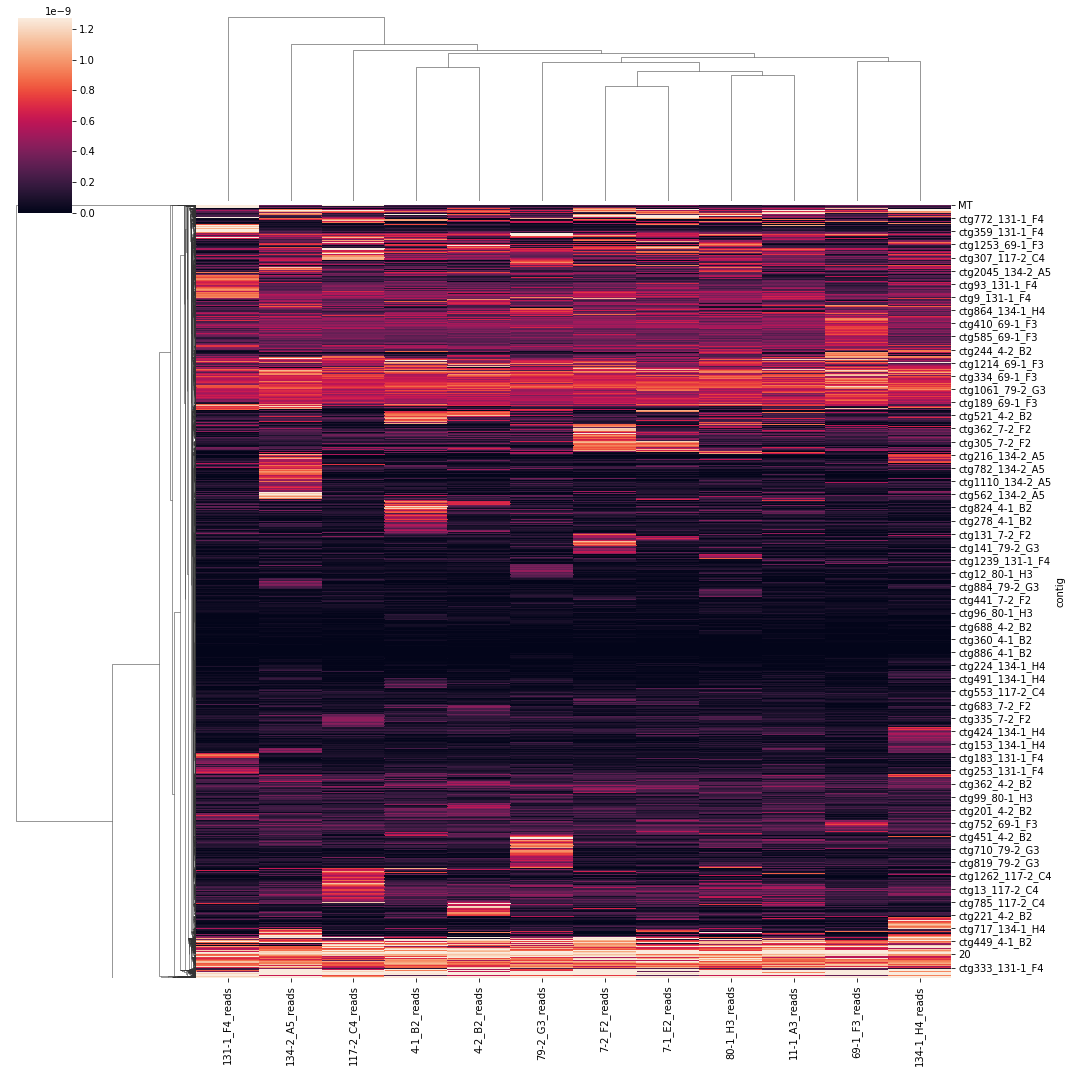

In [33]:
df = pd.read_csv("./alignments/raw_reads/bases_mapped_contig.tsv", sep="\t", index_col=0)
for col in df.columns[1:]:
    df[col] = df[col]/df[col].sum()/(df["length"])
df = df.drop(columns=["length"])    

#filt_df = df[(df>=0.5).sum(axis=1)>=1]
#print(len(df), len(filt_df))

_ = sns.clustermap(df, figsize=(15, 15), robust=True)

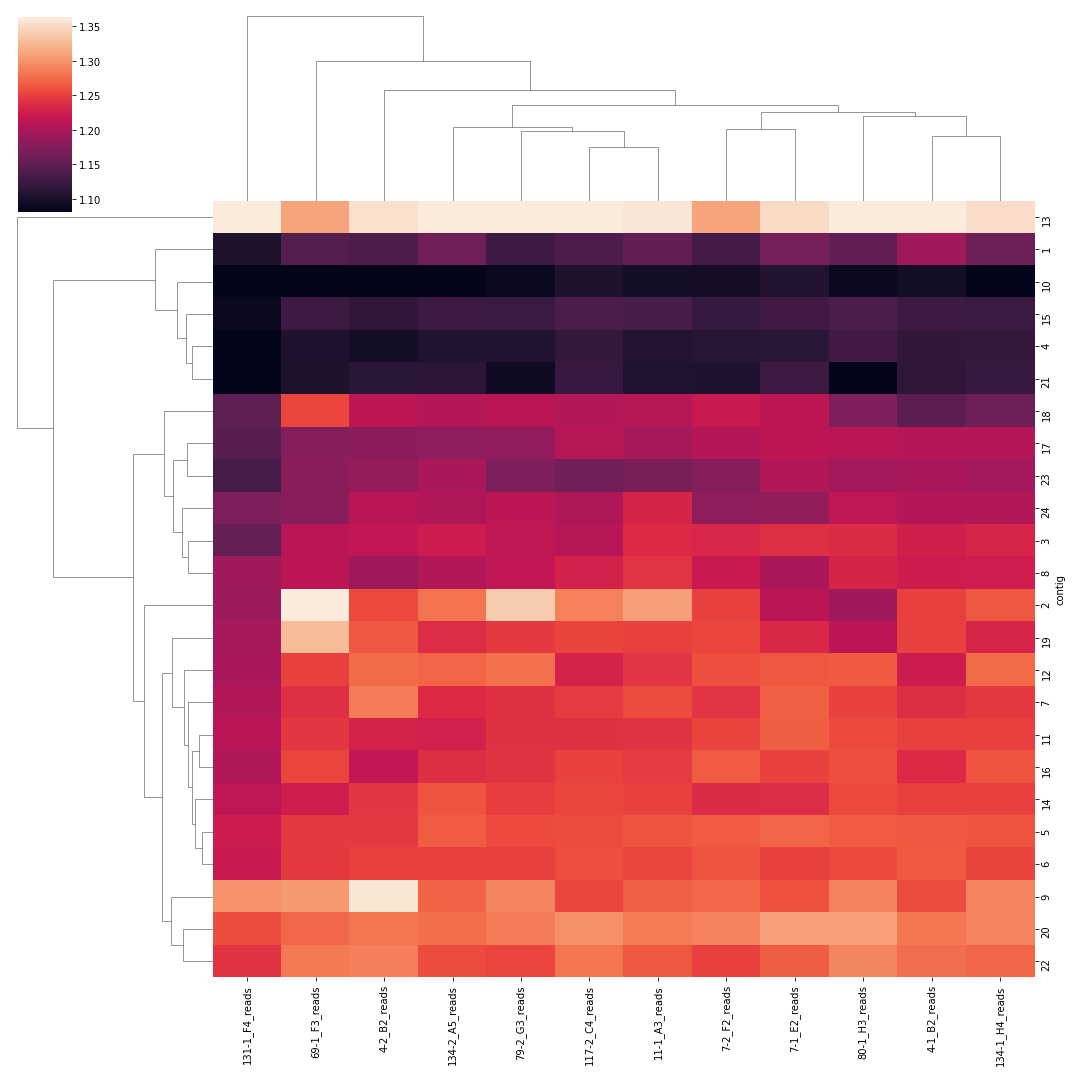

In [42]:
chr_list = [str(i) for i in range(1,25)]

df = pd.read_csv("./alignments/raw_reads/bases_mapped_contig.tsv", sep="\t", index_col=0)
for col in df.columns[1:]:
    df[col] = df[col]/df[col].sum()/df["length"]*1e9
    #df[col] = df[col]/df["length"]
df = df.drop(columns=["length"])
filt_df = df.loc[chr_list]

_ = sns.clustermap(filt_df, figsize=(15, 15), robust=True)

# Generate coverage BED 

In [7]:
outdir = "coverage2"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2


## Define parsing function 

In [10]:
def split_path (path):
    l = []
    s = ""
    for c in path:
        if s and c in ["<", ">"]:
            l.append(s)
            s = c
        else:
            s+=c
    if s: 
        l.append(s)
    return l

def parse_stable_gaf (gaf_fn, min_align_len=100, min_mapq=10, progress=True):
    
    with open (gaf_fn) as gaf_fp:
        c = Counter()
        l = []
        
        coord_tuple = namedtuple("coord_tuple", ("chromosome", "start", "end"))
        for line in tqdm(gaf_fp, disable=not progress):
            line = line.strip().split("\t")
            align_len = int(line[10])
            mapq = int(line[11])
            align_type = line[12].split(":")[-1]

            if align_len < min_align_len:
                c["Short length alignments"]+=1
                continue
            if mapq < min_mapq:
                c["Low mapq alignments"]+=1
                continue
            if align_type != "P":
                c["Non primary alignments"]+=1
                continue
            
            # Decompose path from
            c["Valid reads"]+=1
            for p in split_path(line[5]):
                
                if p[0] in ["<", ">"]:
                    chromosome = p[1:].split(":")[0]
                    start = int(p.split(":")[1].split("-")[0])
                    end = int(p.split(":")[1].split("-")[1])
                    #strand = "+" if node[0] == ">" else "-"
                                        
                else:
                    chromosome = p
                    start = int(line[7])
                    end = int(line[8])
                    #strand = line[4]
                
                c["Valid segments"]+=1
                l.append(coord_tuple(chromosome, start, end))
    
    for i, j in c.items():
        stdout_print(f"\t\t{i}: {j}\n")
    
    df = pd.DataFrame(l)
    df.sort_values(by=["chromosome", "start", "end"], inplace=True)
    df.reset_index(inplace=True, drop=True)
        
    return df

def coverage_from_gaf (gaf_src, all_fasta_ref, outdir, min_align_len=100, min_mapq=1):
    
    stdout_print("Define chromosome length for pybedtools\n")
    chrom_len = OrderedDict()
    with pyfaidx.Fasta(all_fasta_ref) as fa:
        for seq in fa:
            chrom_len[str(seq.name)]=(0, len(seq))
    
    stdout_print("Parsing gaf files\n")
    for gaf_fn in glob.glob(gaf_src):
        sample_id = gaf_fn.split("/")[-1].rpartition("_")[0]

        stdout_print(f"Analyse sample {sample_id}\n")
        
        stdout_print("\tCollect coordinates from paths\n")
        bed_df = parse_stable_gaf (gaf_fn, min_align_len=min_align_len, min_mapq=min_mapq, progress=False)
        bed_fn = os.path.join(outdir, f"{sample_id}.bed")
        bed_df.to_csv(bed_fn, index=False, header=False, sep="\t")

        stdout_print("\tCompute coverage with bedtools\n")
        bedgraph_fn = os.path.join(outdir, f"{sample_id}.bedgraph")
        bed = pbt.BedTool(bed_fn)
        bed.set_chromsizes(chrom_len)
        bg = bed.genomecov(bg=True, split=True, trackopts=f'type=bedGraph name={sample_id}')
        bg.saveas(bedgraph_fn)

## Assemblies

In [12]:
outdir = "coverage2/assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

coverage_from_gaf(
    gaf_src = "./alignments2/assemblies/*_stable.gaf", 
    all_fasta_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa",
    outdir = outdir,
    min_align_len=100,
    min_mapq=1)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2/assemblies
Define chromosome length for pybedtools
Parsing gaf files
Analyse sample 11-1_A3
	Collect coordinates from paths
		Valid reads: 4737
		Valid segments: 142732
		Low mapq alignments: 30
	Compute coverage with bedtools
Analyse sample 7-1_E2
	Collect coordinates from paths
		Valid reads: 4664
		Valid segments: 140450
		Low mapq alignments: 48
	Compute coverage with bedtools
Analyse sample 80-1_H3
	Collect coordinates from paths
		Valid reads: 5412
		Valid segments: 146056
		Low mapq alignments: 27
	Compute coverage with bedtools
Analyse sample 134-1_H4
	Collect coordinates from paths
		Valid reads: 4990
		Valid segments: 140290
		Low mapq alignments: 41
	Compute coverage with bedtools
Analyse sample 79-2_G3
	Collect coordinates from paths
		Valid reads: 4606
		Valid segments: 139154
		Low mapq alignments: 43
	Compute coverage with bedtools
Analyse sample 134-2_A5
	Collect coordinat

## Raw reads

In [14]:
outdir = "coverage2/raw_reads"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

coverage_from_gaf(
    gaf_src = "./alignments2/raw_reads/*_stable.gaf", 
    all_fasta_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa",
    outdir = outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2/raw_reads
Define chromosome length for pybedtools
Parsing gaf files
Analyse sample 80-1_H3
	Collect coordinates from paths
		Valid reads: 2917291
		Valid segments: 4919369
		Low mapq alignments: 83469
		Short length alignments: 29408
	Compute coverage with bedtools
Analyse sample 134-2_A5
	Collect coordinates from paths
		Valid reads: 6777334
		Valid segments: 11408909
		Low mapq alignments: 194759
		Short length alignments: 81989
	Compute coverage with bedtools
Analyse sample 131-1_F4
	Collect coordinates from paths
		Valid reads: 6094598
		Valid segments: 11267278
		Low mapq alignments: 171111
		Short length alignments: 70168
	Compute coverage with bedtools
Analyse sample 7-2_F2
	Collect coordinates from paths
		Valid reads: 4608657
		Valid segments: 7788221
		Low mapq alignments: 127989
		Short length alignments: 51098
	Compute coverage with bedtools
Analyse sample 7-1_E2
	Collect coor

## RNA-Seq

In [15]:
outdir = "coverage2/rna_seq"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

coverage_from_gaf(
    gaf_src = "./alignments2/rna_seq/*_stable.gaf", 
    all_fasta_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa",
    outdir = outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2/rna_seq
Define chromosome length for pybedtools
Parsing gaf files
Analyse sample 104-1
	Collect coordinates from paths
		Valid reads: 13273009
		Valid segments: 13465726
		Short length alignments: 4998346
		Low mapq alignments: 552162
	Compute coverage with bedtools
Analyse sample 106-1
	Collect coordinates from paths
		Valid reads: 14908961
		Valid segments: 15186000
		Low mapq alignments: 606541
		Short length alignments: 5931186
	Compute coverage with bedtools
Analyse sample 106-2
	Collect coordinates from paths
		Valid reads: 14505216
		Valid segments: 14586181
		Low mapq alignments: 536849
		Short length alignments: 5234146
	Compute coverage with bedtools
Analyse sample 10-1
	Collect coordinates from paths
		Valid reads: 12623419
		Valid segments: 12782983
		Short length alignments: 4945502
		Low mapq alignments: 468136
	Compute coverage with bedtools
Analyse sample 117-2
	Collect co

	Collect coordinates from paths
		Valid reads: 15508320
		Valid segments: 15632843
		Short length alignments: 6776940
		Low mapq alignments: 490659
	Compute coverage with bedtools
Analyse sample 71-1
	Collect coordinates from paths
		Valid reads: 13577377
		Valid segments: 13805382
		Short length alignments: 5384287
		Low mapq alignments: 539074
	Compute coverage with bedtools
Analyse sample 72-2
	Collect coordinates from paths
		Valid reads: 12669979
		Valid segments: 12766417
		Short length alignments: 4936910
		Low mapq alignments: 460648
	Compute coverage with bedtools
Analyse sample 79-2
	Collect coordinates from paths
		Valid reads: 14411069
		Valid segments: 14474574
		Short length alignments: 5290048
		Low mapq alignments: 527178
	Compute coverage with bedtools
Analyse sample 80-1
	Collect coordinates from paths
		Valid reads: 15351573
		Valid segments: 15477784
		Short length alignments: 5633655
		Low mapq alignments: 555289
	Compute coverage with bedtools
Analyse sample 84-2


# Segment Usage analysis

In [88]:
outdir = "segment_usage2"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/segment_usage2


## Define parsing function

In [379]:
def iter_idx_tuples (df):
    for i, j in zip(df.index, df.itertuples(index=False, name=None)):
        yield (i, j)
        
def iter_line (line, names):
    for i, j in zip(names, line):
        yield (i, j)

        
df = pd.read_csv("./segment_usage2/raw_reads/segment_usage_len_cov_norm.tsv", sep="\t", index_col=0)
df = df.drop(columns=["chromosome","length", "start", "end", "type"])

display(df.head())

for i, j in iter_idx_tuples(df):
    print(i,j)
    
    for k,l in iter_line(j, df.columns):
        print(i,k,l)
    
    break

,80-1_H3,134-2_A5,131-1_F4,7-2_F2,7-1_E2,4-1_B2,69-1_F3,79-2_G3,134-1_H4,117-2_C4,11-1_A3,4-2_B2
seg_id,,,,,,,,,,,,
s648599,0.153746,0.148558,0.003689,0.139817,0.046945,0.318755,0.029822,0.062995,0.146057,0.080340,0.061490,0.076256
s648600,0.092561,0.282229,0.000000,0.256300,0.187779,0.139093,0.460111,0.000000,0.045431,0.189078,0.553410,0.204637
s648601,0.264922,0.243811,0.046163,0.383681,0.308246,0.182274,0.327036,0.445939,0.238855,0.415930,0.155322,0.328525
s648602,0.103703,0.066953,0.014042,0.257649,0.200341,0.000000,0.215834,0.000000,0.000000,0.150485,0.000000,0.099750
s648603,0.000000,0.000000,0.036640,0.004119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


s648599 (0.15374630677982462, 0.1485584385119315, 0.003689098675128043, 0.13981683122443614, 0.04694466857336182, 0.3187553506997674, 0.029821984993180638, 0.06299532856192612, 0.1460573374644441, 0.08034026059257544, 0.06149005089351579, 0.07625559992033337)
s648599 80-1_H3 0.15374630677982462
s648599 134-2_A5 0.1485584385119315
s648599 131-1_F4 0.003689098675128043
s648599 7-2_F2 0.13981683122443614
s648599 7-1_E2 0.04694466857336182
s648599 4-1_B2 0.3187553506997674
s648599 69-1_F3 0.029821984993180638
s648599 79-2_G3 0.06299532856192612
s648599 134-1_H4 0.1460573374644441
s648599 117-2_C4 0.08034026059257544
s648599 11-1_A3 0.06149005089351579
s648599 4-2_B2 0.07625559992033337


In [396]:
def iter_idx_tuples (df):
    for i, j in zip(df.index, df.itertuples(index=False, name=None)):
        yield (i, j)
        
def iter_line (line, names):
    for i, j in zip(names, line):
        yield (i, j)
        
def gaf_seg_coverage (gaf_fn, graph_info_dict, min_align_len=100, min_mapq=10, progress=True):
    seg_cov_dict = Counter()
    info_counter = Counter()
    
    with open (gaf_fn) as gaf_fp:
        for line in tqdm(gaf_fp, disable=not progress):
            line = line.strip().split("\t")
            path_str = line[5]
            seg_list = re.split('<|>',path_str[1:])
            start = int(line[7])
            end = int(line[8])
            align_len = int(line[10])
            mapq = int(line[11])
            align_type = line[12].split(":")[-1]
            
            if align_len < min_align_len:
                info_counter["short length alignments"]+=1
            elif mapq < min_mapq:
                info_counter["low mapq alignments"]+=1
            elif align_type != "P":
                info_counter["non primary alignments"]+=1
            
            elif len(seg_list) == 1:
                info_counter["Single segment alignments"]+=1
                seg_len = end-start
                seg = seg_list[0]
                seg_cov_dict[seg] += seg_len
            
            else:
                info_counter["Multi segment alignments"]+=1
                all_seg_len = 0
                
                # First segment exception
                seg = seg_list[0]
                seg_len = graph_info_dict[seg]["length"]
                all_seg_len+=seg_len
                seg_cov_dict[seg] += seg_len-start

                # Internal segments
                for seg in seg_list[1:-1]:
                    seg_len = graph_info_dict[seg]["length"]
                    all_seg_len+=seg_len
                    seg_cov_dict[seg] += seg_len

                # Last segment exception
                seg = seg_list[-1]
                seg_len = graph_info_dict[seg]["length"]
                all_seg_len+=seg_len
                seg_cov_dict[seg] += seg_len-(all_seg_len-end)
    
    return seg_cov_dict, info_counter

def segment_usage_stats (gaf_src, graph_info_pkl, fasta_canonical_ref, outdir, n_sample_range=[12,10,8,6,4,2,1], min_align_len=100, min_mapq=10, min_normed_cov=0.1):
    
    stdout_print("Get list of reference chromosome\n")
    ref_chrom_l=[]
    with pyfaidx.Fasta(fasta_canonical_ref) as fa:
        ref_chrom_l = [s.name for s in fa]
    
    stdout_print("Parsing reference graph\n")
    graph_info_df = pd.read_pickle(graph_info_fn)
    graph_info_df = graph_info_df[["chromosome","length","start","end","type"]]
    graph_info_dict = graph_info_df.to_dict(orient="index")

    all_cov = OrderedDict()
    all_info = OrderedDict()
    
    stdout_print("Parsing gaf files\n")
    for gaf_fn in glob.glob(gaf_src):
        
        sample_id = gaf_fn.split("/")[-1].split("_")[0]
        stdout_print(f"\tParsing data for sample {sample_id}\n")
        seg_cov_dict, info_counter = gaf_seg_coverage (gaf_fn=gaf_fn, graph_info_dict=graph_info_dict, min_align_len=min_align_len, min_mapq=min_mapq, progress=False)
        all_cov[sample_id] = seg_cov_dict
        all_info[sample_id] = info_counter
        
    info_df = pd.DataFrame(all_info)
    display(info_df)
    
    stdout_print("Cast coverage data to DataFrame\n")
    cov_df = pd.DataFrame(all_cov)
    cov_df = cov_df.fillna(0)
    cov_df = cov_df.astype(np.int64)
        
    stdout_print("Merge cov df and info from graph\n")
    data_col = cov_df.columns
    cov_df = pd.merge(left=graph_info_df, right=cov_df, left_index=True, right_index=True, how="left")
    cov_df[data_col] = cov_df[data_col].fillna(0)
    cov_df.sort_values(["chromosome","start","end"], inplace=True)
    display(cov_df.head())
    out_fn = os.path.join(outdir, "segment_usage_raw.tsv")
    cov_df.to_csv(out_fn, sep="\t")
    
    stdout_print("Normalise by length only\n")
    len_norm_cov_df = cov_df.copy()
    for col in data_col:
        len_norm_cov_df[col] = len_norm_cov_df[col]/len_norm_cov_df["length"]
    display(len_norm_cov_df.head())
    out_fn = os.path.join(outdir, "segment_usage_len_norm.tsv")
    len_norm_cov_df.to_csv(out_fn, sep="\t")
    
    stdout_print("Normalise by length and total coverage over canonical chromosomes\n")
    canonical_df = cov_df[cov_df["chromosome"].isin(ref_chrom_l)]
    full_norm_cov_df = cov_df.copy()
    for col in data_col:
        full_norm_cov_df[col] = (full_norm_cov_df[col]/full_norm_cov_df["length"])/(canonical_df[col].sum()/canonical_df["length"].sum())
    display(full_norm_cov_df.head())
    out_fn = os.path.join(outdir, "segment_usage_len_cov_norm.tsv")
    full_norm_cov_df.to_csv(out_fn, sep="\t")
    
    stdout_print("Count segment_coverage by category\n")
    ref_alt_c = defaultdict(Counter)
    ref_chrom_c = defaultdict(Counter)
    alt_contig_c = defaultdict(Counter)
    
    norm_cov_data = full_norm_cov_df.drop(columns=["chromosome","length", "start", "end", "type"])
    
    for segment, line in tqdm(iter_idx_tuples(norm_cov_data), total=len(cov_df)):
        seg_info = graph_info_dict[segment]
        sample_type = seg_info["type"]
        
        # Canonical reference K
        if seg_info["chromosome"] in ref_chrom_l:
            for sample_id, cov in iter_line(line, norm_cov_data.columns):
                ref_alt_c[sample_id][sample_type]+=cov
                ref_chrom_c[sample_id][seg_info["chromosome"]]+=cov
                
        # Alternative contig
        else:
            # Count values 
            n_samples = 0
            for v in line:
                if v>min_normed_cov:
                    n_samples+=1
            for n in n_sample_range:
                if n_samples >= n:
                    cat = f"{n} sample contig"
                    for sample_id, cov in iter_line(line, norm_cov_data.columns):
                        ref_alt_c[sample_id][sample_type]+=cov
                        alt_contig_c[sample_id][cat]+=cov
                    break
    
    stdout_print("Cast to Dataframe and plot\n")
    ref_alt_df = pd.DataFrame(ref_alt_c).T
    ref_alt_df = ref_alt_df.reindex(columns=["HDRR","HNI","HSOK","MIKK","HDRR+","HNI+","HSOK+"], index=["4-1","4-2","7-1","7-2","11-1","69-1","79-2","80-1","117-2","131-1","134-1","134-2"])
    out_fn = os.path.join(outdir, "chromosome_alternative_coverage.tsv")
    ref_alt_df.to_csv(out_fn, sep="\t")
    display(ref_alt_df)
    
    ref_chrom_df = pd.DataFrame(ref_chrom_c).T
    ref_chrom_df = ref_chrom_df.reindex(columns=ref_chrom_l, index=["4-1","4-2","7-1","7-2","11-1","69-1","79-2","80-1","117-2","131-1","134-1","134-2"])
    #ref_chrom_df = ref_chrom_df.sort_index()
    out_fn = os.path.join(outdir, "reference_chromosomes_coverage.tsv")
    ref_chrom_df.to_csv(out_fn, sep="\t")
    display(ref_chrom_df)
    
    alt_contig_df = pd.DataFrame(alt_contig_c).T
    alt_contig_df = alt_contig_df.reindex(columns=[f"{i} sample contig" for i in n_sample_range], index=["4-1","4-2","7-1","7-2","11-1","69-1","79-2","80-1","117-2","131-1","134-1","134-2"])
    #alt_contig_df = alt_contig_df.sort_index()
    out_fn = os.path.join(outdir, "alternative_count_coverage.tsv")
    alt_contig_df.to_csv(out_fn, sep="\t")
    display(alt_contig_df)
    
    with pl.style.context("ggplot"):
        fig, axes = pl.subplots(3, 1, figsize=(15,15))
        
        for i, (df, label, palette) in enumerate((
            (ref_alt_df, "reference chromosomes and alternative contigs", sns.color_palette("tab10", n_colors=len(ref_alt_df.columns))),
            (ref_chrom_df, "reference chromosomes details", sns.cubehelix_palette(len(ref_chrom_df.columns), start=0.9, rot=0.1, dark=0, light=0.90, hue=2.75, gamma=0.75, reverse=True)),
            (alt_contig_df, "alternative contigs count", sns.cubehelix_palette(len(alt_contig_df.columns), start=0.9, rot=0.1, dark=0.1, light=0.80, hue=2.75, gamma=0.75, reverse=True)))):

            ax = axes[i]
            df = df.divide(df.sum(axis=1), axis=0)*100
            df.plot.bar(stacked=True, ax=ax, color=palette)
            ax.set_title(f"Percentage of graph segment coverage for {label}")
            ncol = 2 if len(df.columns)>10 else 1
            ax.legend(bbox_to_anchor=(1, 1), loc=2, facecolor="white", frameon=False, ncol=ncol)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        fig.tight_layout()
        out_fn = os.path.join(outdir, "graph_segment_coverage.svg")
        fig.savefig(out_fn)
        
    stdout_print("Write out as bed file per sample\n")
    for col in data_col:
        sdf = full_norm_cov_df[["chromosome", "start", "end", col]]
        sdf = sdf[sdf[col]>0]
        outfile = f"./{outdir}/{col}_segments.bedgraph"
        with open (outfile, "w") as fp:
            fp.write(f"track type=bedGraph type=bedGraph name={col}\n")
        sdf.to_csv(outfile, mode="a", header=False, index=False, sep="\t")

## Assemblies

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/segment_usage2/assemblies
Get list of reference chromosome
Parsing reference graph
Parsing gaf files
	Parsing data for sample 11-1
	Parsing data for sample 7-1
	Parsing data for sample 80-1
	Parsing data for sample 134-1
	Parsing data for sample 79-2
	Parsing data for sample 134-2
	Parsing data for sample 4-1
	Parsing data for sample 7-2
	Parsing data for sample 4-2
	Parsing data for sample 117-2
	Parsing data for sample 131-1
	Parsing data for sample 69-1


,11-1,7-1,80-1,134-1,79-2,134-2,4-1,7-2,4-2,117-2,131-1,69-1
Multi segment alignments,3028,2636,3934,3027,2815,3886,2729,2620,2474,2667,3059,2714
Single segment alignments,1709,2028,1478,1963,1791,2085,1883,1934,1950,2091,2231,1667
low mapq alignments,30,48,27,41,43,50,49,46,55,58,47,30


Cast coverage data to DataFrame
Merge cov df and info from graph


,chromosome,length,start,end,type,11-1,7-1,80-1,134-1,79-2,134-2,4-1,7-2,4-2,117-2,131-1,69-1
seg_id,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,286.0,0.0,0.0,0.0,0.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.0,0.0,0.0,0.0,597.0,584.0,0.0,0.0,0.0,597.0,0.0,0.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalise by length only


,chromosome,length,start,end,type,11-1,7-1,80-1,134-1,79-2,134-2,4-1,7-2,4-2,117-2,131-1,69-1
seg_id,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.0,0.0,0.0,0.0,1.0,0.978224,0.0,0.0,0.0,1.0,0.0,0.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Normalise by length and total coverage over canonical chromosomes


,chromosome,length,start,end,type,11-1,7-1,80-1,134-1,79-2,134-2,4-1,7-2,4-2,117-2,131-1,69-1
seg_id,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1.170095,0.0,0.000000,0.0,0.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.0,0.0,0.0,0.0,1.176123,1.14787,0.0,0.000000,0.0,1.168944,0.0,0.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0


Count segment_coverage by category


100%|██████████| 1109492/1109492 [00:12<00:00, 90815.74it/s]

Cast to Dataframe and plot


,HDRR,HNI,HSOK,MIKK,HDRR+,HNI+,HSOK+
4-1,609663.162592,20040.168962,5736.836096,79913.350712,39.889065,423.956564,81.508456
4-2,610073.103835,19991.825389,5732.076753,80892.810382,9.349842,431.864216,91.536551
7-1,609353.303767,19866.077308,5615.397733,79685.465794,42.077514,411.864495,86.922931
7-2,612258.415504,19909.144692,5665.971965,79473.104067,44.463598,402.802118,86.748426
11-1,604560.953525,19859.270634,5616.566668,80149.363212,22.508425,422.201635,84.835861
69-1,616057.305559,20027.264295,5780.228834,78901.396100,9.408810,421.641315,82.010793
79-2,609868.894742,19946.486979,5606.039471,78514.011541,31.755308,425.372120,89.296403
80-1,600773.101228,19794.692676,5594.466031,82384.840755,19.265728,424.759800,81.645032
117-2,614147.913644,19912.952634,5765.798169,79320.386110,12.858386,404.320662,89.739488
131-1,595329.888907,47360.641117,5795.387205,74486.756652,10.734707,883.527770,105.134817


,HDRR_1,HDRR_2,HDRR_3,HDRR_4,HDRR_5,HDRR_6,HDRR_7,HDRR_8,HDRR_9,HDRR_10,HDRR_11,HDRR_12,HDRR_13,HDRR_14,HDRR_15,HDRR_16,HDRR_17,HDRR_18,HDRR_19,HDRR_20,HDRR_21,HDRR_22,HDRR_23,HDRR_24,HDRR_MT
4-1,32813.536762,21326.865539,30034.938134,28091.192012,29673.415335,26154.378380,27158.044430,20317.151923,26923.640415,26882.385927,25117.091584,26934.799105,28054.580298,26144.331885,24570.583824,26044.381099,26013.312317,25052.218088,20185.377185,20025.686450,26768.240079,23610.178388,23220.360559,18546.472872,0.0
4-2,33145.968268,21262.912717,29696.786013,28315.329608,30008.804762,26246.803549,27488.912800,20398.764564,26757.133572,26849.701965,24986.190930,26981.939700,27754.750651,26380.663605,24482.170178,25797.321124,26021.986974,24992.121737,20280.703189,20132.703856,26526.319507,23736.649888,23411.443192,18417.021477,0.0
7-1,33345.832407,20983.124675,30171.925502,28057.712661,29428.252857,25775.922885,27374.691528,20035.263538,27102.995617,27139.371110,24820.518583,27097.226302,27668.422895,25897.342878,24566.167621,25691.204020,26129.747455,24980.462448,20316.253897,20212.259247,26791.478797,23792.944700,23400.782626,18573.399517,0.0
7-2,33298.953969,21191.189940,30429.001636,28340.714860,29677.352143,26203.628247,27386.930418,20331.493078,27017.598734,27350.615743,25126.972337,27235.722481,28003.720248,26018.981198,24658.949553,25779.076499,26242.760666,25055.634086,20269.643865,20061.537826,26877.422358,23834.255829,23362.588104,18503.671689,0.0
11-1,32913.276812,21133.060357,29786.855543,28155.395041,29323.242244,25721.601021,26771.889988,20127.081355,26806.618484,26879.580817,24902.043285,26449.648576,27375.469306,25659.235735,24554.185672,25950.419539,25866.250995,24564.069975,20473.856777,19907.220513,26790.075282,23525.974215,22843.624832,18080.277155,0.0
69-1,33822.480665,21459.234148,30269.616735,28313.554002,29964.844454,26254.683689,27555.709498,20360.078913,27217.437285,27322.066872,25257.846556,27348.464659,28208.027193,26270.236090,24801.432046,26129.130006,26486.787444,24847.950520,20772.658345,20235.714345,27103.916092,23975.369896,23471.395765,18608.670341,0.0
79-2,33111.511631,20835.986606,30101.367678,27927.805749,29823.530026,26149.532127,27353.354423,20507.996179,26921.511257,27053.227234,25018.096638,27058.643543,27791.940031,25957.579803,24749.205393,25687.077624,26257.012907,24684.574639,20330.816309,20210.041995,26507.499030,23974.218704,23269.144305,18587.220902,0.0
80-1,32815.328225,20846.583971,29537.132729,27683.028732,28882.190037,25836.552228,27090.002654,19910.154927,26348.947136,26377.694145,24675.988915,26587.673024,27752.420314,25432.306113,24515.548837,25712.118150,25978.196166,24284.216595,19920.145792,19786.314712,26353.816591,23291.909056,23018.715570,18136.116607,0.0
117-2,33251.993639,21496.959356,29728.764575,28209.559165,29821.928294,26130.088199,27542.974656,20411.873219,27194.396123,27431.384311,25085.227358,27307.860869,28315.737126,26230.754214,24618.070646,26009.967885,26339.110676,25135.173183,20314.529718,20284.635392,27260.884926,24003.749635,23368.069218,18654.221254,0.0
131-1,31146.185074,19628.732941,30332.969029,24972.170909,30686.976068,26826.328555,28191.647234,19819.276545,27931.506063,23955.076033,25418.180791,26955.730016,28729.948312,25903.037328,22792.138904,25540.681332,26046.725282,24114.968601,19968.336735,20681.825875,22897.086828,24693.892621,20366.087799,17730.380024,0.0


,12 sample contig,10 sample contig,8 sample contig,6 sample contig,4 sample contig,2 sample contig,1 sample contig
4-1,27918.098900,23109.661127,13073.209986,11420.824811,11000.480087,11708.787515,8004.647431
4-2,27812.863058,23328.518408,13514.329174,11749.208901,11074.855350,11540.432452,8129.255791
7-1,27837.010911,23512.277487,13312.164744,11582.867052,11053.076426,11599.551272,6810.857882
7-2,27844.843174,23504.237928,13366.848413,11605.735311,10958.356916,11661.065471,6641.147652
11-1,28157.745023,22689.409514,12672.797591,10849.867210,10089.471270,10298.871230,11396.584596
69-1,27948.943010,22661.576528,12688.014820,10903.020064,10266.501372,11036.484028,9717.410325
79-2,27976.333258,22892.969762,12953.544472,11039.718834,10460.726517,10719.938317,8569.730663
80-1,28640.438998,21658.733408,12245.114141,10583.126416,9765.428322,10250.379903,15156.448833
117-2,27836.504273,23142.663818,13061.669118,11337.332535,10641.202654,11017.123570,8469.559480
131-1,28390.211482,18460.134125,11158.237673,9958.986987,9505.701415,10808.792125,40360.118461


Write out as bed file per sample


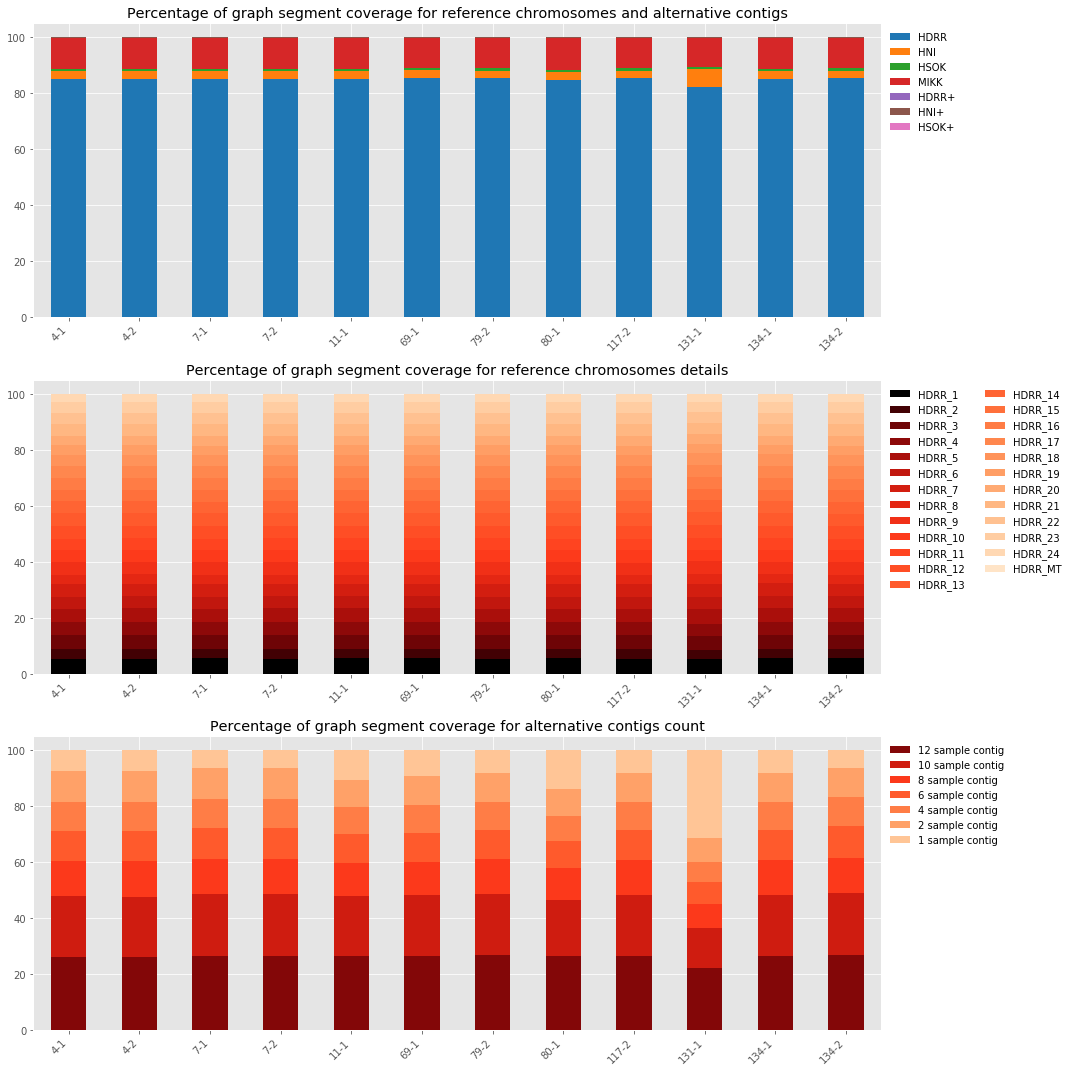

In [397]:
outdir = "segment_usage2/assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

segment_usage_stats (
    gaf_src="./alignments2/assemblies/*_unstable.gaf",
    graph_info_pkl="./graph_assembly/all_ref_graph_seg_info.pkl",
    fasta_canonical_ref="./references/Oryzias_latipes_HDRR_clean.fa",
    outdir=outdir,
    n_sample_range=[12,10,8,6,4,2,1],
    min_align_len=100,
    min_mapq=1,
    min_normed_cov=0)

## Raw reads

Get list of reference chromosome
Parsing reference graph
Parsing gaf files
	Parsing data for sample 80-1
	Parsing data for sample 134-2
	Parsing data for sample 131-1
	Parsing data for sample 7-2
	Parsing data for sample 7-1
	Parsing data for sample 4-1
	Parsing data for sample 69-1
	Parsing data for sample 79-2
	Parsing data for sample 134-1
	Parsing data for sample 117-2
	Parsing data for sample 11-1
	Parsing data for sample 4-2


,80-1,134-2,131-1,7-2,7-1,4-1,69-1,79-2,134-1,117-2,11-1,4-2
Multi segment alignments,1713927,3949014,3568223,2650564,2315352,2428416,2241619,2474125,2326952,2887799,1791070,2828853
Single segment alignments,1203364,2828320,2526375,1958093,1643457,1736458,1592651,1798324,1642742,2027456,1234231,2076573
low mapq alignments,83469,194759,171111,127989,111761,119741,107222,122570,114040,143142,83982,139776
short length alignments,29408,81989,70168,51098,47634,49020,39933,44784,45235,57506,33323,56746


Cast coverage data to DataFrame
Merge cov df and info from graph


,chromosome,length,start,end,type,80-1,134-2,131-1,7-2,7-1,4-1,69-1,79-2,134-1,117-2,11-1,4-2
seg_id,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,1417.0,3164.0,71.0,2021.0,624.0,4290.0,364.0,862.0,1943.0,1322.0,624.0,1248.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,391.0,2755.0,0.0,1698.0,1144.0,858.0,2574.0,0.0,277.0,1426.0,2574.0,1535.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,2336.0,4968.0,850.0,5306.0,3920.0,2347.0,3819.0,5838.0,3040.0,6548.0,1508.0,5144.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,435.0,649.0,123.0,1695.0,1212.0,0.0,1199.0,0.0,0.0,1127.0,0.0,743.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.0,0.0,5152.0,435.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalise by length only


,chromosome,length,start,end,type,80-1,134-2,131-1,7-2,7-1,4-1,69-1,79-2,134-1,117-2,11-1,4-2
seg_id,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,2.270833,5.070513,0.113782,3.238782,1.000000,6.875000,0.583333,1.381410,3.113782,2.118590,1.000000,2.000000
s648600,HDRR+_000617F,286,46919,47205,HDRR+,1.367133,9.632867,0.000000,5.937063,4.000000,3.000000,9.000000,0.000000,0.968531,4.986014,9.000000,5.367133
s648601,HDRR+_000617F,597,50034,50631,HDRR+,3.912898,8.321608,1.423786,8.887772,6.566164,3.931323,6.396985,9.778894,5.092127,10.968174,2.525963,8.616415
s648602,HDRR+_000617F,284,52947,53231,HDRR+,1.531690,2.285211,0.433099,5.968310,4.267606,0.000000,4.221831,0.000000,0.000000,3.968310,0.000000,2.616197
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.000000,0.000000,1.130072,0.095416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Normalise by length and total coverage over canonical chromosomes


,chromosome,length,start,end,type,80-1,134-2,131-1,7-2,7-1,4-1,69-1,79-2,134-1,117-2,11-1,4-2
seg_id,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.153746,0.148558,0.003689,0.139817,0.046945,0.318755,0.029822,0.062995,0.146057,0.080340,0.061490,0.076256
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.092561,0.282229,0.000000,0.256300,0.187779,0.139093,0.460111,0.000000,0.045431,0.189078,0.553410,0.204637
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.264922,0.243811,0.046163,0.383681,0.308246,0.182274,0.327036,0.445939,0.238855,0.415930,0.155322,0.328525
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.103703,0.066953,0.014042,0.257649,0.200341,0.000000,0.215834,0.000000,0.000000,0.150485,0.000000,0.099750
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.000000,0.000000,0.036640,0.004119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Count segment_coverage by category


100%|██████████| 1109492/1109492 [00:12<00:00, 89119.57it/s]

Cast to Dataframe and plot


,HDRR,HNI,HSOK,MIKK,HDRR+,HNI+,HSOK+
4-1,560525.985899,19024.345969,6141.524616,73295.278862,257.823662,455.508481,114.032990
4-2,558336.493311,18930.738109,5976.847434,73384.525015,50.559359,457.645561,116.391460
7-1,561589.256943,18978.370973,6050.612122,73361.744794,202.212259,440.541807,107.476702
7-2,558451.922936,18879.533903,5994.690120,73099.266212,181.320316,446.001205,107.274133
11-1,559017.124317,18923.345813,5948.867608,72381.710904,29.871640,453.900862,110.479277
69-1,559605.507096,18863.621798,6088.761037,73672.960079,46.563665,458.011417,128.786389
79-2,555905.609123,18858.330327,5976.993742,71982.711317,71.103713,462.760614,115.740673
80-1,557249.451718,18924.173531,5963.821456,71903.648533,21.105055,442.218302,115.718082
117-2,562917.616875,18879.125612,5957.329726,72681.552542,43.986126,446.250362,108.163285
131-1,550696.499178,44150.383053,6214.525116,64120.572260,53.686188,872.513889,110.396043


,HDRR_1,HDRR_2,HDRR_3,HDRR_4,HDRR_5,HDRR_6,HDRR_7,HDRR_8,HDRR_9,HDRR_10,HDRR_11,HDRR_12,HDRR_13,HDRR_14,HDRR_15,HDRR_16,HDRR_17,HDRR_18,HDRR_19,HDRR_20,HDRR_21,HDRR_22,HDRR_23,HDRR_24,HDRR_MT
4-1,31451.769018,20514.094459,27057.410983,25806.354602,26340.012077,23787.902270,24518.053345,18249.238161,24779.495995,24753.903542,22643.535234,24684.887681,25258.702474,26825.729942,21958.028483,23782.401227,23549.121632,22740.575960,18688.062093,19019.771560,24053.703077,21484.695058,21898.703496,16654.492659,25.340871
4-2,30395.004627,20482.630346,27096.975813,25467.273297,26373.300716,23535.477455,24833.286546,18374.424017,24971.935036,24386.423333,22576.511051,24494.083189,25338.661213,26825.381607,21784.445503,23455.746365,23208.092667,22804.166301,18727.172993,18799.842086,24125.052604,21747.982131,21758.657351,16752.225378,21.741683
7-1,31146.064803,20455.933407,27405.270277,26006.607203,26575.857406,23640.679181,24868.210293,18491.602414,24776.325337,24629.376171,22805.896846,24714.812551,25469.223327,26245.538699,21933.753770,23769.388550,23671.817545,23016.810275,18375.335420,19158.939335,24204.561597,21313.419820,22062.131608,16828.480317,23.220790
7-2,30481.789603,20829.070892,27471.629182,25634.656550,26305.844886,23550.685024,24352.847365,18383.261055,24610.047300,24652.645890,22543.417493,24701.402536,25362.324312,26244.124669,21812.407875,23715.136096,23711.043952,22712.731683,18408.524454,18679.086181,24138.357565,21360.402056,21896.342868,16871.993727,22.149719
11-1,30313.597382,20628.152967,26996.282435,25534.512226,26451.090269,23479.625110,24522.047648,18456.937042,24497.441377,24578.290678,22436.515618,24493.323534,25288.250028,27398.637833,21936.913368,23458.164565,23623.911554,22829.271538,18621.453296,18963.053504,24339.129356,21527.843779,21784.576179,16834.068922,24.034112
69-1,30193.570430,21035.769961,26946.749602,26124.254657,26466.376872,23579.400829,24352.359810,18425.437097,24733.703752,24402.157573,22619.385359,24394.144889,25241.371281,26608.930326,22067.255593,23573.420043,23487.026041,22920.625460,18950.681797,18922.545502,24371.761201,21786.495989,21784.051062,16595.102721,22.929250
79-2,30185.674829,20438.175671,27003.202399,25673.653642,26206.005844,23340.040816,24268.423256,18343.871844,24703.687956,24282.444622,22405.470497,24785.213928,25288.013322,26488.517533,21990.668798,23357.091393,23380.399822,22507.759979,18657.444528,18898.569171,24286.763413,21394.772824,21293.083619,16702.895587,23.763830
80-1,30291.731694,20550.332529,26952.350359,25971.236184,26386.921474,23501.073532,24535.501815,18317.070247,24584.399769,24363.713515,22497.345035,24501.157682,25123.362344,26871.885204,21757.580104,23118.021116,23599.719193,22691.692038,18474.358830,19266.909098,24386.313151,21355.532845,21582.916071,16547.896351,20.431536
117-2,30499.443648,21000.126237,27358.878004,25780.428922,26572.416478,23836.861160,24704.543081,18639.987438,24811.960703,24673.597395,22708.378708,24745.802758,25638.511681,26896.313684,22163.702196,23731.205596,23674.746825,22869.826448,18816.773545,19245.628482,24543.332679,21889.835670,21401.736937,16697.040812,16.537789
131-1,29401.006673,19843.779626,27258.734860,23453.637831,27171.247802,24406.917250,25087.679491,17715.760969,25534.114891,22332.803866,23111.576837,24715.518046,25932.957456,26401.421543,20154.997270,23765.920304,23567.102464,22087.715800,18853.571545,19543.880761,21273.663798,22395.700554,20191.449632,16471.250022,24.089889


,12 sample contig,10 sample contig,8 sample contig,6 sample contig,4 sample contig,2 sample contig,1 sample contig
4-1,54276.520752,19615.649069,9377.055114,6446.212951,4723.875833,3755.439178,1093.761684
4-2,53601.301182,19911.325355,9479.507001,6384.346506,4695.181525,3634.113791,1210.931577
7-1,54184.135557,20043.965228,9218.921087,6282.930924,4732.076136,3603.471618,1075.458106
7-2,53880.648282,20005.312227,9263.930888,6249.842582,4659.674514,3577.650504,1071.026891
11-1,53320.003055,19457.184328,9153.895561,6302.260728,4621.733274,3606.570026,1386.529132
69-1,53829.956831,19673.590454,9326.108656,6510.776399,4739.753195,3802.217200,1376.301649
79-2,53448.662268,19040.418879,9062.996201,6297.926353,4577.885000,3674.845338,1364.906348
80-1,53162.792991,19052.607078,9078.472218,6279.821273,4690.278683,3743.690055,1363.022662
117-2,53587.686479,19587.082816,9230.104387,6285.988426,4541.805046,3490.526227,1393.214272
131-1,50712.847675,16598.501270,8698.715734,6497.111532,5538.115337,8228.242472,19248.542528


Write out as bed file per sample


2

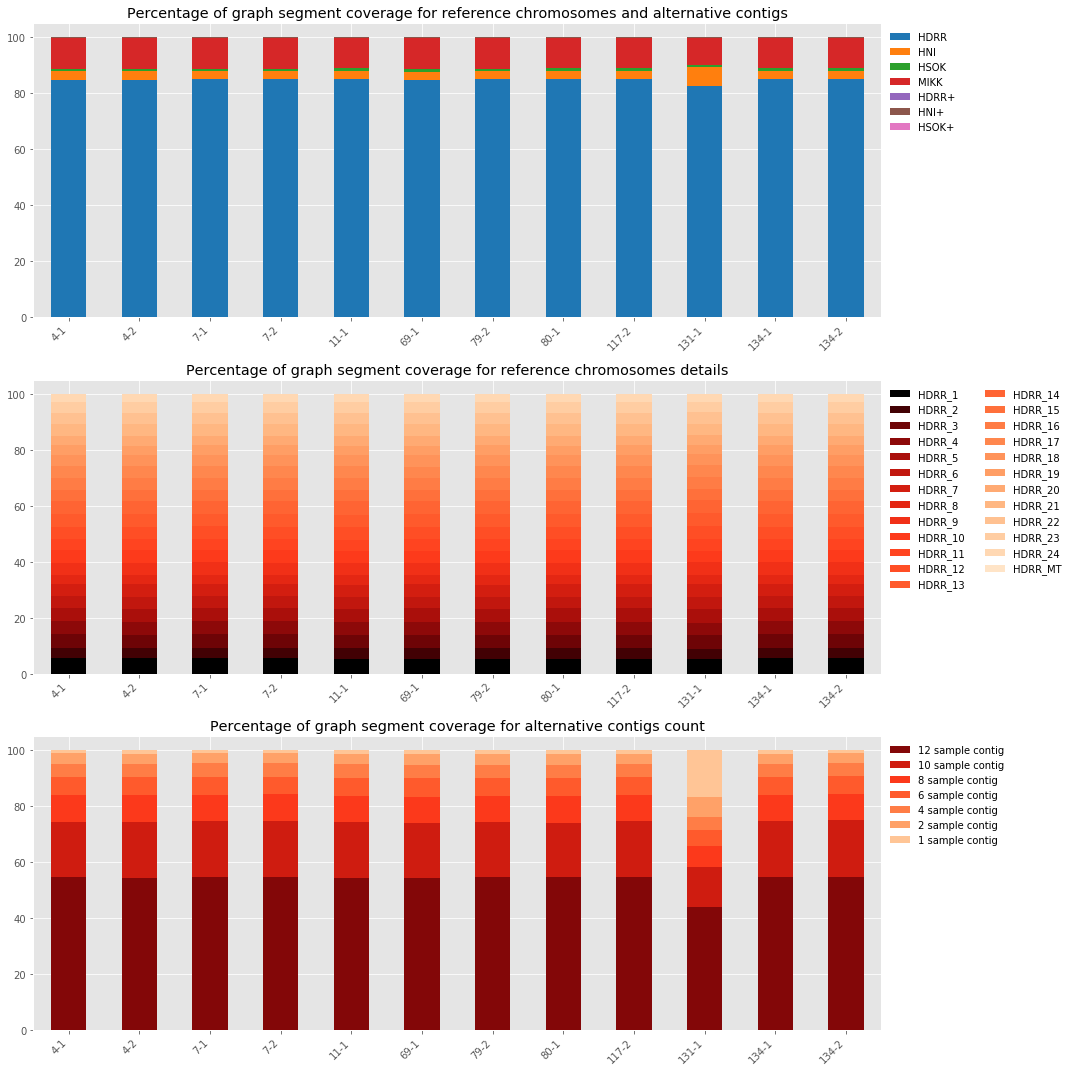

In [398]:
outdir = "segment_usage2/raw_reads"
#shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

segment_usage_stats (
    gaf_src="./alignments2/raw_reads/*_unstable.gaf",
    graph_info_pkl="./graph_assembly/all_ref_graph_seg_info.pkl",
    fasta_canonical_ref="./references/Oryzias_latipes_HDRR_clean.fa",
    outdir=outdir,
    n_sample_range=[12,10,8,6,4,2,1], 
    min_align_len=100,
    min_mapq=1,
    min_normed_cov=0.05)

min_samples_dna

### Overall usage 

,MIKK,non-MIKK
HDRR,713609808,20491018
HNI,43204187,60303692
HSOK,49055247,102988085
MIKK,203539620,114635036
All,1009408862,298417831


,MIKK,non-MIKK
HDRR,615564,33128
HNI,47854,100835
HSOK,23881,76394
MIKK,161533,50303
All,848832,260660


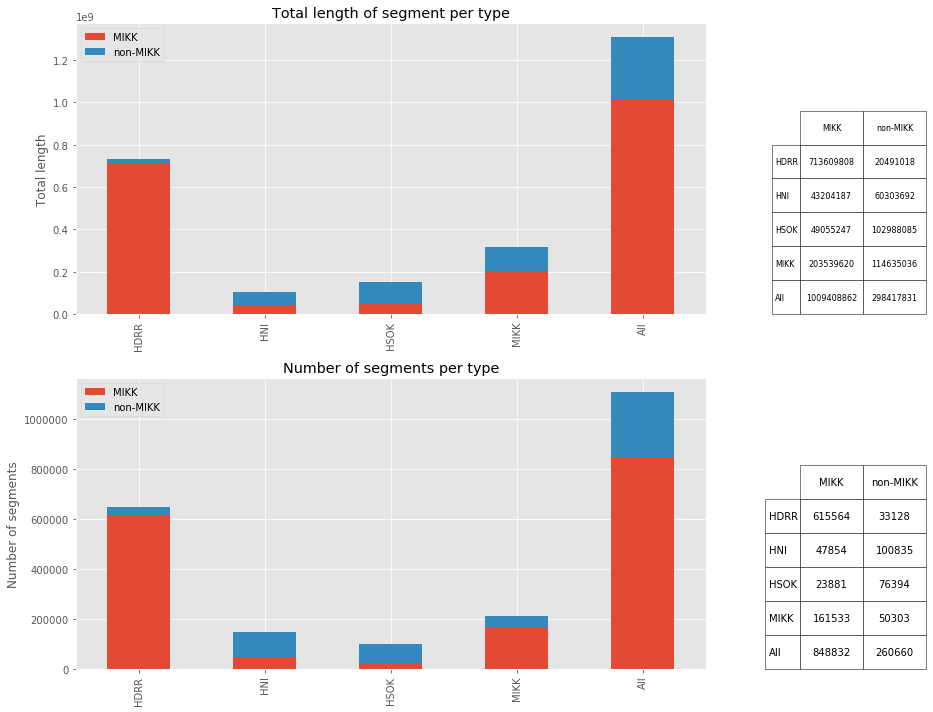

In [312]:
min_coverage_dna = 0.05
min_samples_dna = 2
outdir = "segment_usage2/raw_reads/"

fn = "segment_usage2/raw_reads/segment_usage_len_cov_norm.tsv"
df = pd.read_csv(fn, sep="\t")

info_field = ["seg_id","chromosome","length","start","end","type"]
info_df = df[info_field].copy()
data_df = df.drop(columns=info_field).copy()

info_df["pass_samples"] = data_df.ge(min_coverage_dna).sum(axis=1)
info_df["type"] = info_df["type"].str.rstrip("+")
len_d = defaultdict(Counter)
seg_d = defaultdict(Counter)

for line in info_df.itertuples():
    if line.pass_samples>=min_samples_dna:
        len_d[line.type]["MIKK"]+=line.length
        seg_d[line.type]["MIKK"]+=1
        len_d["All"]["MIKK"]+=line.length
        seg_d["All"]["MIKK"]+=1
    else:
        len_d[line.type]["non-MIKK"]+=line.length
        seg_d[line.type]["non-MIKK"]+=1
        len_d["All"]["non-MIKK"]+=line.length
        seg_d["All"]["non-MIKK"]+=1

len_df = pd.DataFrame.from_dict(len_d, orient="index")
seg_df = pd.DataFrame.from_dict(seg_d, orient="index")
len_df = len_df.reindex(["HDRR", "HNI", "HSOK", "MIKK", "All"])
seg_df = seg_df.reindex(["HDRR", "HNI", "HSOK", "MIKK", "All"])
display(len_df)
display(seg_df)

with pl.style.context('ggplot'):
    fig, (ax1, ax2) = pl.subplots(2, 1, figsize=(10,10))
    
    len_df.plot.bar(ax=ax1, stacked=True)
    table(ax1, len_df, colWidths=[0.10, 0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax1.set_title('Total length of segment per type')
    ax1.set_ylabel("Total length")
    
    seg_df.plot.bar(ax=ax2, stacked=True)
    table(ax2, seg_df, colWidths=[0.10, 0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax2.set_title('Number of segments per type')
    ax2.set_ylabel("Number of segments")
    
    fig.tight_layout()
    out_fn = os.path.join(outdir, "segment_usage_type_stats.svg")
    fig.savefig(out_fn)

## RNA-Seq

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/segment_usage2/rna_seq
Get list of reference chromosome
Parsing reference graph
Parsing gaf files
	Parsing data for sample 104-1
	Parsing data for sample 106-1
	Parsing data for sample 106-2
	Parsing data for sample 10-1
	Parsing data for sample 117-2
	Parsing data for sample 11-2
	Parsing data for sample 11-1
	Parsing data for sample 125-1
	Parsing data for sample 129-1
	Parsing data for sample 132-4-1
	Parsing data for sample 132-5
	Parsing data for sample 133-2
	Parsing data for sample 134-1
	Parsing data for sample 135-2
	Parsing data for sample 137-4
	Parsing data for sample 139-4
	Parsing data for sample 13-2
	Parsing data for sample 140-1
	Parsing data for sample 140-3
	Parsing data for sample 141-3
	Parsing data for sample 14-1
	Parsing data for sample 15-1
	Parsing data for sample 17-1
	Parsing data for sample 20-1
	Parsing data for sample 21-2
	Parsing data for sample 23-1
	Parsing data f

,104-1,106-1,106-2,10-1,117-2,11-2,11-1,125-1,129-1,132-4-1,132-5,133-2,134-1,135-2,137-4,139-4,13-2,140-1,140-3,141-3,14-1,15-1,17-1,20-1,21-2,23-1,30-1,32-2,39-1,40-1,40-2,49-1,4-1,4-2,50-2,55-2,59-1,59-2,61-1,62-2,69-1,71-1,72-2,79-2,80-1,84-2,8-2,91-1,94-1,95-1
Single segment alignments,16344392,18679954,17499403,15708910,17658338,18569648,18432769,16066082,17358795,16526814,20972865,20502791,19641356,20898045,18422811,16647817,20624785,17804875,19456368,21451404,17785974,17222061,21935636,19179613,20929828,21049259,21422542,19228327,17523100,18036807,23175863,20077568,16643678,18449604,25996647,16284867,19512755,21994407,21384676,17703094,20066505,17011665,15738179,17454445,18684958,19228297,18634433,18297821,21894394,22246833
short length alignments,809784,936924,879277,795111,867879,938645,932425,814047,852912,896575,1117169,1131041,1013802,1091001,928212,841063,1050361,1002903,983939,1141176,907084,923779,1063188,1023535,1103144,1052532,1253858,1038738,948128,991648,1294328,1002074,812739,909527,1368062,845814,957274,1107550,1203246,885376,1113152,852984,799755,868263,927807,925763,955482,998850,1054348,1118542
low mapq alignments,922715,1016640,1016341,853791,994533,997878,1053867,783143,854500,585329,981229,788149,1058399,919315,1006955,906874,955007,914461,1079495,1334313,952040,988049,1197369,1009852,1029802,1025398,1161770,1097060,969304,761070,1021840,1196008,920902,1007340,1427275,772390,972554,1227343,937026,908972,932389,896219,858898,1021912,1063006,977745,936903,719898,1017361,1191968
Multi segment alignments,746626,813170,881190,679245,819843,835662,851603,679744,687793,599431,769167,687788,850784,764241,820646,698514,699301,637280,865127,904663,703005,726791,979991,829006,852913,798617,799400,869673,743973,598433,780089,953401,747010,833737,959764,701650,807915,951447,698750,722345,663873,739870,670705,883675,864746,773674,741071,599416,869934,1003868


Cast coverage data to DataFrame
Merge cov df and info from graph


,chromosome,length,start,end,type,104-1,106-1,106-2,10-1,117-2,11-2,11-1,125-1,129-1,132-4-1,132-5,133-2,134-1,135-2,137-4,139-4,13-2,140-1,140-3,141-3,14-1,15-1,17-1,20-1,21-2,23-1,30-1,32-2,39-1,40-1,40-2,49-1,4-1,4-2,50-2,55-2,59-1,59-2,61-1,62-2,69-1,71-1,72-2,79-2,80-1,84-2,8-2,91-1,94-1,95-1
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167.0,186.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.0,0.0,86.0,108.0,120.0,0.0,0.0,0.0,120.0,108.0,0.0,0.0,0.0,0.0,0.0,228.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,176.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,0.0,88.0,0.0,70.0,188.0,0.0,0.0,0.0,0.0,188.0,0.0,0.0,0.0,340.0,0.0,0.0,0.0,0.0,0.0,125.0,0.0,138.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalise by length only


,chromosome,length,start,end,type,104-1,106-1,106-2,10-1,117-2,11-2,11-1,125-1,129-1,132-4-1,132-5,133-2,134-1,135-2,137-4,139-4,13-2,140-1,140-3,141-3,14-1,15-1,17-1,20-1,21-2,23-1,30-1,32-2,39-1,40-1,40-2,49-1,4-1,4-2,50-2,55-2,59-1,59-2,61-1,62-2,69-1,71-1,72-2,79-2,80-1,84-2,8-2,91-1,94-1,95-1
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.227564,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.267628,0.298077,0.000000,0.0,0.0,0.267628,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.314103,0.0,0.0,0.0,0.0,0.0,0.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.195804,0.0,0.300699,0.377622,0.41958,0.0,0.0,0.0,0.419580,0.377622,0.000000,0.000000,0.000000,0.0,0.0,0.797203,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.294807,0.0,0.147404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428811,0.0,0.0,0.147404,0.0,0.117253,0.314908,0.00000,0.0,0.0,0.0,0.314908,0.000000,0.000000,0.000000,0.569514,0.0,0.0,0.000000,0.0,0.0,0.20938,0.0,0.231156,0.0,0.0,0.130653,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Normalise by length and total coverage over canonical chromosomes


,chromosome,length,start,end,type,104-1,106-1,106-2,10-1,117-2,11-2,11-1,125-1,129-1,132-4-1,132-5,133-2,134-1,135-2,137-4,139-4,13-2,140-1,140-3,141-3,14-1,15-1,17-1,20-1,21-2,23-1,30-1,32-2,39-1,40-1,40-2,49-1,4-1,4-2,50-2,55-2,59-1,59-2,61-1,62-2,69-1,71-1,72-2,79-2,80-1,84-2,8-2,91-1,94-1,95-1
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.044461,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.055107,0.05831,0.000000,0.0,0.0,0.061401,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066301,0.0,0.0,0.0,0.0,0.0,0.0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.233633,0.0,0.073147,0.073488,0.099385,0.0,0.0,0.0,0.100714,0.066434,0.000000,0.00000,0.000000,0.0,0.0,0.182898,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.072603,0.0,0.031143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087737,0.0,0.0,0.028799,0.0,0.028523,0.061283,0.000000,0.0,0.0,0.0,0.075589,0.000000,0.000000,0.00000,0.112892,0.0,0.0,0.000000,0.0,0.0,0.039038,0.0,0.050868,0.0,0.0,0.027411,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Count segment_coverage by category


100%|██████████| 1109492/1109492 [00:31<00:00, 34955.53it/s]

Cast to Dataframe and plot


,HDRR,HNI,HSOK,MIKK,HDRR+,HNI+,HSOK+
4-1,350757.347347,13679.540073,5114.985132,8521.628494,0.519762,33.722235,4.197783
4-2,334822.616949,13059.157617,5633.643348,24447.519360,39.097602,33.081872,4.892076
7-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-1,339588.035448,12561.071282,8493.107702,26193.498595,21.132744,32.964758,5.049522
69-1,300248.690122,8624.324560,1766.442827,15143.416778,1.789487,44.713096,5.263329
79-2,359901.483493,13693.292837,916.349531,6137.611568,6.258409,38.034037,3.163344
80-1,337180.546476,12341.162629,1312.415072,13597.891975,0.884612,24.743665,3.176274
117-2,340388.846813,10756.270400,6765.587918,6031.666022,1.295919,33.411074,5.012776
131-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,HDRR_1,HDRR_2,HDRR_3,HDRR_4,HDRR_5,HDRR_6,HDRR_7,HDRR_8,HDRR_9,HDRR_10,HDRR_11,HDRR_12,HDRR_13,HDRR_14,HDRR_15,HDRR_16,HDRR_17,HDRR_18,HDRR_19,HDRR_20,HDRR_21,HDRR_22,HDRR_23,HDRR_24,HDRR_MT
4-1,9425.947992,2968.600962,4466.096803,151590.139478,7401.959610,60780.859671,6444.729268,6691.537240,8378.966511,9670.549815,6184.253568,6314.725109,8677.232265,5101.835293,4407.076676,6625.843355,10941.889005,4304.648589,4401.583054,5293.372817,3684.912561,6339.396737,4801.819279,5518.794873,340.576816
4-2,8781.631798,3463.120934,5170.732592,126870.100631,8743.605351,65576.852207,7052.675375,8641.107758,8684.191823,9234.793505,6289.022737,6811.680857,8627.636566,5213.824511,4594.214365,5903.020280,8006.694556,5165.013299,4689.864050,5287.739296,4001.724951,6974.121882,5366.049648,5286.875589,386.322390
7-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-1,9485.125491,3071.630751,4522.663459,150662.205431,7496.335192,55692.459149,6892.307832,6632.503770,7148.302567,7272.905761,5932.203987,5924.247691,8455.682502,5096.061065,4169.405423,5975.418820,10695.146196,5393.746388,4452.477901,4191.709977,3986.669179,5963.292521,4658.679714,5550.912100,265.942581
69-1,19295.145791,5568.995773,6552.140549,37070.507089,9190.716587,14571.146314,8166.267265,9045.324241,12633.660261,12566.594173,11594.450209,9213.744217,16302.059617,8946.487997,8045.158829,13485.778092,31973.350189,10948.628935,7858.560938,5441.573615,9718.119552,9984.055273,7083.144928,14812.853045,180.226643
79-2,7976.888115,2755.508279,4107.254899,174728.123233,7271.496433,66592.982985,5243.180298,6530.048662,6419.539884,7655.731268,5777.389372,4908.002101,6739.851440,4572.465786,3677.283488,5103.725629,8087.248694,4649.562157,4117.412303,3973.422960,3938.871521,5470.665675,4250.148521,4966.030372,388.649419
80-1,7023.782282,2487.678175,3593.902123,158710.008466,6136.463611,68806.019698,5471.904237,5993.891413,6331.201751,6775.942352,4948.436261,5129.384296,7042.889788,4107.483957,3641.028456,5052.739504,7009.532495,4136.950640,3964.658825,4100.760646,3169.822670,4895.227107,4049.912012,4355.739523,245.186190
117-2,8114.210577,2833.789648,4250.313498,168053.376868,6636.547693,52855.809594,6677.508155,5649.522960,7078.831037,7407.752109,5129.173951,5604.222034,7732.534105,4449.851061,3506.234340,6017.976709,7907.532311,4101.980968,3906.637407,4624.666222,3163.465889,5413.712687,4045.405356,4933.256557,294.535076
131-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,50 sample contig,45 sample contig,40 sample contig,35 sample contig,30 sample contig,25 sample contig,20 sample contig,15 sample contig,10 sample contig,5 sample contig,1 sample contig
4-1,21214.409678,3744.593952,460.881130,363.018513,249.200774,226.619629,239.323416,219.527645,188.140514,210.022322,238.855906
4-2,28464.108375,10013.622677,1613.027329,547.154141,407.690189,394.216686,311.924974,316.434677,339.437433,372.505008,437.270386
7-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11-1,33066.443643,10316.787425,1764.519531,333.641008,279.966957,246.098242,263.002869,224.909473,225.356410,277.599696,308.499349
69-1,15730.098397,5115.199766,1077.796611,520.108621,625.422009,558.900197,336.267908,479.763794,297.191948,387.498076,457.702750
79-2,16343.850702,1986.486641,475.170177,359.865497,301.227331,183.952726,193.291325,238.888771,225.013016,220.127356,266.836185
80-1,20334.713858,4569.951475,891.653088,218.197789,221.297341,166.857303,170.705055,143.065141,162.716164,196.032428,205.084585
117-2,19884.787698,1437.086773,338.903977,313.401102,207.173768,243.756142,185.236995,175.745512,288.358217,223.005135,295.788790
131-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Write out as bed file per sample


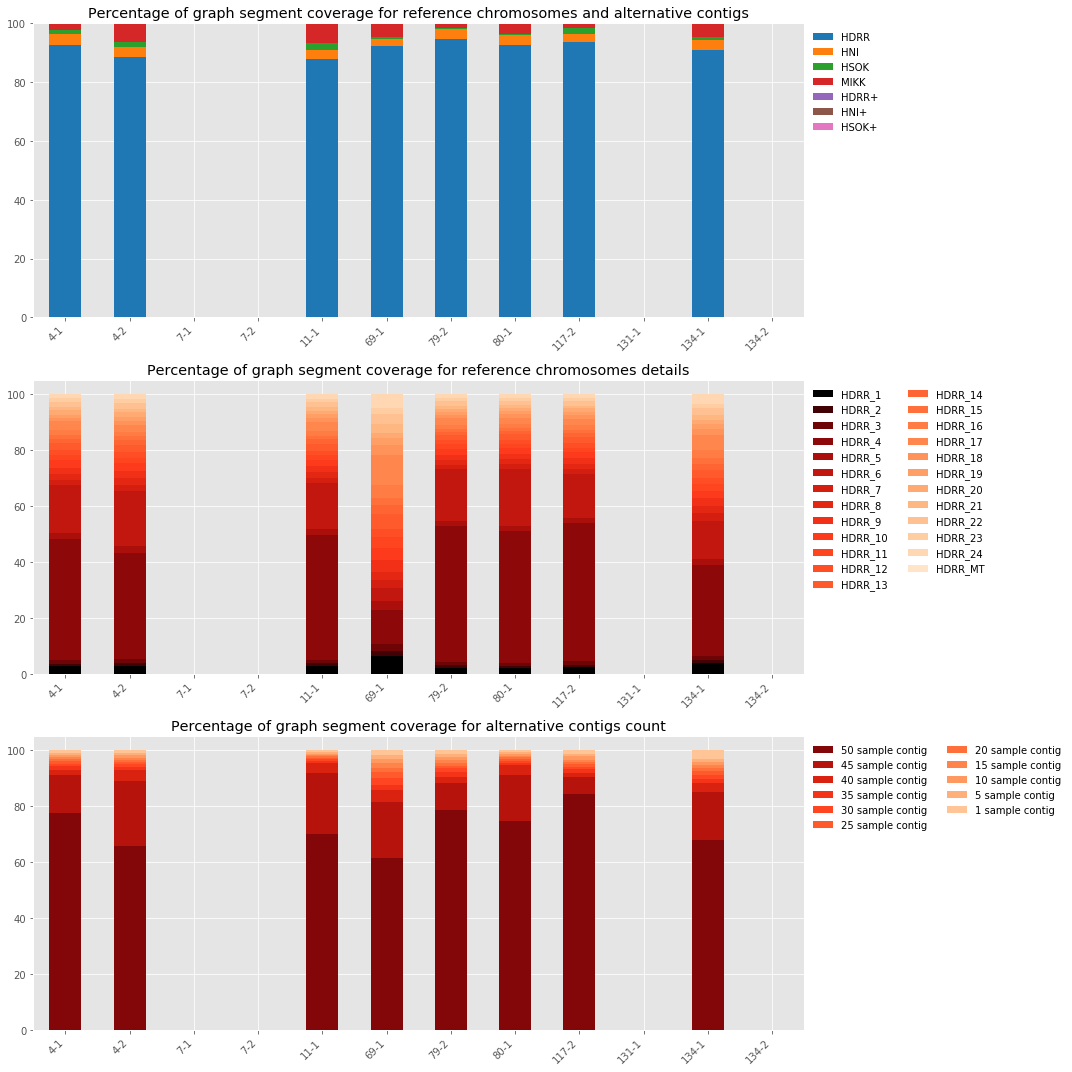

In [399]:
outdir = "segment_usage2/rna_seq"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

segment_usage_stats (
    gaf_src="./alignments2/rna_seq/*_unstable.gaf",
    graph_info_pkl="./graph_assembly/all_ref_graph_info.pkl",
    fasta_canonical_ref="./references/Oryzias_latipes_HDRR_clean.fa",
    outdir=outdir,
    n_sample_range=[50,45,40,35,30,25,20,15,10,5,1],
    min_align_len=50,
    min_mapq=1,
    min_normed_cov=0.05)

## Generate label CSV file for bandage and bedgraph file for IGV

In [124]:
def usage_annotation(segment_usage_fn, outdir, thresholds = [90, 75, 50, 25, 10]):

    segment_usage_df = pd.read_csv(segment_usage_fn, sep="\t", index_col=0)
    segment_usage_df_data = segment_usage_df.drop(columns=["chromosome","length","start","end","type","identity"])

    coord = segment_usage_df["chromosome"] + ":" + segment_usage_df["start"].astype(str) + "-" + segment_usage_df["end"].astype(str)
    segment_usage_df["coord"] = coord

    for threshold in thresholds:
        segment_usage_df[threshold] = segment_usage_df_data.ge(threshold/100).sum(axis=1)
    display(segment_usage_df.head())

    # Define colormap for bandage
    colors = [rgb2hex(i) for i in sns.color_palette('afmhot_r', len(segment_usage_df_data.columns)+1)]

    for threshold in thresholds:
        print(f"Write file for threshold {threshold}")

        # Formating for bedgraph
        bedgraph_df = segment_usage_df[["chromosome","start","end", threshold]].copy()
        bedgraph_out_fn = f"{outdir}/seg_usage_{threshold}.bedgraph"
        with open (bedgraph_out_fn, "w") as fp:
            fp.write("track type=bedGraph name=samples_pass\n")
        bedgraph_df.to_csv(bedgraph_out_fn, sep="\t", mode="a", index=False, header=False)

        # Formating for bandage
        bandage_df = segment_usage_df[[threshold,"coord","length","type","identity"]].copy()
        bandage_df.index.name = "name"
        bandage_df = bandage_df.rename(columns={threshold:"sample_pass"})
        seg_col = []
        for seg_id, n in bandage_df["sample_pass"].items():
            seg_col.append(colors[n])
        bandage_df["color"] = seg_col
        bandage_out_fn = f"{outdir}/seg_usage_{threshold}.csv"
        bandage_df.to_csv(bandage_out_fn, sep=",")

In [127]:
outdir = "segment_usage2/raw_reads_annot/"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

usage_annotation (
    segment_usage_fn = "segment_usage2/raw_reads/segment_usage_len_cov_norm.tsv",
    outdir = outdir,
    thresholds = [50, 33, 25, 10])

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/segment_usage2/raw_reads_annot


,chromosome,length,start,end,type,identity,80-1_H3,134-2_A5,131-1_F4,7-2_F2,7-1_E2,4-1_B2,69-1_F3,79-2_G3,134-1_H4,117-2_C4,11-1_A3,4-2_B2,coord,50,33,25,10
seg_id,,,,,,,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.949126,0.153746,0.148558,0.003689,0.139817,0.046945,0.318755,0.029822,0.062995,0.146057,0.080340,0.061490,0.076256,HDRR+_000617F:44100-44724,0,0,1,5
s648600,HDRR+_000617F,286,46919,47205,HDRR+,NaN,0.092561,0.282229,0.000000,0.256300,0.187779,0.139093,0.460111,0.000000,0.045431,0.189078,0.553410,0.204637,HDRR+_000617F:46919-47205,1,2,4,8
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.973289,0.264922,0.243811,0.046163,0.383681,0.308246,0.182274,0.327036,0.445939,0.238855,0.415930,0.155322,0.328525,HDRR+_000617F:50034-50631,0,3,7,11
s648602,HDRR+_000617F,284,52947,53231,HDRR+,NaN,0.103703,0.066953,0.014042,0.257649,0.200341,0.000000,0.215834,0.000000,0.000000,0.150485,0.000000,0.099750,HDRR+_000617F:52947-53231,0,0,1,5
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.997368,0.000000,0.000000,0.036640,0.004119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,HDRR+_000617F:127768-132327,0,0,0,0


Write file for threshold 50
Write file for threshold 33
Write file for threshold 25
Write file for threshold 10


In [128]:
outdir = "segment_usage2/rna_seq_annot/"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

usage_annotation (
    segment_usage_fn = "segment_usage2/rna_seq/segment_usage_len_cov_norm.tsv",
    outdir = outdir,
    thresholds = [50, 33, 25, 10])

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/segment_usage2/rna_seq_annot


,chromosome,length,start,end,type,identity,104-1,106-1,106-2,10-1,117-2,11-2,11-1,125-1,129-1,132-4-1,132-5,133-2,134-1,135-2,137-4,139-4,13-2,140-1,140-3,141-3,14-1,15-1,17-1,20-1,21-2,23-1,30-1,32-2,39-1,40-1,40-2,49-1,4-1,4-2,50-2,55-2,59-1,59-2,61-1,62-2,69-1,71-1,72-2,79-2,80-1,84-2,8-2,91-1,94-1,95-1,coord,50,33,25,10
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s648599,HDRR+_000617F,624,44100,44724,HDRR+,0.949126,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.044461,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.055107,0.05831,0.000000,0.0,0.0,0.061401,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.066301,0.0,0.0,0.0,0.0,0.0,0.0,HDRR+_000617F:44100-44724,0,0,0,0
s648600,HDRR+_000617F,286,46919,47205,HDRR+,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.233633,0.0,0.073147,0.073488,0.099385,0.0,0.0,0.0,0.100714,0.066434,0.000000,0.00000,0.000000,0.0,0.0,0.182898,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,HDRR+_000617F:46919-47205,0,0,0,3
s648601,HDRR+_000617F,597,50034,50631,HDRR+,0.973289,0.072603,0.0,0.031143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087737,0.0,0.0,0.028799,0.0,0.028523,0.061283,0.000000,0.0,0.0,0.0,0.075589,0.000000,0.000000,0.00000,0.112892,0.0,0.0,0.000000,0.0,0.0,0.039038,0.0,0.050868,0.0,0.0,0.027411,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,HDRR+_000617F:50034-50631,0,0,0,1
s648602,HDRR+_000617F,284,52947,53231,HDRR+,0.993007,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,HDRR+_000617F:52947-53231,0,0,0,0
s648603,HDRR+_000617F,4559,127768,132327,HDRR+,0.997368,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,HDRR+_000617F:127768-132327,0,0,0,0


Write file for threshold 50
Write file for threshold 33
Write file for threshold 25
Write file for threshold 10


## Find interesting alternative segments

### Segments with DNA support

In [129]:
# input files
graph_info_fn = "./graph_assembly/all_ref_graph_info.pkl"
dna_usage_fn =  "segment_usage2/raw_reads/segment_usage_len_cov_norm.tsv"

# Options
ref_type = "HDRR"
min_length = 1000
max_identity = 0.5
min_coverage_dna = 0.25
min_samples_dna = 6

# Load and filter out segments
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df.drop(columns=["component","connected"])
graph_info_df = graph_info_df[(graph_info_df["type"] != ref_type) & (graph_info_df["length"]>=min_length) & (graph_info_df["identity"]<=max_identity)]
#display(graph_info_df.head())

# Load and filter out segments
dna_usage_df = pd.read_csv(dna_usage_fn, sep="\t", index_col=0)
dna_usage_df = dna_usage_df[(dna_usage_df["type"] != ref_type) & (dna_usage_df["length"]>=min_length) & (dna_usage_df["identity"]<=max_identity)]
# Count number of samples with sufficient coverage for each segments
dna_usage_df = dna_usage_df.drop(columns=["chromosome","length","start","end","type","identity"])
dna_usage_df["samples_pass_dna"] = dna_usage_df.ge(min_coverage_dna).sum(axis=1)
dna_usage_df = dna_usage_df[dna_usage_df["samples_pass_dna"]>=min_samples_dna]

all_df = pd.merge(graph_info_df, dna_usage_df[["samples_pass_dna"]], left_index=True, right_index=True, how="inner")
all_df = all_df.sort_values(by="length", ascending=False)

print (f"Number of segments found: {len(all_df)}")
all_df.head(10)

Number of segments found: 4652


,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,connected_chromosome,connected_start,connected_end,samples_pass_dna
seg_id,,,,,,,,,,,,,
s696603,HNI_8,13281640,13431467,149827,HNI,0.042790,HDRR_8,13879668.0,13886300.0,HDRR_8,13764951.0,13874455.0,10
s692941,HNI_7,25576686,25714532,137846,HNI,0.116913,HDRR_7,26530262.0,26548725.0,HDRR_7,26407757.0,26623107.0,6
s698044,HNI_8,19898567,20016162,117595,HNI,0.232182,HDRR_8,21367488.0,21395956.0,HDRR_8,21285567.0,21427853.0,12
s986782,MIKK_117-2_C4_173,730080,819872,89792,MIKK,0.044768,HDRR_23,24126439.0,24130547.0,HDRR_17,12304622.0,12361720.0,12
s773332,HNI_21,11438218,11527520,89302,HNI,0.077448,HDRR_21,12393763.0,12401207.0,HDRR_21,12039146.0,12041847.0,12
s703709,HNI_9,3377111,3457909,80798,HNI,0.028179,HDRR_9,3928263.0,3930623.0,HDRR_9,3927794.0,3957463.0,9
s756355,HNI_18,6405868,6483868,78000,HNI,0.298350,HDRR_18,7264171.0,7288843.0,HDRR_18,7150507.0,7327339.0,12
s804651,HSOK_2,3071587,3149466,77879,HSOK,0.261677,HDRR_12,21545208.0,21568235.0,HDRR_2,3412101.0,3412362.0,11
s797542,HSOK_1,3936731,4009525,72794,HSOK,0.084120,HDRR_1,4209081.0,4215436.0,HDRR_1,4208927.0,4337200.0,8


### Segments with both DNA and RNA support

In [130]:
# input files
graph_info_fn = "./graph_assembly/all_ref_graph_info.pkl"
dna_usage_fn =  "segment_usage2/raw_reads/segment_usage_len_cov_norm.tsv"
rna_usage_fn =  "segment_usage2/rna_seq/segment_usage_len_cov_norm.tsv"

# Options
ref_type = "HDRR"
min_length = 1000
max_identity = 0.5
min_coverage_dna = 0.25
min_samples_dna = 6
min_coverage_rna = 0.25
min_samples_rna = 25

# Load and filter out segments
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df.drop(columns=["component","connected"])
graph_info_df = graph_info_df[(graph_info_df["type"] != ref_type) & (graph_info_df["length"]>=min_length) & (graph_info_df["identity"]<=max_identity)]

# Load and filter out segments
dna_usage_df = pd.read_csv(dna_usage_fn, sep="\t", index_col=0)
dna_usage_df = dna_usage_df[(dna_usage_df["type"] != ref_type) & (dna_usage_df["length"]>=min_length) & (dna_usage_df["identity"]<=max_identity)]
# Count number of samples with sufficient coverage for each segments
dna_usage_df = dna_usage_df.drop(columns=["chromosome","length","start","end","type","identity"])
dna_usage_df["samples_pass_dna"] = dna_usage_df.ge(min_coverage_dna).sum(axis=1)
dna_usage_df = dna_usage_df[dna_usage_df["samples_pass_dna"]>=min_samples_dna]

# Load and filter out segments
rna_usage_df = pd.read_csv(rna_usage_fn, sep="\t", index_col=0)
rna_usage_df = rna_usage_df[(rna_usage_df["type"] != ref_type) & (rna_usage_df["length"]>=min_length) & (rna_usage_df["identity"]<=max_identity)]
# Count number of samples with sufficient coverage for each segments
rna_usage_df = rna_usage_df.drop(columns=["chromosome","length","start","end","type","identity"])
rna_usage_df["samples_pass_rna"] = rna_usage_df.ge(min_coverage_rna).sum(axis=1)
rna_usage_df = rna_usage_df[rna_usage_df["samples_pass_rna"]>=min_samples_rna]

usage_df = pd.merge(dna_usage_df[["samples_pass_dna"]], rna_usage_df[["samples_pass_rna"]], left_index=True, right_index=True, how="inner")
all_df = pd.merge(graph_info_df, usage_df, left_index=True, right_index=True, how="inner")
all_df = all_df.sort_values(by="length", ascending=False)

print (f"Number of segments found: {len(all_df)}")
all_df.head(10)

Number of segments found: 128


,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,connected_chromosome,connected_start,connected_end,samples_pass_dna,samples_pass_rna
seg_id,,,,,,,,,,,,,,
s1081977,MIKK_80-1_H3_395,473445,498354,24909,MIKK,0.129850,HDRR_11,7014918.0,7018651.0,HDRR_11,24052269.0,24061855.0,12,49
s675774,HNI_5,4983943,5005634,21691,HNI,0.233289,HDRR_10,9982877.0,9988268.0,HDRR_5,5075836.0,5101956.0,8,50
s992562,MIKK_117-2_C4_380,272323,291952,19629,MIKK,0.151084,HDRR_5,8355040.0,8358172.0,HDRR_11,2928816.0,2949385.0,10,50
s712659,HNI_11,8943286,8960621,17335,HNI,0.224441,HDRR_11,20642643.0,20647949.0,HDRR_11,20638485.0,20643966.0,12,50
s1068021,MIKK_134-1_H4_88,201260,216372,15112,MIKK,0.495814,HDRR_8,1162265.0,1170381.0,HDRR_3,15005052.0,15008935.0,12,40
s959032,MIKK_131-1_F4_129,560714,574868,14154,MIKK,0.423670,HDRR_20,10411651.0,10418366.0,HDRR_20,10403988.0,10560932.0,12,50
s675800,HNI_5,5026725,5038858,12133,HNI,0.190508,HDRR_16,2355576.0,2358022.0,HDRR_5,5075836.0,5101956.0,10,50
s759252,HNI_18,25584303,25595537,11234,HNI,0.160527,HDRR_1,18659276.0,18661118.0,HDRR_18,28549285.0,28581606.0,12,28
s993534,MIKK_117-2_C4_432,269898,280266,10368,MIKK,0.496845,HDRR_16,7714347.0,7719668.0,HDRR_14,4172544.0,4177254.0,11,49


In [35]:
all_fa_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa"
fa_out_fn = "./segment_usage/divergent_insertions.fa"

with pyfaidx.Fasta(all_fa_ref) as fa_in, open (fa_out_fn, "w") as fa_out:
    for seg, line in usage_align_df.iterrows():
        header=f"{seg}|length:{line.length}|n_sample:{line.samples_pass_threshold}|ref_identity:{round(line.identity, 5)}|hit_coord:{line.hit_ref}:{line.hit_start}-{line.hit_end}"
        seq = str(fa_in[line.chromosome][line.start:line.end])
        fa_out.write(f">{header}\n{seq}\n")
        
head(fa_out_fn, max_char_col=200, max_char_line=200)
print (os.path.abspath(fa_out_fn))

>s306556|length:10790|n_sample:12|ref_identity:0.01194|hit_coord:21:20530431-20530585                                                                                                                   ...
TTTCTCAAGTGCAGCATTGTATGTATGTGATCAATGTGAACACCAGATGGGCCAATTATCCAACTTTGCCCTTACCCTTCTCCATTAGCCTTAATGCTCATTTTAAGGTGTCCACCAGCTGAAATACTCAACATAATAGTGTCAAAAGTTTTAAAATTATACCATTAATAATTATGTCAAAAGGTACTGAAGCAAAGACC...
>s334181|length:13314|n_sample:12|ref_identity:0.01494|hit_coord:14:12750965-12751173                                                                                                                   ...
ATATCTTAGTACAAGTTGACCCATTTTTATAAATCCTTACAAAATCTAAAGCTAGAACTTTTTCTTAGAACATAAATCAAAATTTTTGTTTACAAAATAATGACAATGAATGTTAGCATTGTGATTGTCAATATTAATTGAAAATTAAAATAAGATCCTTAAAATTGAACTTCAAATAAGTGAGCAATTTGAGTTTTTCT...
>s315497|length:10617|n_sample:12|ref_identity:0.01683|hit_coord:9:25111355-25111586                                                                                                    

# Link Usage analysis

In [43]:
outdir = "link_usage"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/link_usage


## Define parsing function

In [ ]:
def gaf_link_coverage (gaf_fn, graph_info_dict, min_align_len=100, min_mapq=10, progress=True):
    seg_cov_dict = Counter()
    info_counter = Counter()
    
    with open (gaf_fn) as gaf_fp:
        for line in tqdm(gaf_fp, disable=not progress):
            line = line.strip().split("\t")
            path_str = line[5]
            seg_list = re.split('<|>',path_str[1:])
            start = int(line[7])
            end = int(line[8])
            align_len = int(line[10])
            mapq = int(line[11])
            align_type = line[12].split(":")[-1]
            
            if align_len < min_align_len:
                info_counter["short length alignments"]+=1
            elif mapq < min_mapq:
                info_counter["low mapq alignments"]+=1
            elif align_type != "P":
                info_counter["non primary alignments"]+=1
            elif len(seg_list) == 1:
                info_counter["Single segment alignments"]+=1
            else:
                info_counter["Multi segment alignments"]+=1 ######################################################################################################
                all_seg_len = 0
                
                # First segment exception
                seg = seg_list[0]
                seg_len = graph_info_dict[seg]["length"]
                all_seg_len+=seg_len
                seg_cov_dict[seg] += seg_len-start

                # Internal segments
                for seg in seg_list[1:-1]:
                    seg_len = graph_info_dict[seg]["length"]
                    all_seg_len+=seg_len
                    seg_cov_dict[seg] += seg_len

                # Last segment exception
                seg = seg_list[-1]
                seg_len = graph_info_dict[seg]["length"]
                all_seg_len+=seg_len
                seg_cov_dict[seg] += seg_len-(all_seg_len-end)
    
    return seg_cov_dict, info_counter

In [319]:
def parse_gfa_link (gfa_fn, fasta_canonical_ref, outdir, progress=True):
    
    stdout_print("Get list of reference chromosome\n")
    ref_chrom_l=[]
    with pyfaidx.Fasta(fasta_canonical_ref) as fa:
        ref_chrom_l = [s.name for s in fa]
    
    stdout_print("Parsing reference graph\n")
    
    seg_d = OrderedDict()
    link_d = OrderedDict()
    f_jump_list = []
    b_jump_list = []
        
    with open (gfa_fn) as fp:
        for l in tqdm(fp, disable=not progress):
            l = l.strip().split("\t")
            if l[0] == "S":
                seg = l[1]
                chromosome = l[4].split(":")[-1]
                length = int(l[3].split(":")[-1])
                start = int(l[5].split(":")[-1])
                end = start+length
                category = "Ref" if chromosome in ref_chrom_l else "Alt"
                seg_d[seg] = {"chromosome":chromosome, "length":length, "start":start, "end":end, "category":category}
            
            if l[0] == "L":
                seg1 = l[1]
                seg1_orient = l[2]
                seg2 = l[3]
                seg2_orient = l[4]
                seg1_info = seg_d[seg1]
                seg2_info = seg_d[seg2]
                
                if seg1_info["category"] == "Ref" and seg2_info["category"] == "Ref":
                    if seg1_info["chromosome"] == seg2_info["chromosome"]:
                        diff = seg2_info["start"]-seg1_info["end"]
                        if diff == 0:
                            category = "Intra-Ref_continuous"
                        elif diff < 0:
                            category = "Intra-Ref_backward_jump"
                            b_jump_list.append(-diff)
                        else:
                            category = "Intra-Ref_forward_jump"
                            f_jump_list.append(diff)            
                    else:
                        category = "Inter-Ref"
                                    
                elif seg1_info["category"] == "Ref":
                    category = "Ref-Alt"
                    
                elif seg2_info["category"] == "Ref":
                    category = "Alt-Ref"
                
                else:
                    if seg1_info["chromosome"] == seg2_info["chromosome"]:
                        diff = seg2_info["start"]-seg1_info["end"]
                        if diff == 0:
                            category = "Intra-Alt_continuous"
                        elif diff < 0:
                            category = "Intra-Alt_backward_jump"
                            b_jump_list.append(-diff)
                        else:
                            category = "Intra-Alt_forward_jump"
                            f_jump_list.append(diff)        
                    else:
                        category = "Inter-Alt"
                
                link_d[(seg1, seg2, seg1_orient, seg2_orient)] = category
                
    df = pd.DataFrame.from_dict(link_d, orient="index", columns=["Category"])
    display(df["Category"].value_counts().to_frame())
    
                
    with pl.style.context('ggplot'):
        fig, ax = pl.subplots(figsize=(25 ,10))

        y, x = np.histogram(f_jump_list, np.logspace(2,5, num=100))
        y = gaussian_filter1d(y, sigma=2)
        ax.fill_betweenx(x1 = x[:-1],y=y, label='Forward Jump', alpha=0.5, color="steelblue")

        y, x = np.histogram(b_jump_list, np.logspace(2,5, num=100))
        y = gaussian_filter1d(y, sigma=2)
        ax.fill_betweenx(x1 = x[:-1],y=y, label= 'Backward Jump', alpha=0.5, color="orangered")

        ax.set_xscale('log')
        ax.set_xlabel('Length in bases')
        ax.set_ylabel('Junctions density')
        ax.set_xlim(1e2, 1e5)
        ax.set_ylim(0, None)
        ax.legend(bbox_to_anchor=(1, 1), loc=2, facecolor='white', frameon=False)
        ax.set_title("Length of jump between 2 segments mapped on the same contig of the graph")

    return link_d

## Parse Graph and annotate link types

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/link_usage/graph_link_type
Get list of reference chromosome
Parsing reference graph


1265673it [00:13, 92740.16it/s] 


,Category
Intra-Ref_continuous,306234
Alt-Ref,169934
Ref-Alt,169705
Inter-Alt,41442
Intra-Alt_continuous,37325
Intra-Ref_forward_jump,3618
Intra-Ref_backward_jump,3266
Intra-Alt_backward_jump,119
Intra-Alt_forward_jump,94


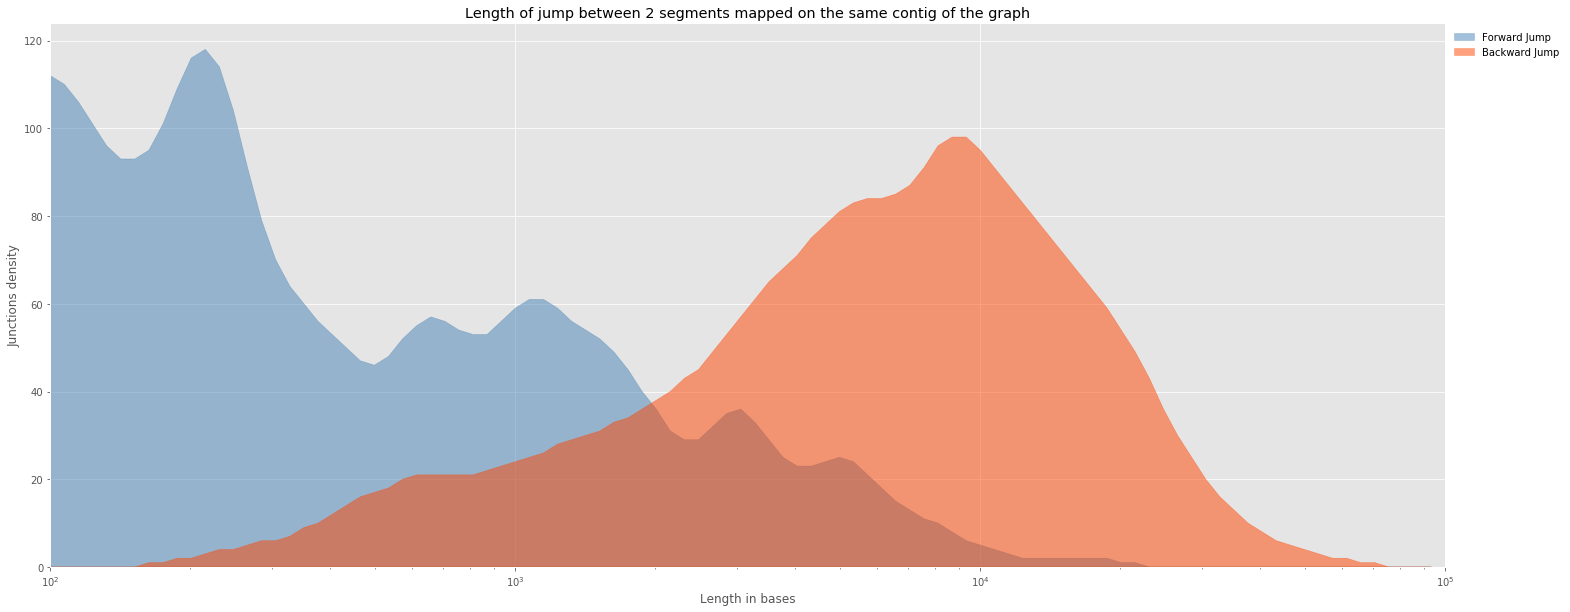

In [284]:
outdir = "link_usage/graph_link_type"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

parse_gfa_link(
    gfa_fn="./graph_assembly/matchpen_3.gfa", 
    fasta_canonical_ref="./references/Oryzias_latipes_clean.fa",
    outdir=outdir)

## Parse junctions from alignments

In [324]:
def split_path (path):
    l = []
    seg_id = ""
    strand = ""
    for c in path:
        if c in ["<", ">"]:
            if seg_id:
                l.append((seg_id, strand))
            seg_id = ""
            strand = "+" if c == ">" else "-"
        else:
            seg_id +=c

    l.append((seg_id, strand))
    return l

def gaf_link_coverage (gaf_fn, min_align_len=100, min_mapq=1, progress=True):
    link_usage_dict = Counter()
    info_counter = Counter()
    
    with open (gaf_fn) as gaf_fp:
        for line in tqdm(gaf_fp, disable=not progress):
            line = line.strip().split("\t")
            seg_list = split_path(line[5])
            align_len = int(line[10])
            mapq = int(line[11])
            align_type = line[12].split(":")[-1]
            
            if align_len < min_align_len:
                info_counter["short length alignments"]+=1
            elif mapq < min_mapq:
                info_counter["low mapq alignments"]+=1
            elif align_type != "P":
                info_counter["non primary alignments"]+=1
            elif len(seg_list) == 1:
                info_counter["single segment path"]+=1
            else:
                info_counter["multi segment path"]+=1
                prev_seg = seg_list[0]
                for seg in seg_list[1:]:
                    info_counter["links"]+=1
                    #link_id = f"{prev_seg[0]}_{prev_seg[1]}_{seg[0]}_{seg[1]}"
                    link_id = (prev_seg[0], prev_seg[1], seg[0], seg[1])
                    link_usage_dict[link_id]+=1
                    prev_seg=seg
                    
    return link_usage_dict, info_counter

def parse_gfa_segment (gfa_fn, fasta_canonical_ref, progress=True):
    ref_chrom_l=[]
    with pyfaidx.Fasta(fasta_canonical_ref) as fa:
        ref_chrom_l = [s.name for s in fa]
    seg_d = OrderedDict()
    
    with open (gfa_fn) as fp:
        for l in tqdm(fp, disable=not progress):
            l = l.strip().split("\t")
            if l[0] == "S":
                seg = l[1]
                chromosome = l[4].split(":")[-1]
                length = int(l[3].split(":")[-1])
                start = int(l[5].split(":")[-1])
                end = start+length
                category = "Ref" if chromosome in ref_chrom_l else "Alt"
                seg_d[seg] = {"chromosome":chromosome, "length":length, "start":start, "end":end, "category":category}
            if l[0] == "L":
                break
    
    return seg_d

def link_usage_stats (gaf_src, graph_link_fn, gfa_fn, fasta_canonical_ref, outdir, min_align_len=100, min_mapq=10):

    all_link = OrderedDict()
    all_info = OrderedDict()
    
    stdout_print("Parsing gaf files\n")
    for gaf_fn in glob.glob(gaf_src):
        sample_id = gaf_fn.split("/")[-1].rpartition("_")[0]
        stdout_print(f"\tParsing data for sample {sample_id}\n")
        link_dict, info_counter = gaf_link_coverage (gaf_fn=gaf_fn, min_align_len=min_align_len, min_mapq=min_mapq, progress=False)
        all_link[sample_id] = link_dict
        all_info[sample_id] = info_counter
        
    info_df = pd.DataFrame(all_info)
    display(info_df)
    
    stdout_print("Cast link usage data to DataFrame\n")
    all_link_df = pd.DataFrame(all_link)
    all_link_df = all_link_df.fillna(0)
    all_link_df = all_link_df.astype(np.int64)
    all_link_df["sum"] = all_link_df.sum(axis=1)
    all_link_df = all_link_df.sort_values("sum", ascending=False) 
    
    stdout_print("Parse GFA segments\n")
    seg_d = parse_gfa_segment (gfa_fn=gfa_fn, fasta_canonical_ref=fasta_canonical_ref, progress=False):
    
    stdout_print("Annotate links\n")
    link_type = []
        
    
    
#     stdout_print("Loading graph link info and merge with data\n")
#     graph_link_df = pd.read_csv(graph_link_fn, sep="\t", index_col=0)
    
#     all_link_df = pd.merge(left=graph_link_df, right=all_link_df, left_index=True, right_index=True, how="right")
#     display(all_link_df)
    
    
#     out_fn = os.path.join(outdir, "segment_usage.tsv")
#     cov_df.to_csv(out_fn, sep="\t")
    

In [371]:
for s1_id, s1_strand, s2_id, s2_strand in all_link_df.index:
    print(s1_id, s1_strand, s2_id, s2_strand)

s22139 + s22140 +
s22140 - s22139 -
s22140 + s22141 +
s157014 - s157013 -
s22141 - s22140 -
s217706 + s437594 -
s437594 - s217708 +
s22138 + s22139 +
s157016 - s157015 -
s157015 - s157014 -
s157017 - s157016 -
s19705 - s19704 -
s46700 + s46701 +
s285189 + s285190 +
s8906 - s340437 -
s340437 - s8903 -
s20244 - s20243 -
s202406 - s202405 -
s22533 + s22534 +
s110615 + s110616 +
s237861 - s237860 -
s8899 - s454228 +
s237862 - s237861 -
s454228 + s8897 -
s353241 - s30215 -
s353242 - s353241 -
s467777 - s30515 +
s8901 - s8900 -
s8900 - s8899 -
s285190 + s285191 +
s213029 - s213027 -
s362411 - s13934 +
s13933 + s362411 -
s265119 - s265118 -
s117951 - s117950 -
s157014 + s157015 +
s387877 - s387876 -
s20241 - s518609 +
s391767 + s391768 +
s92902 + s92903 +
s44961 - s345240 -
s216931 + s216932 +
s391766 + s391767 +
s109331 - s109330 -
s149498 + s149499 +
s22119 + s22120 +
s22585 - s22584 -
s265667 + s265668 +
s30517 + s467775 -
s177358 + s177359 +
s292507 - s292506 -
s166089 - s166088 -
s117950

s127242 + s127243 +
s127235 + s127236 +
s185028 + s185029 +
s185023 + s185024 +
s45737 + s45738 +
s45736 + s45737 +
s33495 - s33494 -
s33496 - s33495 -
s320592 - s33498 -
s33500 - s320592 -
s320593 - s33500 -
s33502 - s320593 -
s320594 - s33502 -
s33507 - s33506 -
s33512 - s33511 -
s33515 - s33514 -
s45705 + s45706 +
s45704 + s45705 +
s33518 - s33517 -
s320597 - s33518 -
s320598 - s320597 -
s33520 - s320598 -
s33521 - s33520 -
s33522 - s33521 -
s33523 - s33522 -
s323260 - s127206 +
s127210 + s127211 +
s127217 + s127218 +
s185020 + s185021 +
s127221 + s127222 +
s127224 + s127225 +
s139774 + s139775 +
s55350 + s55351 +
s55351 + s315070 +
s55409 + s55410 +
s315097 + s384383 +
s55417 + s315097 +
s55416 + s55417 +
s55415 + s55416 +
s315096 + s55415 +
s315095 + s315096 +
s55413 + s315095 +
s55412 + s55413 +
s55411 + s55412 +
s12755 + s12756 +
s12752 + s12753 +
s12751 + s12752 +
s55410 + s55411 +
s55408 + s55409 +
s315070 + s55352 +
s34330 - s34329 -
s55405 + s55406 +
s34334 - s34333 -
s34335

s218148 - s218147 -
s185331 + s349186 -
s218369 - s218368 -
s185291 + s185292 +
s185290 + s185291 +
s218383 - s366547 -
s366547 - s218381 -
s218381 - s366546 -
s349201 - s185282 +
s185280 + s349201 -
s366546 - s218379 -
s218379 - s218377 -
s218377 - s366545 -
s366545 - s218375 -
s218373 - s479688 +
s479688 + s218371 -
s218371 - s218369 -
s218368 - s218367 -
s349198 - s185294 +
s218367 - s218366 -
s218366 - s218365 -
s364082 + s218356 -
s218356 - s364083 +
s364083 + s218354 -
s364085 + s218351 -
s218346 - s382328 +
s290276 + s290278 +
s290275 + s290276 +
s290274 + s290275 +
s382332 + s364088 +
s364088 + s218336 -
s218336 - s218335 -
s218335 - s218334 -
s185292 + s349198 -
s366548 - s218385 -
s364089 + s218333 -
s185315 + s427088 -
s185328 + s185329 +
s218425 - s218424 -
s218424 - s218423 -
s218423 - s347135 -
s185324 + s185325 +
s75960 + s75961 +
s185323 + s185324 +
s185322 + s185323 +
s347135 - s218421 -
s218419 - s347133 -
s349188 - s185318 +
s427086 - s349188 -
s447964 + s427086 -
s4

s45016 - s45015 -
s45015 - s45014 -
s247026 + s487243 +
s487243 + s372262 +
s280146 + s280147 +
s45012 - s45011 -
s372264 + s247029 +
s45009 - s345250 -
s345250 - s45007 -
s280133 + s280134 +
s154206 - s154205 -
s345247 - s44979 -
s44979 - s44978 -
s280130 + s280131 +
s280129 + s280130 +
s44975 - s44974 -
s280124 + s280125 +
s22995 - s22994 -
s280121 + s280122 +
s280120 + s280121 +
s394406 + s280120 +
s280118 + s394406 +
s44964 - s44963 -
s280109 + s280110 +
s280108 + s280109 +
s394408 + s326927 -
s326927 - s280154 +
s280166 + s280167 +
s246990 + s246991 +
s45025 - s45024 -
s45024 - s45022 -
s45022 - s45021 -
s246979 + s246980 +
s246980 + s246981 +
s246981 + s246982 +
s246982 + s246983 +
s246983 + s246984 +
s246984 + s246985 +
s246985 + s246986 +
s246986 + s246987 +
s246987 + s246988 +
s246988 + s246989 +
s246989 + s246990 +
s246991 + s246992 +
s280154 + s326926 -
s246992 + s246993 +
s246993 + s246994 +
s280162 + s280163 +
s314610 - s107170 +
s247006 + s247007 +
s247007 + s247008 +
s24

s59327 + s59328 +
s403454 + s359253 -
s359253 - s99735 -
s132000 - s479341 +
s59333 + s315975 -
s99735 - s359252 -
s315975 - s59335 +
s359252 - s99733 -
s99730 - s99729 -
s99729 - s99728 -
s99728 - s99726 -
s99726 - s99725 -
s318442 - s132006 -
s132008 - s318442 -
s59345 + s315972 -
s19330 + s442719 +
s442718 + s19330 +
s19328 + s442718 +
s315963 - s59381 +
s59381 + s405672 +
s405672 + s59383 +
s59237 + s315996 -
s264165 + s264166 +
s465687 - s22124 +
s22122 + s465687 -
s465688 - s22122 +
s22117 + s22118 +
s22116 + s22117 +
s86510 + s86511 +
s86511 + s86513 +
s308297 + s264159 +
s264157 + s308297 +
s264156 + s264157 +
s393723 + s393724 +
s393724 + s393725 +
s86517 + s86518 +
s86518 + s86519 +
s264151 + s264152 +
s86526 + s86527 +
s86529 + s86530 +
s264148 + s264149 +
s86556 + s86557 +
s86557 + s86558 +
s264145 + s264146 +
s308288 + s264145 +
s264143 + s308288 +
s86565 + s86566 +
s86566 + s86567 +
s264140 + s264141 +
s264138 + s264140 +
s264137 + s264138 +
s264166 + s264167 +
s315996 - 

s186991 + s364854 +
s78028 + s346149 +
s364854 + s186993 +
s296985 - s296984 -
s296984 - s358412 -
s358412 - s296982 -
s296982 - s296981 -
s296981 - s296980 -
s296980 - s422594 +
s422594 + s296978 -
s296978 - s296977 -
s346149 + s78030 +
s78030 + s78031 +
s78031 + s389650 +
s296977 - s296976 -
s296976 - s296975 -
s137709 - s137708 -
s296972 - s296971 -
s296971 - s296970 -
s20242 + s20243 +
s98411 - s98410 -
s98410 - s98409 -
s105789 + s105790 +
s217731 + s217732 +
s290646 - s290645 -
s290647 - s290646 -
s290648 - s290647 -
s290649 - s290648 -
s163149 - s163148 -
s201656 + s201657 +
s277622 + s329864 -
s329864 - s277623 +
s250210 + s414840 +
s250207 + s250208 +
s260218 + s260219 +
s12837 + s12838 +
s284441 - s284440 -
s284442 - s284441 -
s284443 - s284442 -
s284444 - s284443 -
s284445 - s284444 -
s352988 - s284445 -
s284447 - s352988 -
s386137 + s12844 +
s284451 - s284450 -
s284452 - s284451 -
s12841 + s386137 +
s12840 + s12841 +
s12839 + s12840 +
s12838 + s12839 +
s284474 - s284473 -
s

KeyboardInterrupt: 

## Assemblies

In [325]:
outdir = "link_usage/assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

all_link_df = link_usage_stats (
    gaf_src="./alignments/assemblies/1*_unstable.gaf",
    graph_link_fn="./link_usage/graph_link_type/link_types.tsv",
    outdir=outdir,
    min_align_len=100,
    min_mapq=1)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/link_usage/assemblies
Parsing gaf files
	Parsing data for sample 11-1_A3
	Parsing data for sample 134-1_H4
	Parsing data for sample 134-2_A5
	Parsing data for sample 117-2_C4
	Parsing data for sample 131-1_F4


,11-1_A3,134-1_H4,134-2_A5,117-2_C4,131-1_F4
multi segment path,2731,2730,3598,2477,3118
links,285991,295368,298943,302498,284992
single segment path,1697,1952,2090,1986,2277
low mapq alignments,25,32,41,41,40


Cast link usage data to DataFrame


# Node Usage analysis

## Define parsing function

In [143]:
def split_path (path):
    l = []
    s = ""
    for c in path:
        if s and c in ["<", ">"]:
            l.append(s)
            s = c
        else:
            s+=c
    if s:
        l.append(s)
    return l

def stable_coord_split (l):
    coord=namedtuple("coord", ["chromosome", "start", "end", "strand"])
    
    l2 = []
    for coord_str in l:
        chromosome, start_end = coord_str[1:].split(":")
        start, end = (start_end.split("-"))
        start = int(start)
        end = int(end)
        strand = "+" if coord_str[0] == ">" else "-"
        l2.append(coord(chromosome, start, end, strand))
    return l2

def parse_stable_gaf_link (gaf_fn, min_align_len=100, min_mapq=1, progress=True):
    link_dict = Counter()
    info_counter = Counter()
    
    with open (gaf_fn) as gaf_fp:       
        for line in tqdm(gaf_fp, disable=not progress):
            line = line.strip().split("\t")

            align_len = int(line[10])
            mapq = int(line[11])
            align_type = line[12].split(":")[-1]
            
            if align_len < min_align_len:
                info_counter["short length alignments"]+=1
                continue
            if mapq < min_mapq:
                info_counter["low mapq alignments"]+=1
                continue
            if align_type != "P":
                info_counter["non primary alignments"]+=1
                continue

            path_list = split_path(line[5])
            if len(path_list) == 1:
                info_counter["single segment path"]+=1
            else:
                info_counter["multi segment path"]+=1
                coord_list = stable_coord_split (path_list)
                
                prev_seg = coord_list[0]
                for next_seg in coord_list[1:]:
                    info_counter["links"]+=1
                    prev_pos = prev_seg.end if prev_seg.strand == "+" else prev_seg.start
                    next_pos = next_seg.start if next_seg.strand == "+" else next_seg.end
                    link_id = (prev_seg.chromosome, prev_pos, prev_seg.strand, next_seg.chromosome, next_pos, next_seg.strand)
                    link_dict[link_id]+=1
                    
                    #Update prev segment
                    prev_seg = next_seg

    return link_dict, info_counter

def annotate_breakpoints (link_list, fasta_canonical_ref, progress=True):
    ref_chrom_l=[]   
    with pyfaidx.Fasta(fasta_canonical_ref) as fa:
        ref_chrom_l = [s.name for s in fa]
    
    
    breakpoint_l = []
    breakpoint_info = namedtuple("breakpoint_info", ["breakpoint_type", "SV_type", "breakpoint_length"])
    
    for s1_chromosome, s1_pos, s1_strand, s2_chromosome, s2_pos, s2_strand in tqdm (link_list, disable=not progress):
        
        if s1_chromosome == s2_chromosome:
            if s1_chromosome in ref_chrom_l:
                breakpoint_type = "intra_ref"
            else:
                breakpoint_type = "intra_alt"
            
            if s1_strand == s2_strand:
                # Define distance between breakpoints
                if s1_strand == "+":
                    breakpoint_length = s2_pos-s1_pos
                else:
                    breakpoint_length = s1_pos-s2_pos
                # Define type of breakpoint
                if breakpoint_length==0:
                    SV_type = "continuous"
                elif breakpoint_length>0:
                    SV_type = "deletion"
                else:
                    SV_type = "duplication"
            else:
                # Define distance between breakpoints
                if s1_strand == "+":
                    breakpoint_length = s2_pos-s1_pos
                else:
                    breakpoint_length = s1_pos-s2_pos
                SV_type = "invertion"
                
#                 if breakpoint_length==0:
#                     SV_type = "continuous invertion"
#                 else:
#                     SV_type = "distal invertion"
                
        elif s1_chromosome in ref_chrom_l and s2_chromosome in ref_chrom_l:
            breakpoint_type = "ref_to_ref"
            SV_type = "translocation"
        elif s1_chromosome in ref_chrom_l:
            breakpoint_type = "ref_to_alt"
            SV_type = "insertion"
            breakpoint_length=0
        elif s2_chromosome in ref_chrom_l:
            breakpoint_type = "alt_to_ref"
            SV_type = "insertion"
            breakpoint_length=0
        else:
            breakpoint_type = "alt_to_alt"
            SV_type = "insertion"
            breakpoint_length=0
        
        breakpoint_l.append(breakpoint_info(breakpoint_type, SV_type, breakpoint_length))
    
    return pd.DataFrame(breakpoint_l)
        
def link_usage_stable (gaf_src, fasta_canonical_ref, min_align_len=100, min_mapq=1):
    all_link = OrderedDict()
    all_info = OrderedDict()
    
    stdout_print("Parsing gaf files\n")
    sample_id_list = []
    for gaf_fn in glob.glob(gaf_src):
        sample_id = gaf_fn.split("/")[-1].rpartition("_")[0]
        sample_id_list.append(sample_id)
        stdout_print(f"\tParsing data for sample {sample_id}\n")
        link_dict, info_counter = parse_stable_gaf_link (gaf_fn=gaf_fn, min_align_len=min_align_len, min_mapq=min_mapq, progress=False)
        all_link[sample_id] = link_dict
        all_info[sample_id] = info_counter
           
    info_df = pd.DataFrame(all_info)
    display(info_df)
    
    stdout_print("Cast link usage data to DataFrame\n")
    all_link_df = pd.DataFrame(all_link)
    all_link_df.index.names = ["s1_chromosome", "s1_position", "s1_orient", "s2_chromosome", "s2_position", "s2_orient"]

    all_link_df = all_link_df.fillna(0)
    all_link_df = all_link_df.astype(np.int64)
    all_link_df["total"] = all_link_df.gt(0).sum(axis=1)
    #all_link_df["total"] = all_link_df.sum(axis=1)
    all_link_df = all_link_df.sort_values("total", ascending=False)
    
    stdout_print("Annotate link\n")
    breakpoint_df = annotate_breakpoints (link_list=all_link_df.index, fasta_canonical_ref=fasta_canonical_ref, progress=True)
    breakpoint_df.index = all_link_df.index
    all_link_df = pd.concat([all_link_df, breakpoint_df], axis=1)

    breakpoint_type_dict = OrderedDict()
    intra_ref_dict = OrderedDict()

    for sample_id in sample_id_list:
        sdf = all_link_df[[sample_id,"total","breakpoint_type","SV_type","breakpoint_length"]]
        sdf = sdf[sdf[sample_id]>0]
        breakpoint_type_dict[sample_id] = sdf["breakpoint_type"].value_counts()

        sdf = sdf[sdf["breakpoint_type"]=="intra_ref"]
        intra_ref_dict[sample_id] = sdf["SV_type"].value_counts()

    breakpoint_type_df = pd.DataFrame.from_dict(breakpoint_type_dict, orient="index")
    intra_ref_df = pd.DataFrame.from_dict(intra_ref_dict, orient="index")

    with pl.style.context("ggplot"):
            fig, axes = pl.subplots(1, 2, figsize=(25,10))

            for i, (df, label, palette) in enumerate((
                (breakpoint_type_df, "Breakpoints per type of contigs connected", "Set2"),
                (intra_ref_df, "Types of intra-molecular breakpoints", "Set2"))):

                ax = axes[i]
                df.plot.bar(stacked=True, ax=ax, cmap=palette, table=True)
                ax.set_title(f"{label}")
                ax.legend(bbox_to_anchor=(1, 1), loc=2, facecolor="white", frameon=False)
                ax.set_xticks([], [])

            fig.tight_layout()
    return all_link_df



Parsing gaf files
	Parsing data for sample 11-1_A3
	Parsing data for sample 7-1_E2
	Parsing data for sample 80-1_H3
	Parsing data for sample 134-1_H4
	Parsing data for sample 79-2_G3
	Parsing data for sample 134-2_A5
	Parsing data for sample 4-1_B2
	Parsing data for sample 7-2_F2
	Parsing data for sample 4-2_B2
	Parsing data for sample 117-2_C4
	Parsing data for sample 131-1_F4
	Parsing data for sample 69-1_F3


,11-1_A3,7-1_E2,80-1_H3,134-1_H4,79-2_G3,134-2_A5,4-1_B2,7-2_F2,4-2_B2,117-2_C4,131-1_F4,69-1_F3
multi segment path,2396,1947,3337,2284,2170,3056,2073,2011,1795,2014,2494,2177
links,121044,119210,122485,118441,117802,116279,118266,117060,117652,114956,125388,112866
single segment path,2032,2406,1856,2398,2168,2632,2256,2271,2384,2449,2901,2036
low mapq alignments,25,35,20,32,29,41,27,37,44,41,40,32


Cast link usage data to DataFrame
Annotate link


100%|██████████| 549972/549972 [00:04<00:00, 124827.90it/s]


,,,,,,11-1_A3,7-1_E2,80-1_H3,134-1_H4,79-2_G3,134-2_A5,4-1_B2,7-2_F2,4-2_B2,117-2_C4,131-1_F4,69-1_F3,total,breakpoint_type,SV_type,breakpoint_length
s1_chromosome,s1_position,s1_orient,s2_chromosome,s2_position,s2_orient,,,,,,,,,,,,,,,,
ctg129_11-1_A3,784686,+,5,2022695,-,1,0,0,0,0,0,0,0,0,0,0,0,1,alt_to_ref,insertion,0
ctg36_7-2_F2,577786,-,3,9215592,-,1,0,1,0,1,1,0,0,0,0,0,0,4,alt_to_ref,insertion,0
ctg17_131-1_F4,436443,+,15,13988461,+,0,0,0,0,0,0,0,0,0,0,1,0,1,alt_to_ref,insertion,0
ctg543_69-1_F3,469733,-,10,23200837,+,0,0,0,0,1,1,1,0,0,0,0,0,3,alt_to_ref,insertion,0
ctg1199_69-1_F3,284054,+,2,6195059,+,0,1,0,1,0,0,0,1,0,0,1,1,5,alt_to_ref,insertion,0
ctg163_80-1_H3,259260,+,7,16326811,+,0,0,1,0,0,0,0,0,0,0,0,0,1,alt_to_ref,insertion,0
9,27904855,-,ctg411_117-2_C4,148324,+,0,0,0,0,0,0,0,0,0,1,0,0,1,ref_to_alt,insertion,0
13,5399731,-,ctg131_69-1_F3,34468,+,0,1,0,0,1,1,0,1,0,1,0,1,6,ref_to_alt,insertion,0
ctg905_117-2_C4,26591,-,ctg414_7-2_F2,326408,+,0,0,0,0,0,0,0,1,0,0,0,0,1,alt_to_alt,insertion,0


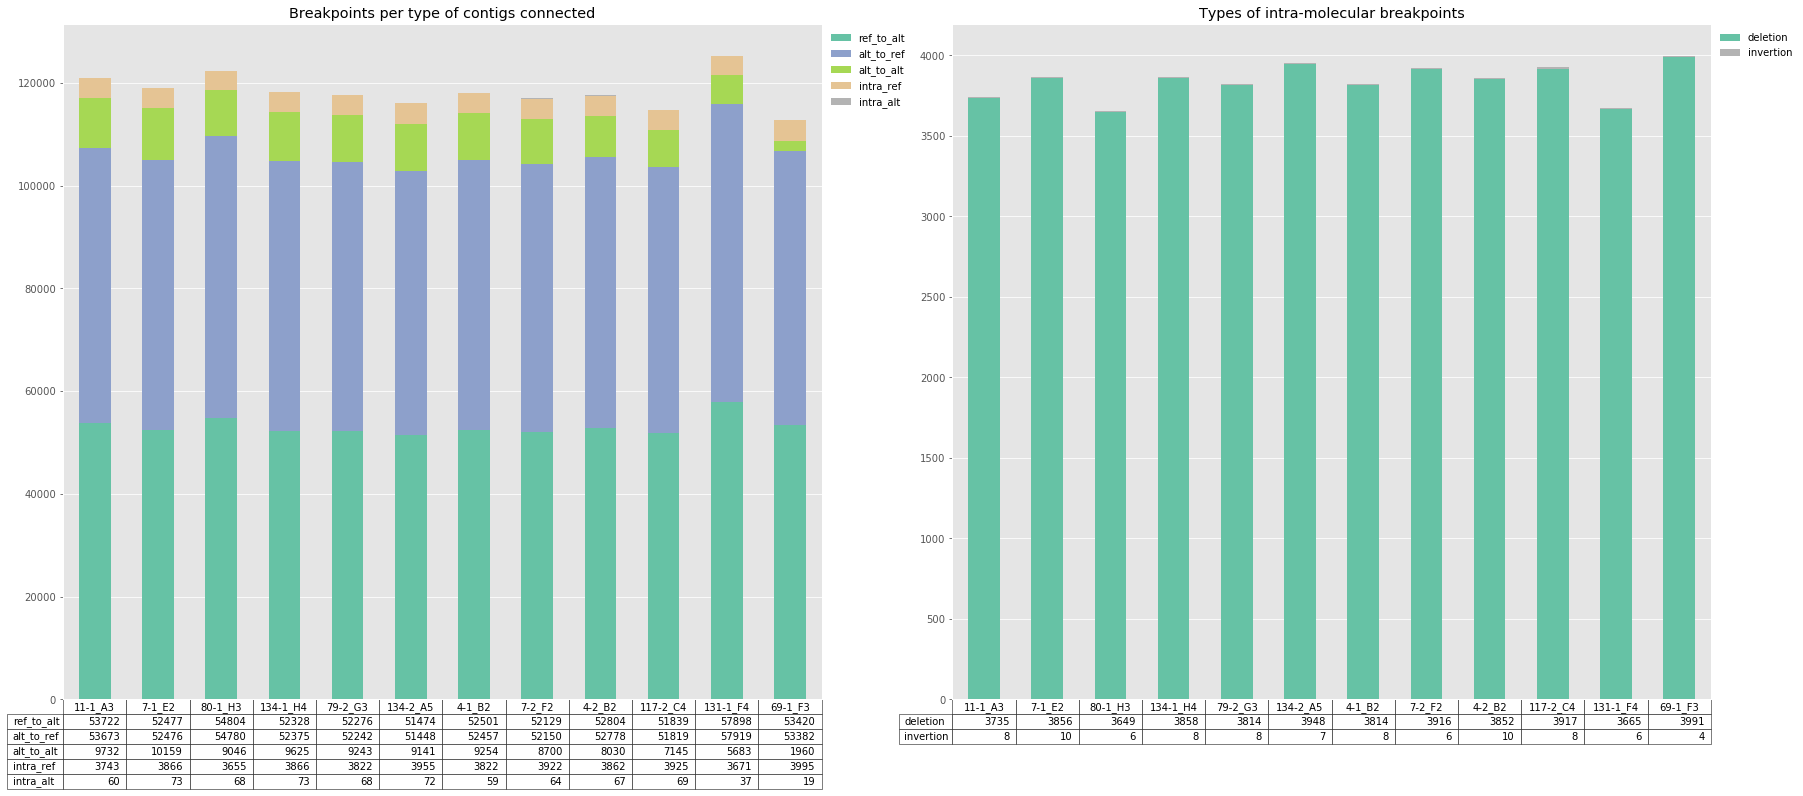

In [145]:
all_link_df = link_usage_stable (gaf_src="./alignments/assemblies/*_stable.gaf", fasta_canonical_ref="./references/Oryzias_latipes_clean.fa", min_align_len=100, min_mapq=1)
all_link_df.sample(10)

Parsing gaf files
	Parsing data for sample 80-1_H3
	Parsing data for sample 134-2_A5
	Parsing data for sample 131-1_F4
	Parsing data for sample 7-2_F2
	Parsing data for sample 7-1_E2
	Parsing data for sample 4-1_B2
	Parsing data for sample 69-1_F3
	Parsing data for sample 79-2_G3
	Parsing data for sample 134-1_H4
	Parsing data for sample 117-2_C4
	Parsing data for sample 11-1_A3
	Parsing data for sample 4-2_B2


,80-1_H3,134-2_A5,131-1_F4,7-2_F2,7-1_E2,4-1_B2,69-1_F3,79-2_G3,134-1_H4,117-2_C4,11-1_A3,4-2_B2
multi segment path,764564,1769320,1671635,1204671,1082995,1115479,1016166,1127996,1072134,1329566,826218,1316632
links,1694378,3949330,3726516,2716556,2521291,2539775,2238787,2538373,2476501,3036033,1889794,3044647
single segment path,2163034,5031003,4628263,3418637,2890260,3064656,2826116,3158979,2905726,3605827,2213245,3600468
low mapq alignments,78326,183315,170455,120409,104803,112424,100697,115169,106251,134487,79630,131040
short length alignments,28142,78398,73182,48550,44819,44821,38792,42263,42798,53689,31096,54356


Cast link usage data to DataFrame
Annotate link


100%|██████████| 692372/692372 [00:06<00:00, 101990.00it/s]


,,,,,,11-1_A3,7-1_E2,80-1_H3,134-1_H4,79-2_G3,134-2_A5,4-1_B2,7-2_F2,4-2_B2,117-2_C4,131-1_F4,69-1_F3,total,breakpoint_type,SV_type,breakpoint_length
s1_chromosome,s1_position,s1_orient,s2_chromosome,s2_position,s2_orient,,,,,,,,,,,,,,,,
6,10238564,+,ctg198_11-1_A3,52469,+,1,0,0,0,0,0,0,0,0,0,0,0,1,ref_to_alt,insertion,0
16,12773531,-,ctg9_69-1_F3,14118,+,0,0,1,0,0,0,0,0,0,0,0,1,2,ref_to_alt,insertion,0
22,15829149,-,ctg251_7-1_E2,727554,+,0,1,0,0,0,0,0,0,0,0,0,0,1,ref_to_alt,insertion,0
13,19631518,-,ctg619_7-2_F2,1801,-,1,0,0,1,0,1,1,0,0,0,1,0,5,ref_to_alt,insertion,0
ctg312_131-1_F4,408891,+,ctg461_69-1_F3,164578,-,0,0,0,0,1,0,0,0,0,0,1,0,2,alt_to_alt,insertion,0
ctg1109_134-1_H4,92178,+,1,22804800,-,0,0,0,1,0,0,0,0,0,0,0,0,1,alt_to_ref,insertion,0
ctg128_69-1_F3,444718,+,ctg33_134-1_H4,839290,+,0,0,0,1,0,0,0,0,0,0,0,0,1,alt_to_alt,insertion,0
ctg100_7-1_E2,670040,+,3,34132053,+,0,1,0,0,0,0,0,0,0,0,0,0,1,alt_to_ref,insertion,0
ctg623_69-1_F3,187949,-,5,539312,+,0,0,0,0,0,0,1,1,0,0,0,0,2,alt_to_ref,insertion,0


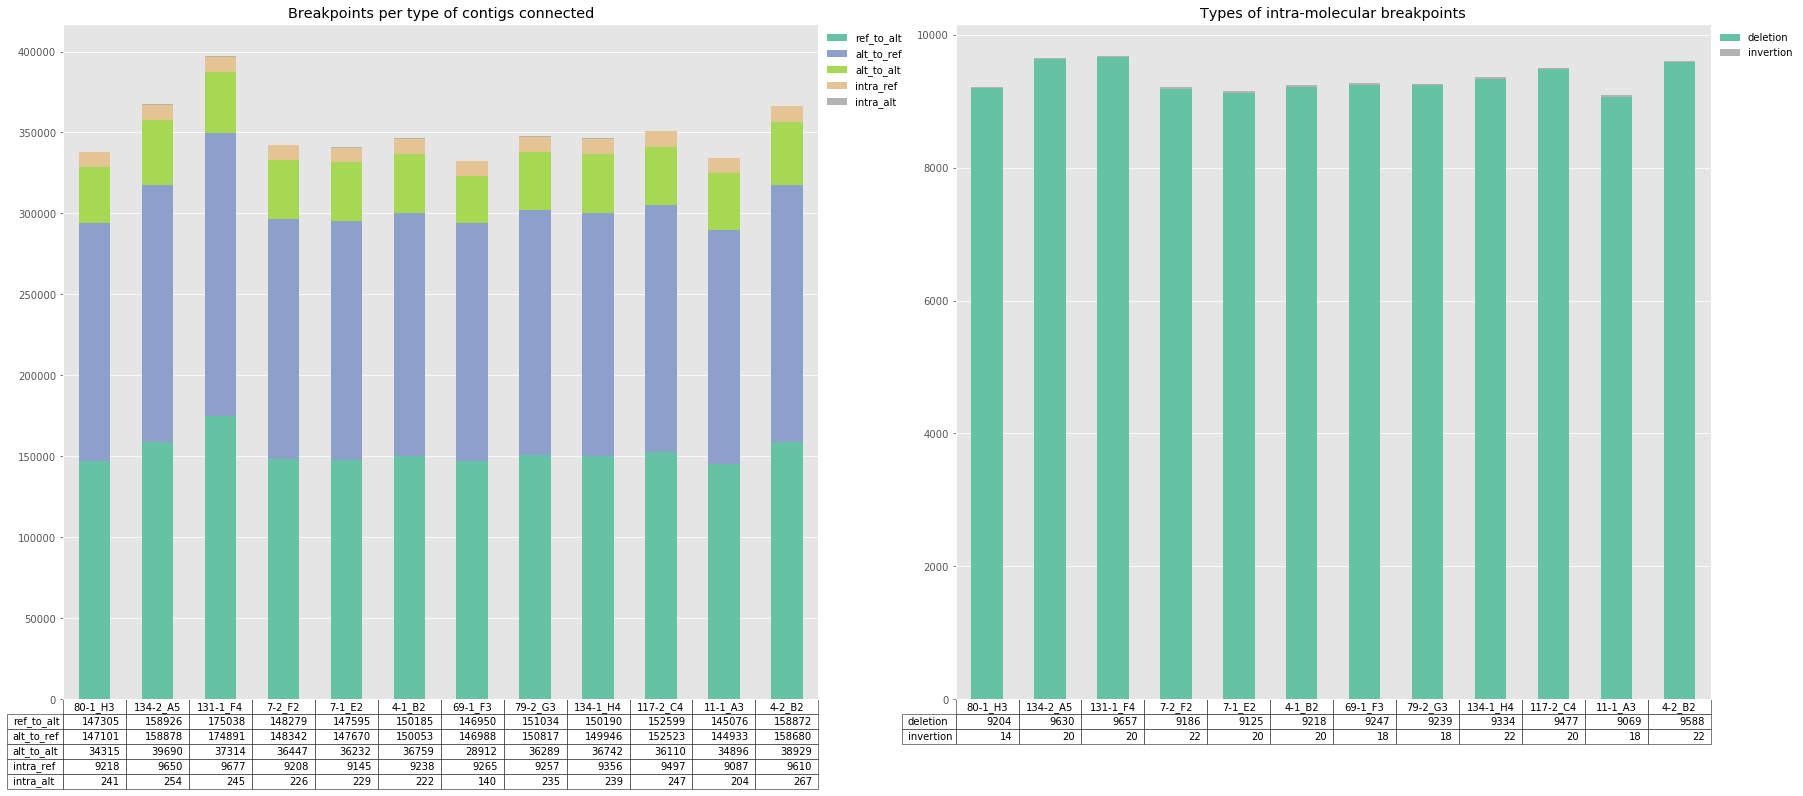

In [146]:
all_link_df_raw = link_usage_stable (gaf_src="./alignments/raw_reads/*_stable.gaf", fasta_canonical_ref="./references/Oryzias_latipes_clean.fa", min_align_len=100, min_mapq=1)
all_link_df.sample(10)

# Coordinates to segments

In [315]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df.loc["s2041":"s20455"]

,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,component,connected,connected_chromosome,connected_start,connected_end
seg_id,,,,,,,,,,,,,,
s2041,HDRR_1,1805961,1810089,4128,HDRR,NaN,None,NaN,NaN,1,"[s2040, s2042, s648940, s648939]",NaN,NaN,NaN
s2042,HDRR_1,1810089,1810428,339,HDRR,NaN,None,NaN,NaN,1,"[s2041, s994097, s2043]",NaN,NaN,NaN
s2043,HDRR_1,1810428,1810476,48,HDRR,NaN,None,NaN,NaN,1,"[s2042, s2044, s970517]",NaN,NaN,NaN
s2044,HDRR_1,1810476,1810508,32,HDRR,NaN,None,NaN,NaN,1,"[s2043, s2045, s2046]",NaN,NaN,NaN
s2045,HDRR_1,1810508,1810651,143,HDRR,NaN,None,NaN,NaN,1,"[s2044, s2046]",NaN,NaN,NaN
s2046,HDRR_1,1810651,1811022,371,HDRR,NaN,None,NaN,NaN,1,"[s2045, s2047, s2044]",NaN,NaN,NaN
s2047,HDRR_1,1811022,1811112,90,HDRR,NaN,None,NaN,NaN,1,"[s2046, s2048, s648941]",NaN,NaN,NaN
s2048,HDRR_1,1811112,1811150,38,HDRR,NaN,None,NaN,NaN,1,"[s2047, s2049, s800082]",NaN,NaN,NaN
s2049,HDRR_1,1811150,1811167,17,HDRR,NaN,None,NaN,NaN,1,"[s2048, s2050, s970517]",NaN,NaN,NaN


### Find segment id of MIKK het regions

In [44]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
het_coord_fn = "./extra/mikk_panel_proportion_het_across_genome_20200716.tsv"
het_coord_df = pd.read_csv(het_coord_fn, sep="\t")

,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,component,connected,connected_chromosome,connected_start,connected_end
seg_id,,,,,,,,,,,,,,
s1,HDRR_1,0,37816,37816,HDRR,NaN,None,NaN,NaN,1,"[s2, s1044544]",NaN,NaN,NaN
s2,HDRR_1,37816,37928,112,HDRR,NaN,None,NaN,NaN,1,"[s1, s3, s999575]",NaN,NaN,NaN
s3,HDRR_1,37928,40172,2244,HDRR,NaN,None,NaN,NaN,1,"[s2, s4]",NaN,NaN,NaN
s4,HDRR_1,40172,41595,1423,HDRR,NaN,None,NaN,NaN,1,"[s3, s5, s999575]",NaN,NaN,NaN
s5,HDRR_1,41595,50707,9112,HDRR,NaN,None,NaN,NaN,1,"[s4, s6, s1044544, s999574]",NaN,NaN,NaN


,chr,start,end,p_het
0,1,4156,14156,0.130435
1,1,14156,24156,1.000000
2,1,24156,34156,0.921739
3,1,34156,44156,0.895652
4,1,44156,54156,1.000000


In [119]:
import pybedtools as pbt

graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
het_coord_fn = "./extra/mikk_panel_proportion_het_across_genome_20200716.tsv"

stdout_print("Import coordinate file\n")
het_coord_df = pd.read_csv(het_coord_fn, sep="\t")
het_coord_df = het_coord_df[(het_coord_df["p_het"]==1)&(het_coord_df["chr"]!=1)]
het_coord_df = het_coord_df.drop_duplicates(ignore_index=True)
het_coord_df = het_coord_df.drop(columns=["p_het"])

stdout_print("Merge overlapping coordinates\n")
b = pbt.BedTool.from_dataframe(het_coord_df)
c = b.merge(d=10)
coord_df = c.to_dataframe()

stdout_print("Add length field and sort by length\n")
coord_df["length"] = coord_df["end"]-coord_df["start"]

stdout_print("Load graph info file\n")
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df[graph_info_df["type"]=="HDRR"]

stdout_print("Find id of segments overlapping each block \n")
start_seg_list = []
end_seg_list = []
n_seg_list = []
for line in coord_df.itertuples():
    start_seg = graph_info_df[(graph_info_df["component"]==line.chrom)&(line.start>=graph_info_df["start"])&(line.start<=graph_info_df["end"])].index[0]
    end_seg = graph_info_df[(graph_info_df["component"]==line.chrom)&(line.end>=graph_info_df["start"])&(line.end<=graph_info_df["end"])].index[0]
    n_seg = int(end_seg[1:]) - int(start_seg[1:])
    start_seg_list.append(start_seg)
    end_seg_list.append(end_seg)
    n_seg_list.append(n_seg)
coord_df["start_seg"] = start_seg_list
coord_df["end_seg"] = end_seg_list
coord_df["n_seg"] = n_seg_list
coord_df["n_seg_len"] = (coord_df["n_seg"]/coord_df["length"]*10000).astype(int)
coord_df = coord_df[(coord_df["n_seg_len"]>=15)] ################## Select messy regions
print(f"Found {len(coord_df)} intervals within required ranges")

coord_df["seg_list"] = coord_df["start_seg"]+","+coord_df["end_seg"]
coord_df["coord"] = coord_df["chrom"].astype(str)+":"+coord_df["start"].astype(str)+"-"+coord_df["end"].astype(str) 
coord_df

Import coordinate file
Merge overlapping coordinates
Add length field and sort by length
Load graph info file
Find id of segments overlapping each block 
Found 161 intervals within required ranges


,chrom,start,end,length,start_seg,end_seg,n_seg,n_seg_len,seg_list,coord
29,2,23180011,23190011,10000,s56815,s56837,22,22,"s56815,s56837",2:23180011-23190011
31,2,23730011,23750011,20000,s57642,s57674,32,16,"s57642,s57674",2:23730011-23750011
35,3,2330014,2340014,10000,s61243,s61258,15,15,"s61243,s61258",3:2330014-2340014
39,3,5770014,5810014,40000,s64617,s64682,65,16,"s64617,s64682",3:5770014-5810014
61,3,9100014,9120014,20000,s67699,s67730,31,15,"s67699,s67730",3:9100014-9120014
64,3,10190014,10200014,10000,s68600,s68617,17,17,"s68600,s68617",3:10190014-10200014
75,3,16940014,16950014,10000,s74253,s74268,15,15,"s74253,s74268",3:16940014-16950014
94,3,32560014,32570014,10000,s85836,s85852,16,16,"s85836,s85852",3:32560014-32570014
110,4,2750105,2760105,10000,s94065,s94089,24,23,"s94065,s94089",4:2750105-2760105
142,4,17040105,17060105,20000,s106415,s106449,34,17,"s106415,s106449",4:17040105-17060105


### Find segment id of LD decay regions

In [127]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"

coord_list = [
    (5,28181970,28970558),
    (6,29398579,32246747),
    (12,25336174,25384053),
    (14,12490842,12947083),
    (17,15557892,19561518),
    (21,6710074,7880374)]

res = namedtuple("res", ["chrom","start","end","length","start_seg","end_seg","n_seg","seg_list","coord"])

stdout_print("Load graph info file\n")
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df[graph_info_df["type"]=="HDRR"]

stdout_print("Find id of segments overlapping each block \n")
res_list = []

for chrom, start, end in coord_list:
    start_seg = graph_info_df[(graph_info_df["component"]==chrom)&(start>=graph_info_df["start"])&(start<=graph_info_df["end"])].index[0]
    end_seg = graph_info_df[(graph_info_df["component"]==chrom)&(end>=graph_info_df["start"])&(end<=graph_info_df["end"])].index[0]
    n_seg = int(end_seg[1:]) - int(start_seg[1:])
    seg_list = f"{start_seg},{end_seg}"
    coord = f"{chrom}:{start}-{end}" 
    res_list.append(res(chrom, start, end, end-start, start_seg, end_seg, n_seg, seg_list, coord))
    
pd.DataFrame(res_list)

Load graph info file
Find id of segments overlapping each block 


,chrom,start,end,length,start_seg,end_seg,n_seg,seg_list,coord
0,5,28181970,28970558,788588,s147321,s147889,568,"s147321,s147889",5:28181970-28970558
1,6,29398579,32246747,2848168,s176581,s179446,2865,"s176581,s179446",6:29398579-32246747
2,12,25336174,25384053,47879,s336317,s336387,70,"s336317,s336387",12:25336174-25384053
3,14,12490842,12947083,456241,s382112,s382516,404,"s382112,s382516",14:12490842-12947083
4,17,15557892,19561518,4003626,s465947,s469793,3846,"s465947,s469793",17:15557892-19561518
5,21,6710074,7880374,1170300,s557411,s558466,1055,"s557411,s558466",21:6710074-7880374
